# Library


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Setting

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define audio parameters
SAMPLE_RATE = 16000  # 16kHz sample rate
N_MFCC = 40          # Number of MFCC features
N_FFT = 400          # FFT window size
HOP_LENGTH = 160     # Hop length for STFT

# Path for audio data
TRAIN_AUDIO_PATH = 'Data_People/Training/'
TEST_AUDIO_PATH = 'Data_People/Testing/'

# Classes for classification
classes = ["SUBHANALLAH", "ALLAHUAKBAR", "ALHAMDULLILAH"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
idx_to_class = {idx: cls for idx, cls in enumerate(classes)}

Using device: cuda


# Dataset & Feature Extraction

In [3]:
# Audio Dataset Class
class AudioWordDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the audio files.
        """
        self.root_dir = Path(root_dir)
        self.samples = []
        
        # Check if the root directory exists
        if not self.root_dir.exists():
            raise FileNotFoundError(f"Directory {root_dir} does not exist")
        
        # Walk through all files in directory
        for word_dir in self.root_dir.iterdir():
            if word_dir.is_dir() and word_dir.name in classes:
                word_class = word_dir.name
                for audio_file in word_dir.glob('*.wav'):
                    self.samples.append((str(audio_file), class_to_idx[word_class]))
        
        if len(self.samples) == 0:
            print(f"Warning: No audio files found in {root_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        try:
            audio_path, label = self.samples[idx]
            
            # Load audio with error handling
            try:
                waveform, sample_rate = torchaudio.load(audio_path)
            except Exception as e:
                print(f"Error loading audio file {audio_path}: {e}")
                # Return a dummy waveform and the label
                return torch.zeros(1, 16000), label
            
            # Convert to mono if stereo
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)
            
            # Ensure minimum length
            if waveform.shape[1] < 1000:  # Arbitrary minimum length
                waveform = torch.nn.functional.pad(waveform, (0, 1000 - waveform.shape[1]))
            
            # Limit maximum length to avoid memory issues
            max_length = 16000 * 5  # ~5 seconds at 16kHz
            if waveform.shape[1] > max_length:
                waveform = waveform[:, :max_length]
            
            # Extract MFCC features directly here to simplify the pipeline
            mfcc_transform = torchaudio.transforms.MFCC(
                sample_rate=sample_rate,
                n_mfcc=N_MFCC,
                melkwargs={
                    'n_fft': N_FFT,
                    'n_mels': 128,
                    'hop_length': HOP_LENGTH,
                }
            )
            
            # Extract features and normalize
            mfcc = mfcc_transform(waveform)
            mean = mfcc.mean()
            std = mfcc.std()
            mfcc = (mfcc - mean) / (std + 1e-10)
            
            return mfcc, label
        
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            # Return a dummy tensor and the label
            return torch.zeros(N_MFCC, 100), 0

# CNN

In [4]:
# Define CNN Model
class AudioCNN(nn.Module):
    def __init__(self, n_mfcc=N_MFCC, n_classes=len(classes)):
        super(AudioCNN, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.relu3 = nn.ReLU()
        
        # Adaptive pooling to handle variable size inputs
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # FC layers with fixed input size due to adaptive pooling
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc_relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, n_classes)
    
    def forward(self, x):
        # Add channel dimension if necessary
        if x.dim() == 3:  # [batch, mfcc, time]
            x = x.unsqueeze(1)  # [batch, 1, mfcc, time]
        
        # CNN
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        
        # Adaptive pooling to handle variable sizes
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC
        x = self.fc_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [5]:
# Simplified collate function for variable length audio
def collate_fn(batch):
    # Filter out any None values that might have been returned from __getitem__
    batch = [(mfcc, label) for mfcc, label in batch if mfcc is not None]
    
    if len(batch) == 0:
        return torch.zeros(0, 1, N_MFCC, 100).to(device), torch.zeros(0).long().to(device)
    
    # Separate features and labels
    features, labels = zip(*batch)
    
    # Max length in the time dimension
    max_length = max([feature.shape[2] for feature in features])
    
    # Pad sequences to max length
    padded_features = []
    for feature in features:
        padding_size = max_length - feature.shape[2]
        if padding_size > 0:
            padded_feature = torch.nn.functional.pad(feature, (0, padding_size))
        else:
            padded_feature = feature
        padded_features.append(padded_feature)
    
    # Stack tensors
    features_tensor = torch.stack(padded_features)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    return features_tensor, labels_tensor


# Data Loader


In [6]:
# Create data loaders with safer settings
def create_dataloaders(batch_size=16):
    try:
        # Create datasets with error handling
        train_dataset = AudioWordDataset(TRAIN_AUDIO_PATH)
        test_dataset = AudioWordDataset(TEST_AUDIO_PATH)
        
        print(f"Training samples: {len(train_dataset)}")
        print(f"Testing samples: {len(test_dataset)}")
        
        if len(train_dataset) == 0 or len(test_dataset) == 0:
            raise ValueError("One or both datasets are empty")
        
        # Create data loaders with fewer workers and persistent workers=False for stability
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=0,  # Use 0 for debugging, increase if stable
            pin_memory=True if torch.cuda.is_available() else False
        )
        
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0,  # Use 0 for debugging, increase if stable
            pin_memory=True if torch.cuda.is_available() else False
        )
        
        return train_loader, test_loader
    
    except Exception as e:
        print(f"Error creating data loaders: {e}")
        raise


# Train & Validate

In [7]:
# Training function
def train_one_epoch(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    try:
        for i, (inputs, labels) in enumerate(train_loader):
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Skip empty batches
                if inputs.size(0) == 0:
                    continue
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # Statistics
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                if (i + 1) % 5 == 0:
                    print(f'Epoch {epoch+1}, Batch {i+1}: Loss: {running_loss / (i+1):.3f}, Acc: {100 * correct / total:.2f}%')
            
            except Exception as e:
                print(f"Error in batch {i}: {e}")
                continue
        
        # Avoid division by zero
        epoch_loss = running_loss / max(len(train_loader), 1)
        epoch_acc = 100 * correct / max(total, 1)
        
        return epoch_loss, epoch_acc
    
    except Exception as e:
        print(f"Error in training epoch {epoch}: {e}")
        return 0.0, 0.0

In [8]:
# Validation function
def validate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in test_loader:
                try:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    # Skip empty batches
                    if inputs.size(0) == 0:
                        continue
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    # Statistics
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    # Save predictions and labels for confusion matrix
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                
                except Exception as e:
                    print(f"Error in validation batch: {e}")
                    continue
        
        # Avoid division by zero
        val_loss = running_loss / max(len(test_loader), 1)
        val_acc = 100 * correct / max(total, 1)
        
        return val_loss, val_acc, all_preds, all_labels
    
    except Exception as e:
        print(f"Error in validation: {e}")
        return 0.0, 0.0, [], []


# Analysis

In [9]:
# Plot metrics
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(train_losses, label='Training Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        
        # Plot accuracies
        ax2.plot(train_accs, label='Training Accuracy')
        ax2.plot(val_accs, label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting metrics: {e}")


In [10]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    try:
        if len(y_true) == 0 or len(y_pred) == 0:
            print("No data to create confusion matrix")
            return
        
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        
        # Calculate class-wise accuracy
        class_acc = cm.diagonal() / cm.sum(axis=1) * 100
        for i, acc in enumerate(class_acc):
            print(f'Accuracy for class {idx_to_class[i]}: {acc:.2f}%')
        
    except Exception as e:
        print(f"Error plotting confusion matrix: {e}")


# Main

In [11]:
# Hyperparameters
batch_size = 8  
learning_rate = 0.003
num_epochs = 50

In [12]:
# Create data loaders with error handling
train_loader, test_loader = create_dataloaders(batch_size)

Training samples: 57
Testing samples: 15


In [13]:
# Sample a batch to verify data shape before proceeding
for inputs, labels in train_loader:
    print(f"Sample batch shape: {inputs.shape}, Labels: {labels.shape}")
    break

Sample batch shape: torch.Size([8, 1, 40, 264]), Labels: torch.Size([8])


In [14]:
        
# Initialize model
model = AudioCNN().to(device)
print(model)

AudioCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu3): ReLU()
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc_relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=Fal

In [15]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
# Training and validation metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

Epoch 1/50
----------
Epoch 1, Batch 5: Loss: 2.180, Acc: 27.50%
Training Loss: 2.0783, Training Acc: 28.07%
Validation Loss: 1.7444, Validation Acc: 33.33%



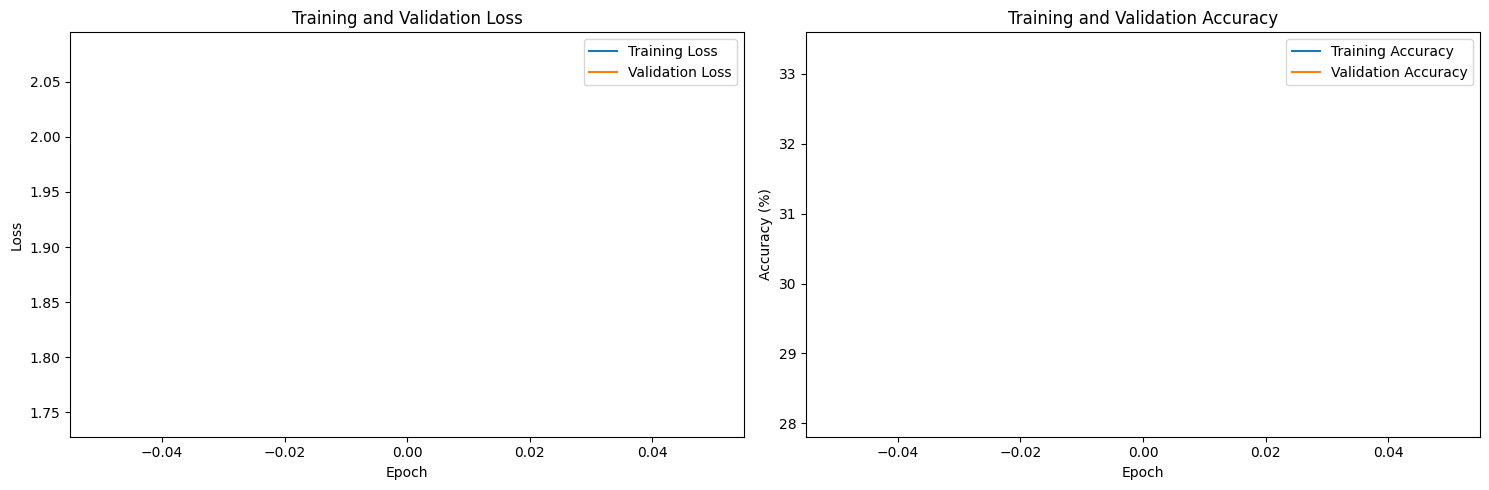

Confusion Matrix:


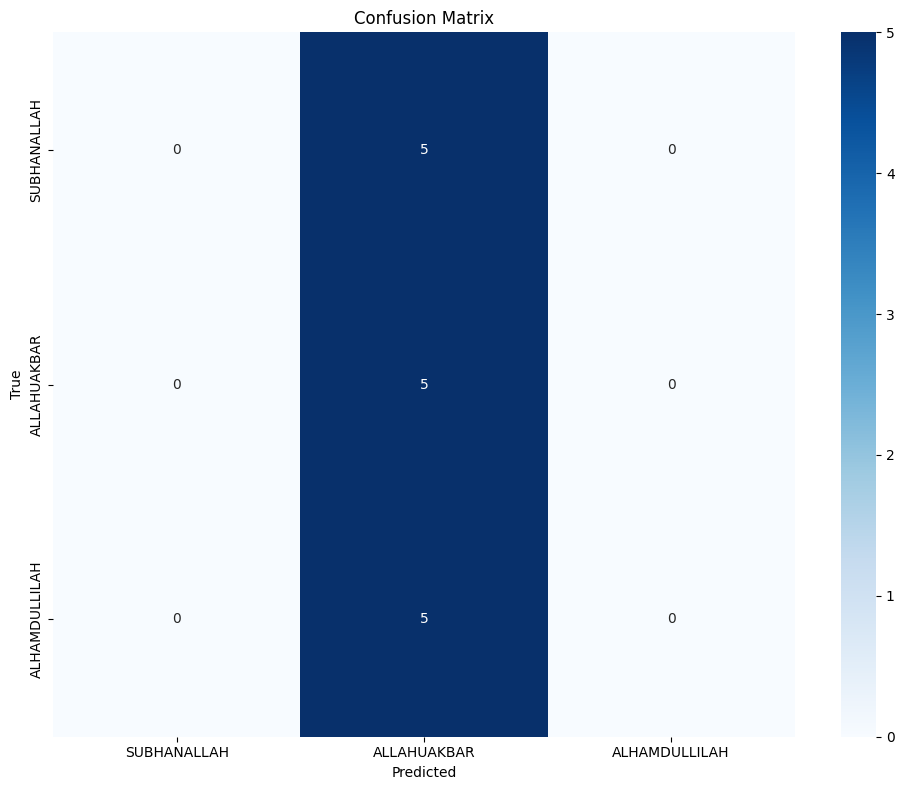

Accuracy for class SUBHANALLAH: 0.00%
Accuracy for class ALLAHUAKBAR: 100.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 2/50
----------
Epoch 2, Batch 5: Loss: 2.076, Acc: 37.50%
Training Loss: 2.3742, Training Acc: 31.58%
Validation Loss: 1.2754, Validation Acc: 33.33%



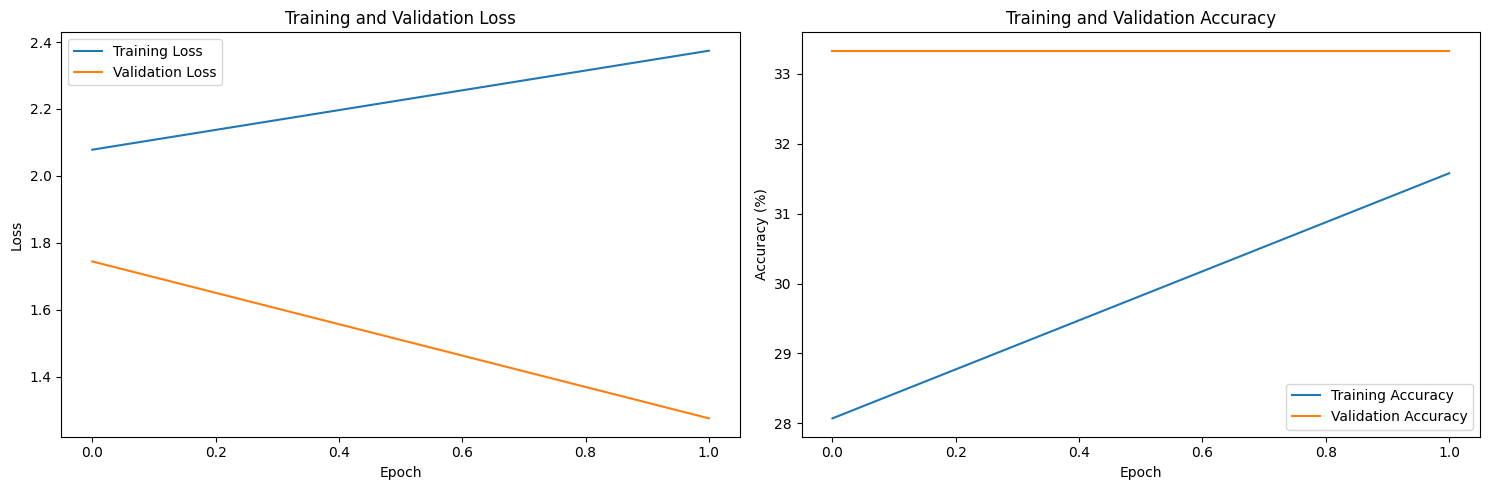

Confusion Matrix:


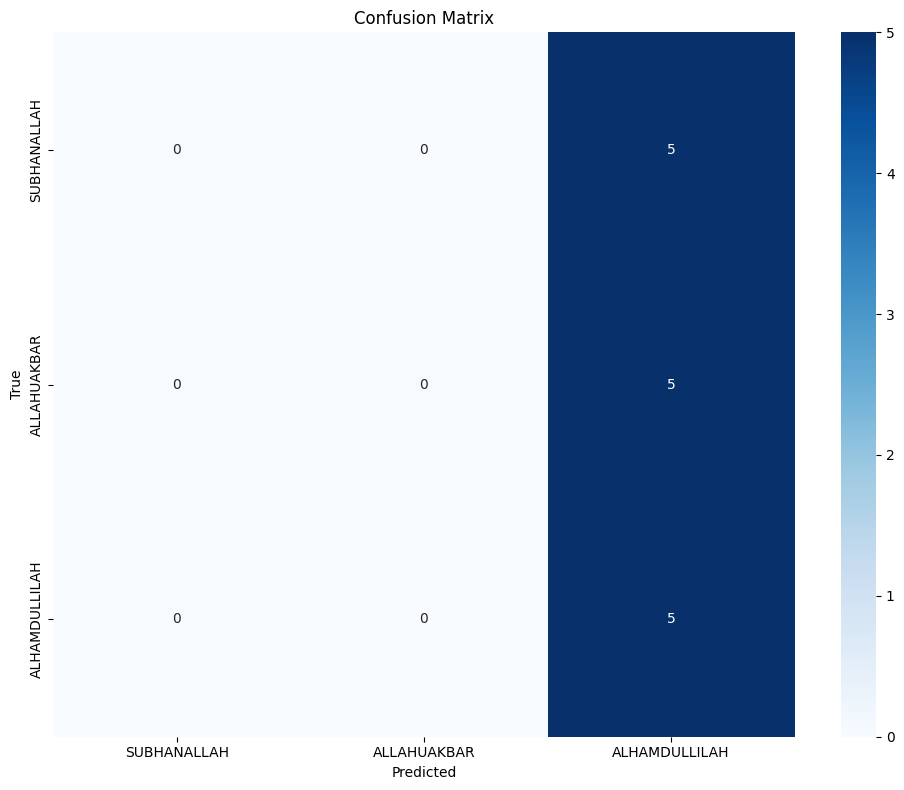

Accuracy for class SUBHANALLAH: 0.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 100.00%
Training and evaluation completed!
Epoch 3/50
----------
Epoch 3, Batch 5: Loss: 1.395, Acc: 22.50%
Training Loss: 1.3020, Training Acc: 24.56%
Validation Loss: 1.1805, Validation Acc: 33.33%



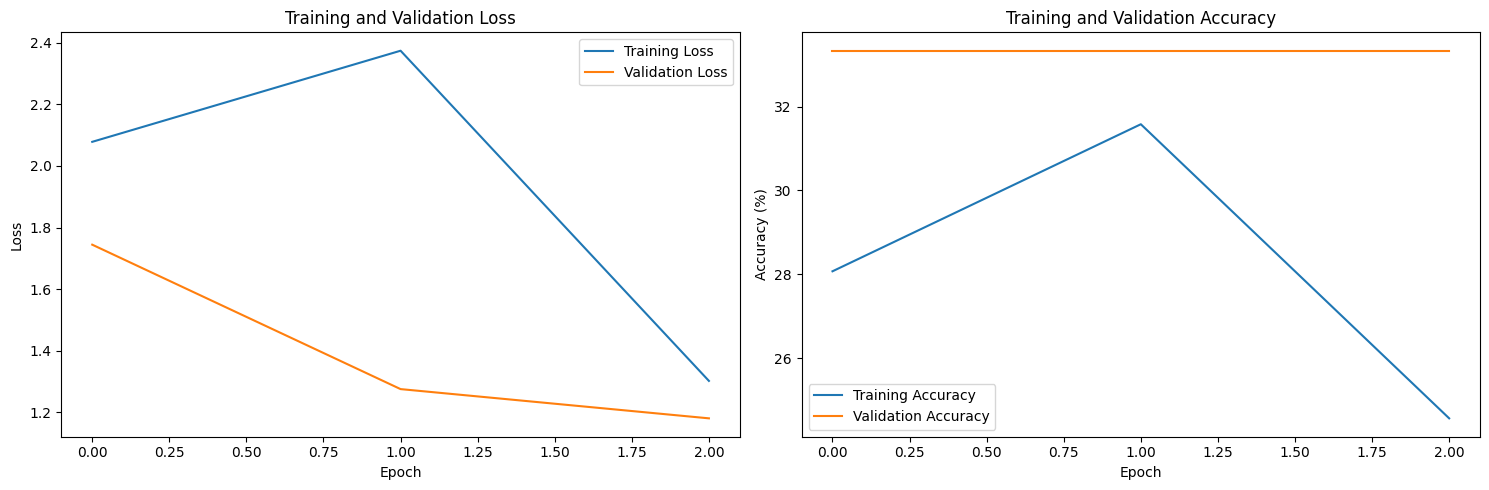

Confusion Matrix:


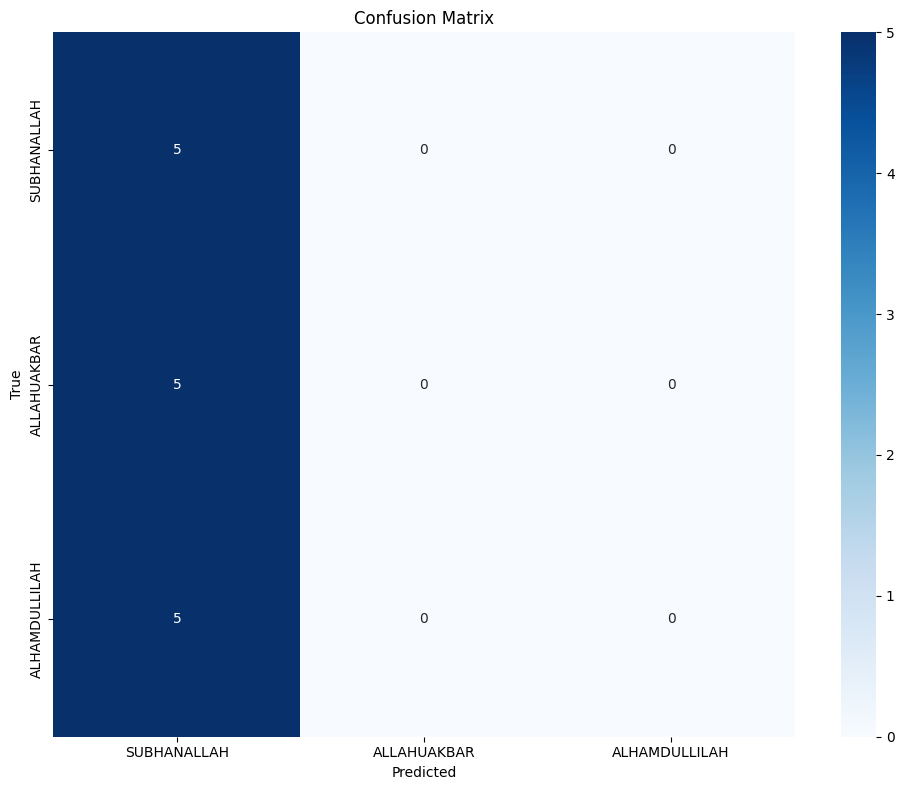

Accuracy for class SUBHANALLAH: 100.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 4/50
----------
Epoch 4, Batch 5: Loss: 1.235, Acc: 30.00%
Training Loss: 1.1444, Training Acc: 31.58%
Validation Loss: 1.0896, Validation Acc: 33.33%



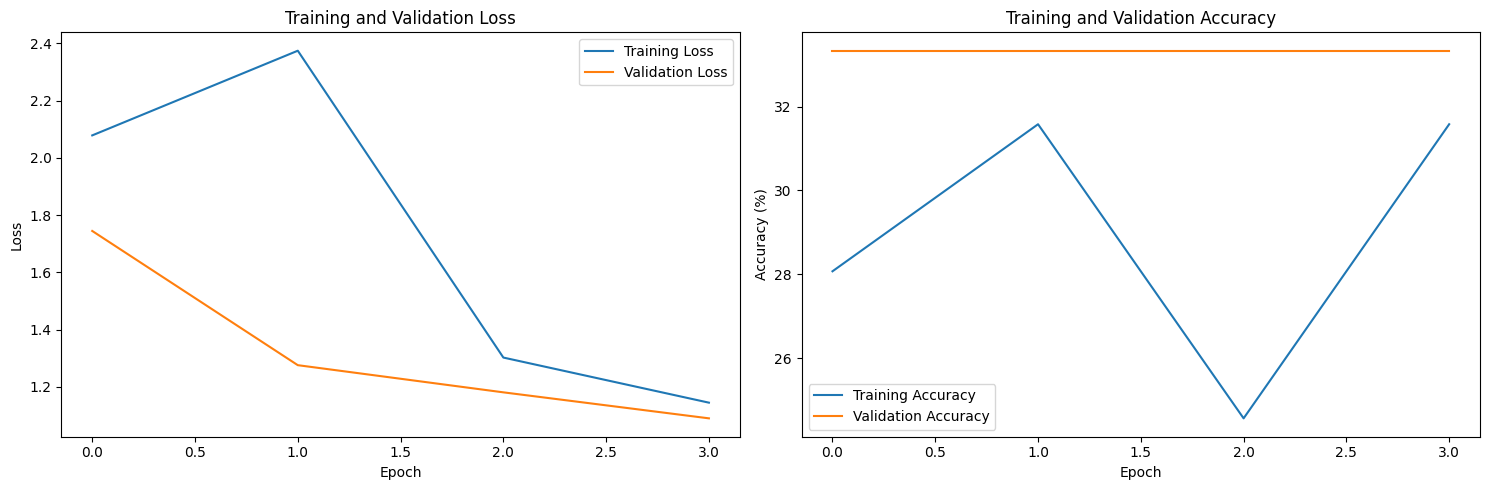

Confusion Matrix:


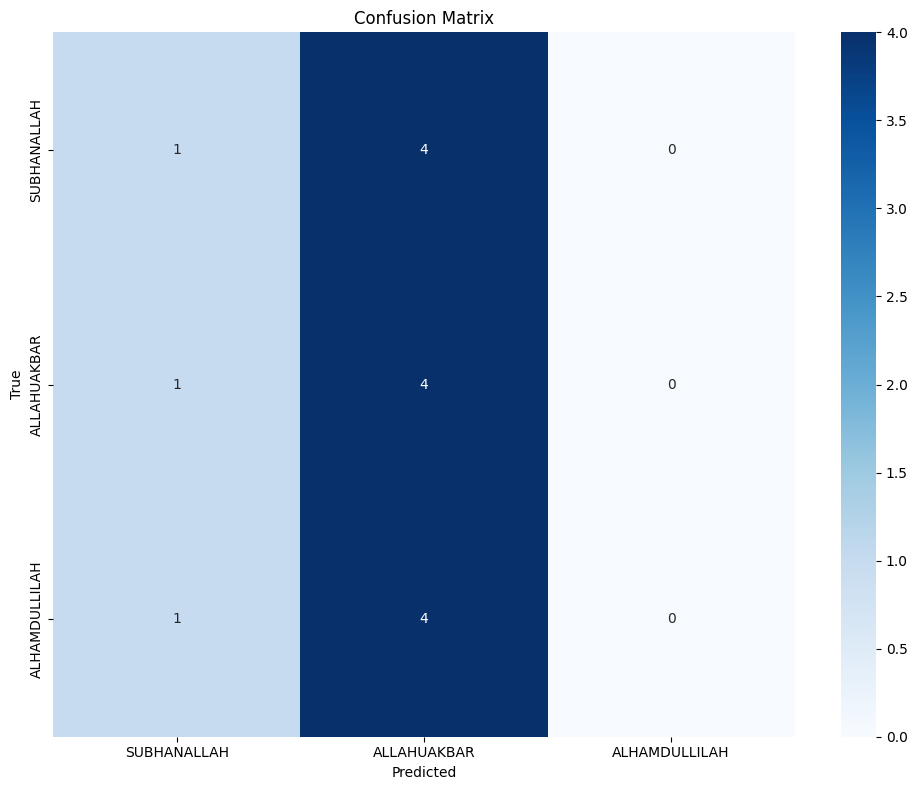

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 80.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 5/50
----------
Epoch 5, Batch 5: Loss: 1.202, Acc: 25.00%
Training Loss: 1.1981, Training Acc: 28.07%
Validation Loss: 1.1218, Validation Acc: 33.33%



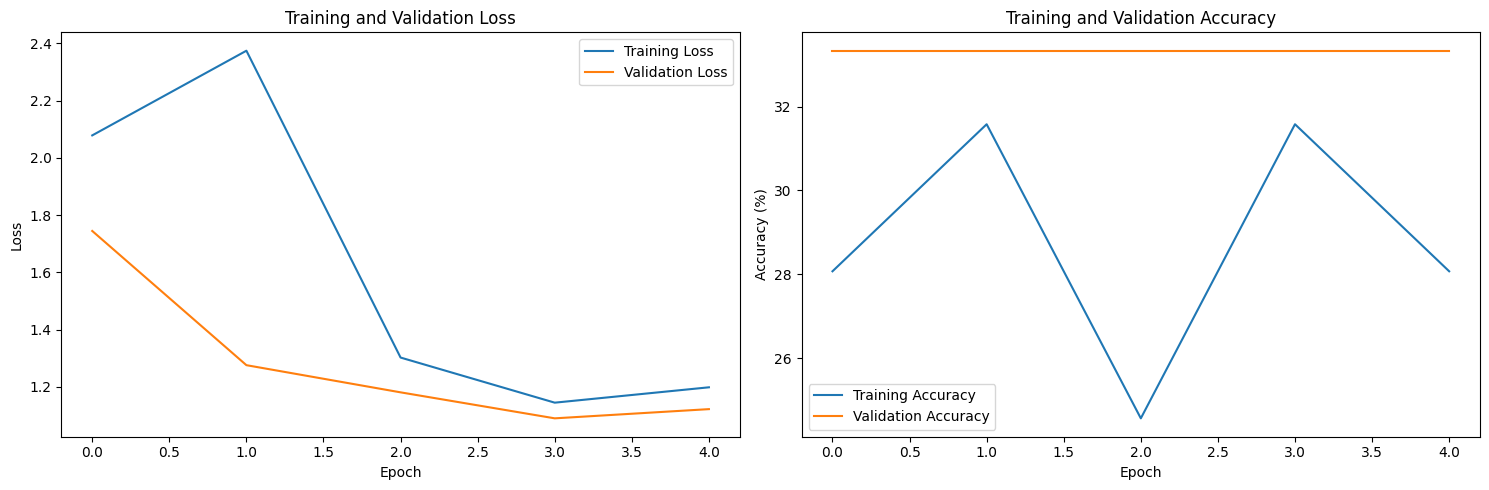

Confusion Matrix:


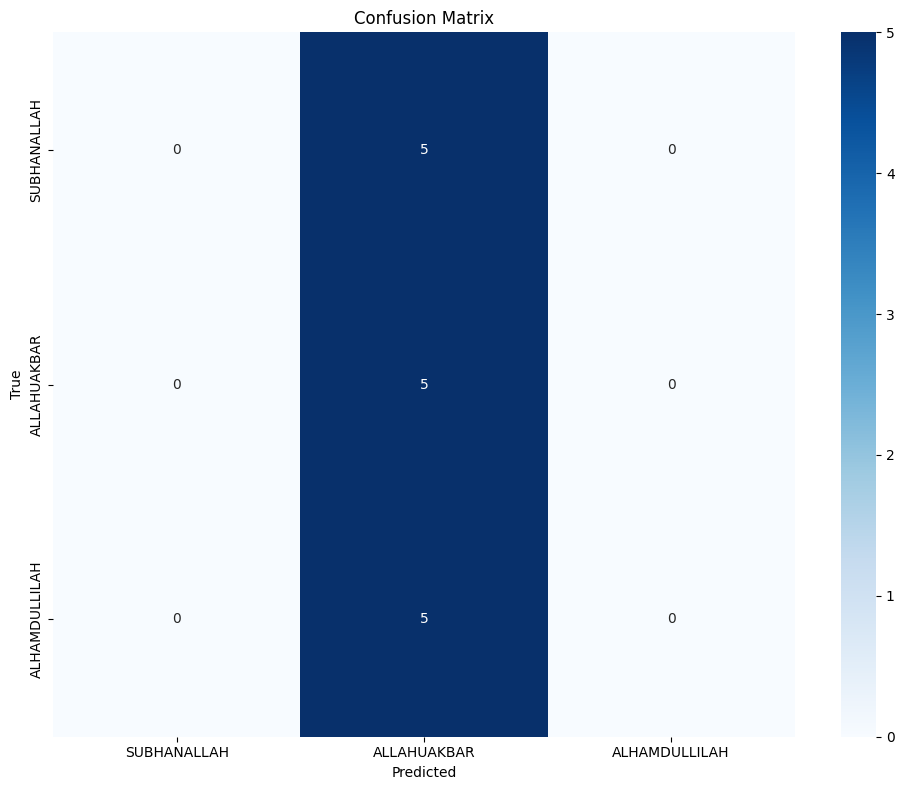

Accuracy for class SUBHANALLAH: 0.00%
Accuracy for class ALLAHUAKBAR: 100.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 6/50
----------
Epoch 6, Batch 5: Loss: 1.078, Acc: 40.00%
Training Loss: 1.1332, Training Acc: 38.60%
Validation Loss: 1.1045, Validation Acc: 33.33%



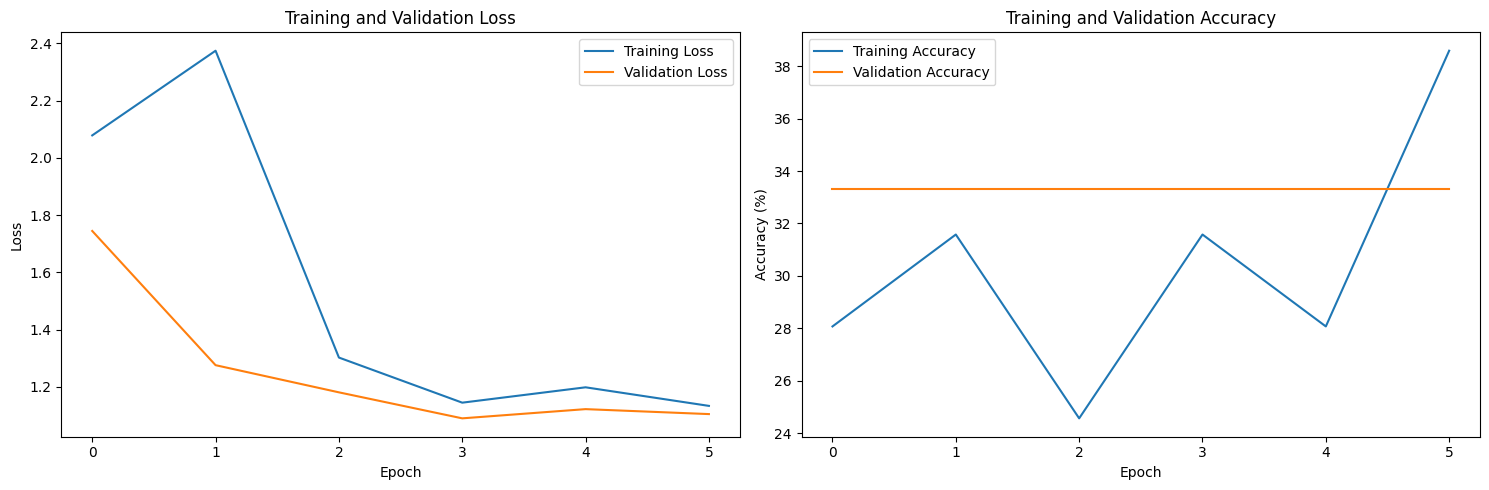

Confusion Matrix:


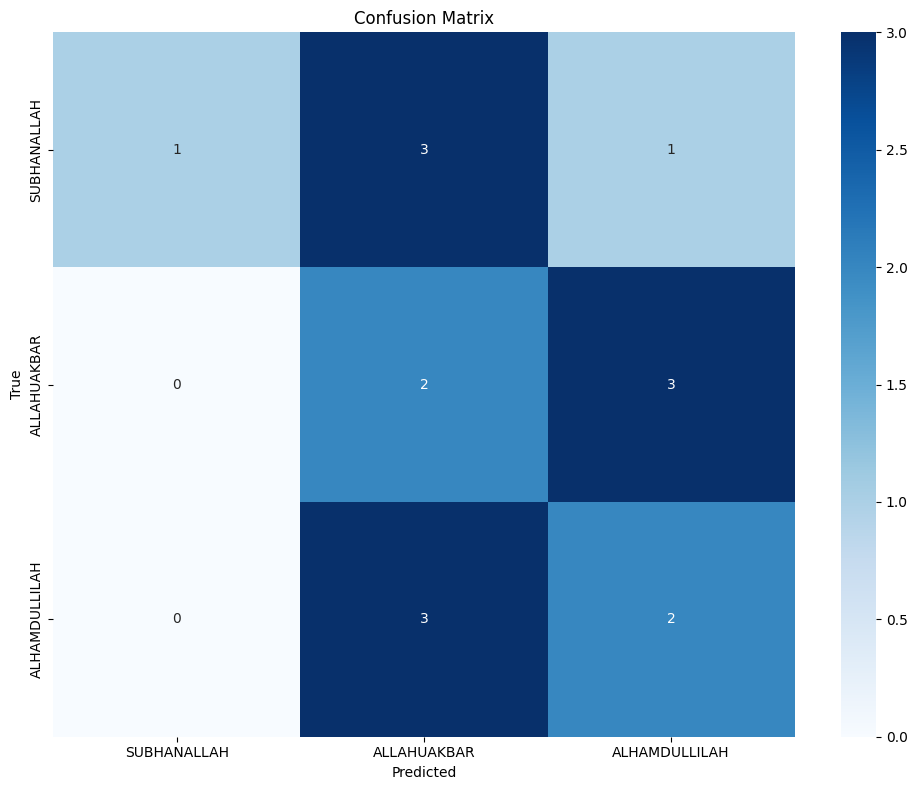

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 40.00%
Accuracy for class ALHAMDULLILAH: 40.00%
Training and evaluation completed!
Epoch 7/50
----------
Epoch 7, Batch 5: Loss: 1.046, Acc: 40.00%
Training Loss: 1.1208, Training Acc: 36.84%
Validation Loss: 1.1922, Validation Acc: 40.00%



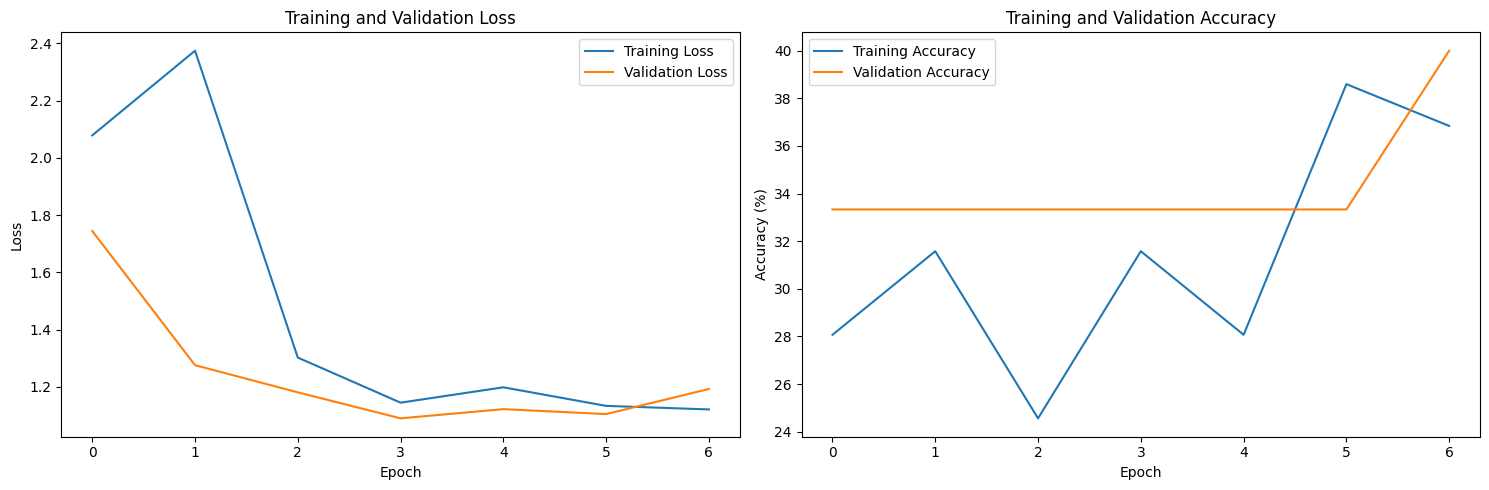

Confusion Matrix:


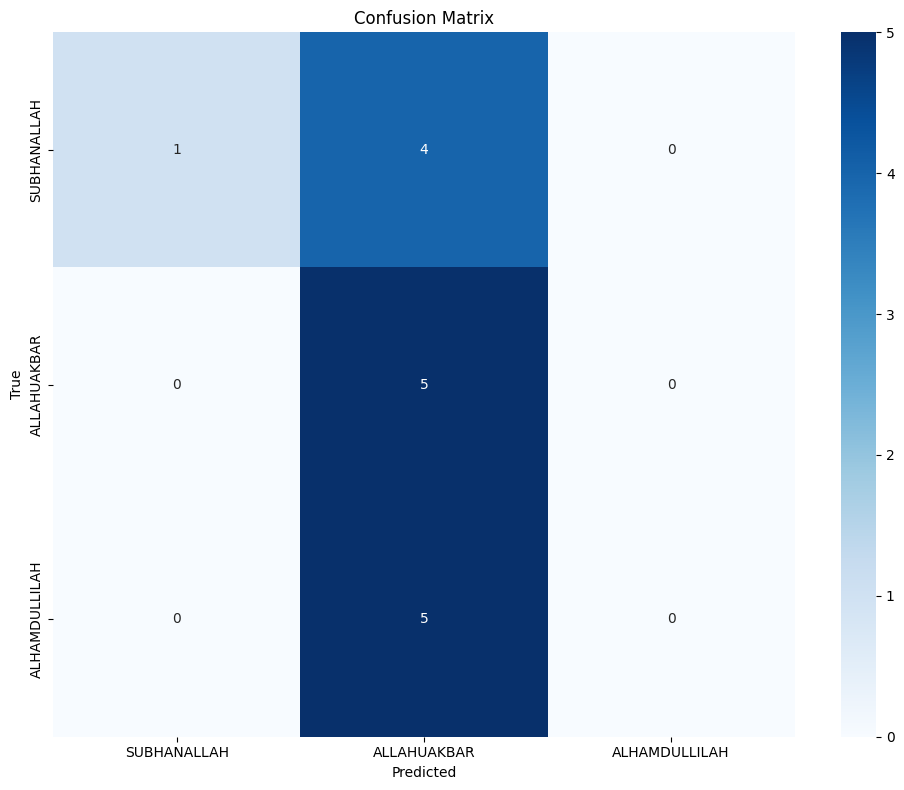

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 100.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 8/50
----------
Epoch 8, Batch 5: Loss: 1.126, Acc: 35.00%
Training Loss: 1.1627, Training Acc: 36.84%
Validation Loss: 1.1202, Validation Acc: 33.33%



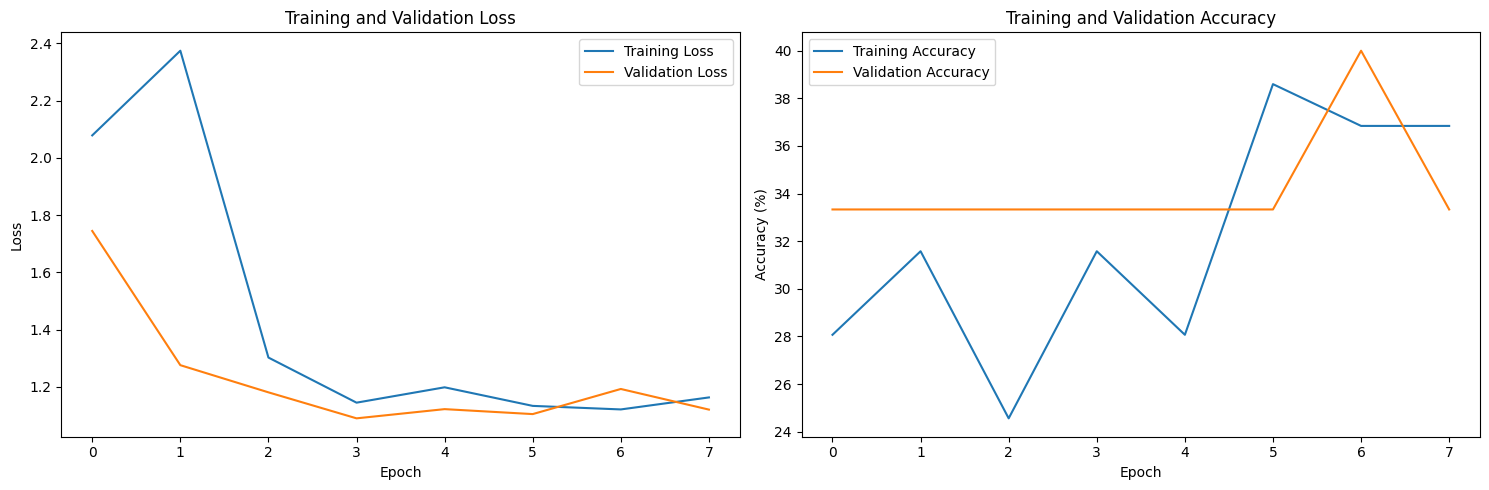

Confusion Matrix:


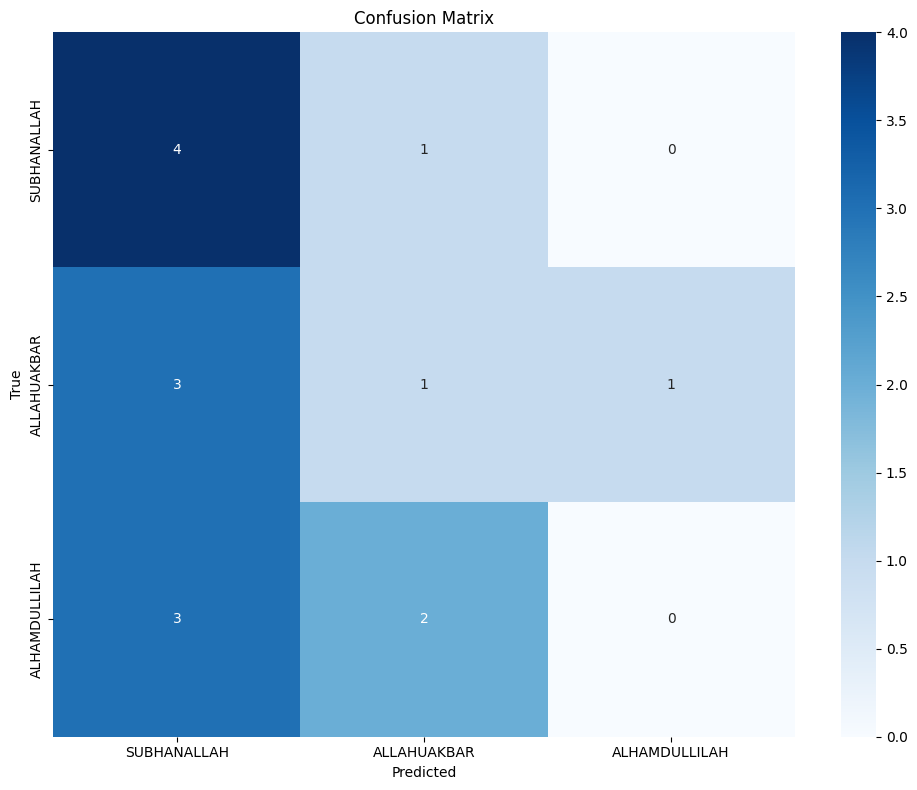

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 20.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 9/50
----------
Epoch 9, Batch 5: Loss: 1.108, Acc: 40.00%
Training Loss: 1.1551, Training Acc: 40.35%
Validation Loss: 1.1421, Validation Acc: 33.33%



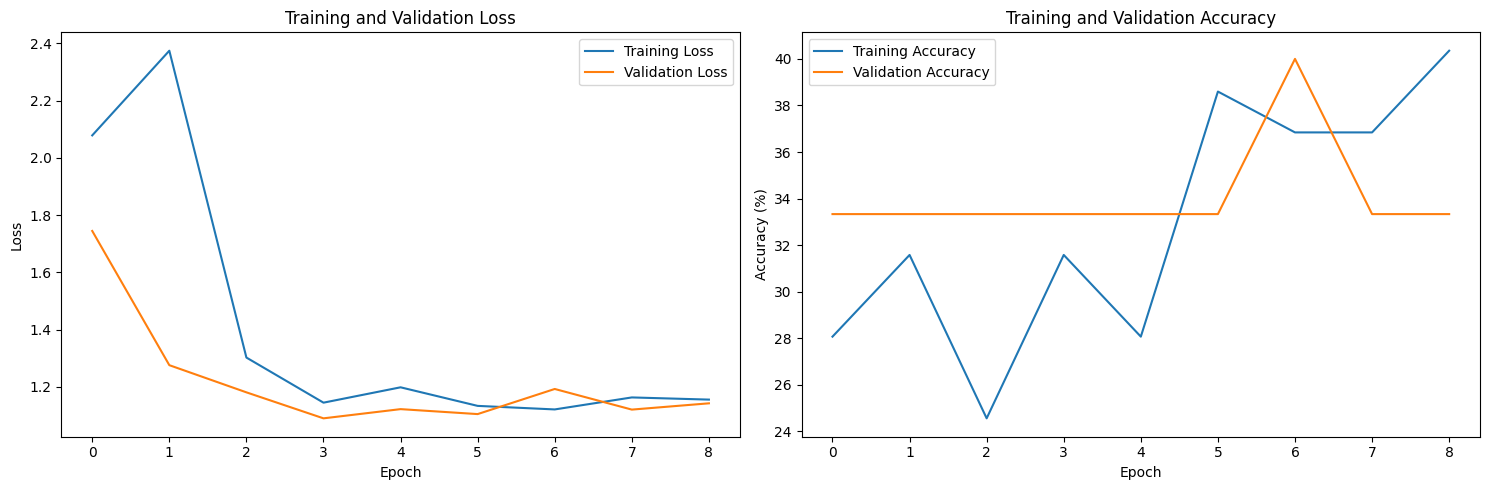

Confusion Matrix:


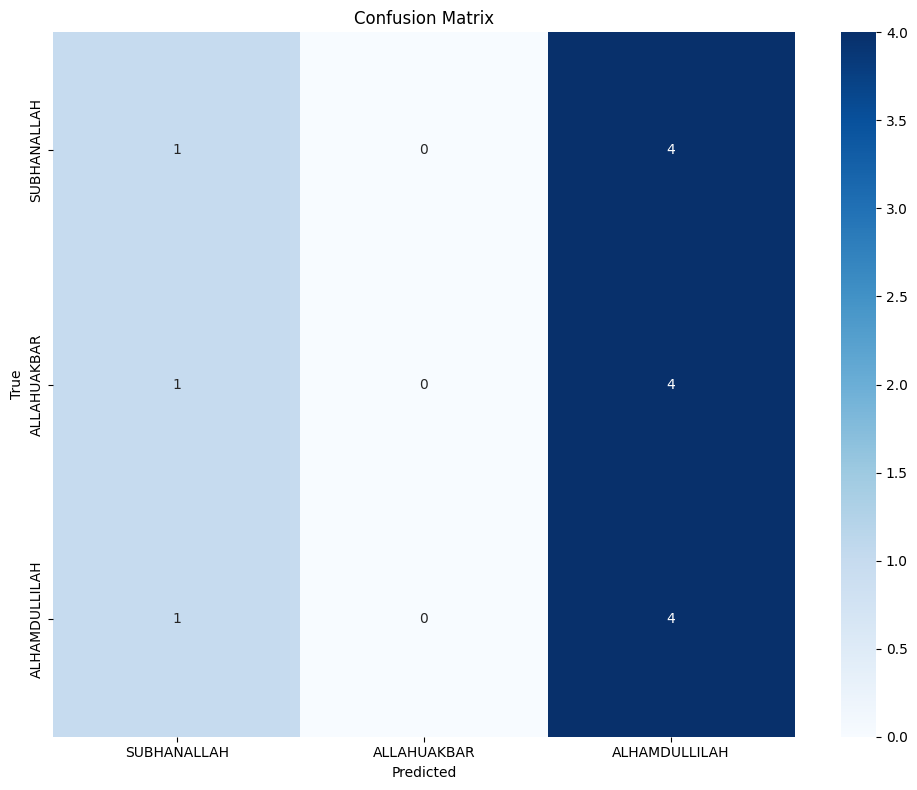

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 80.00%
Training and evaluation completed!
Epoch 10/50
----------
Epoch 10, Batch 5: Loss: 1.069, Acc: 45.00%
Training Loss: 1.0499, Training Acc: 47.37%
Validation Loss: 1.1204, Validation Acc: 33.33%



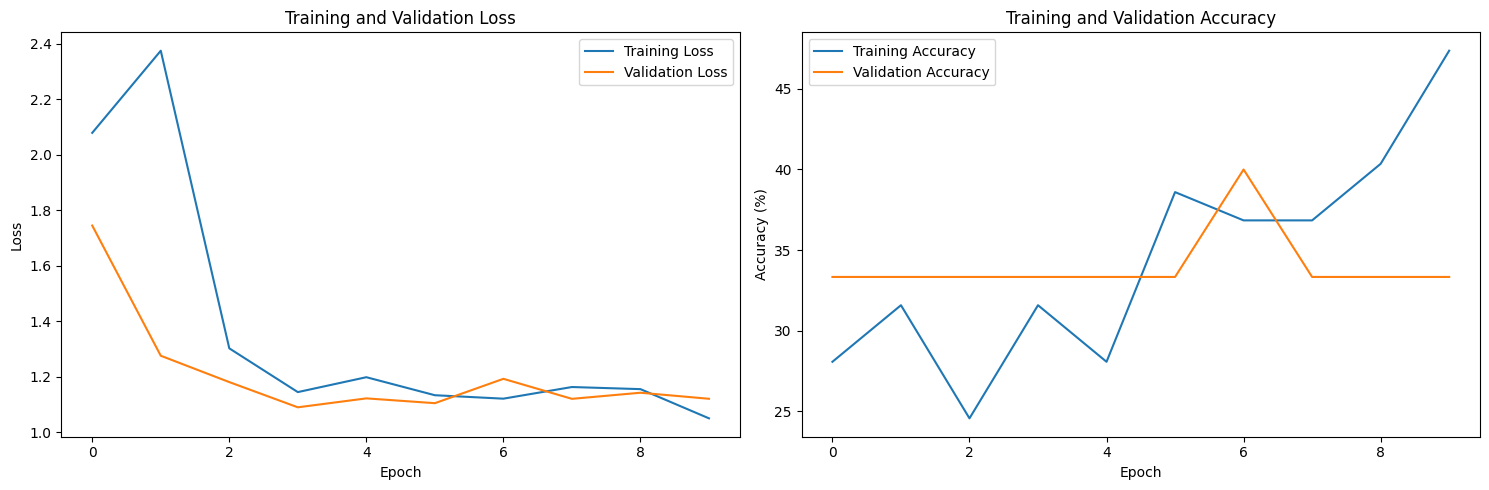

Confusion Matrix:


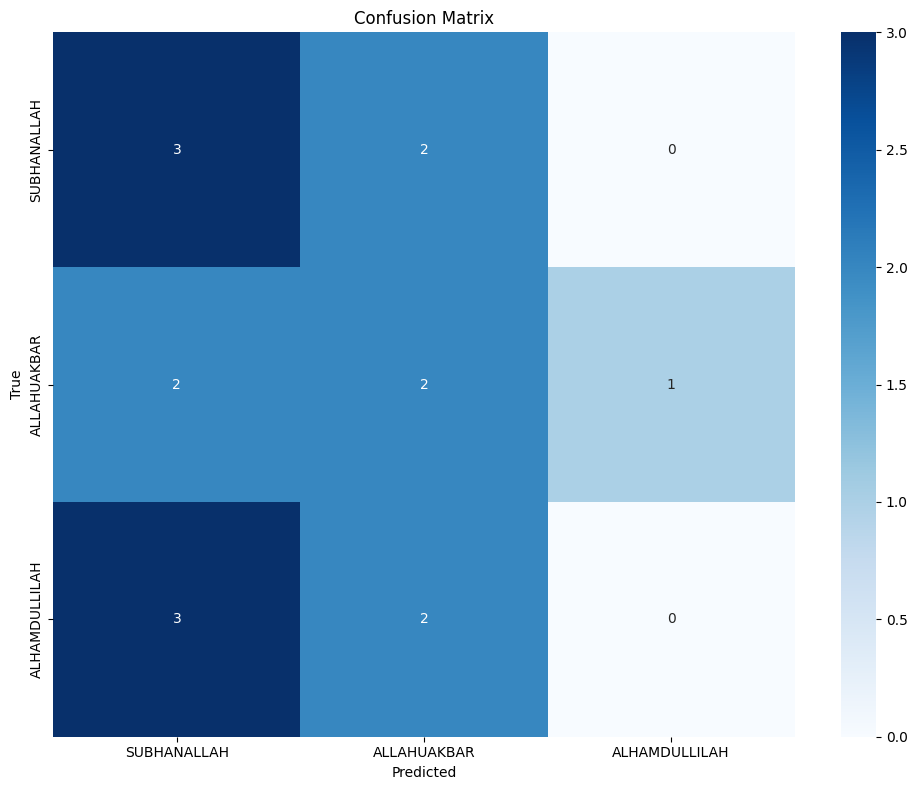

Accuracy for class SUBHANALLAH: 60.00%
Accuracy for class ALLAHUAKBAR: 40.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 11/50
----------
Epoch 11, Batch 5: Loss: 1.073, Acc: 42.50%
Training Loss: 1.1417, Training Acc: 38.60%
Validation Loss: 1.1392, Validation Acc: 33.33%



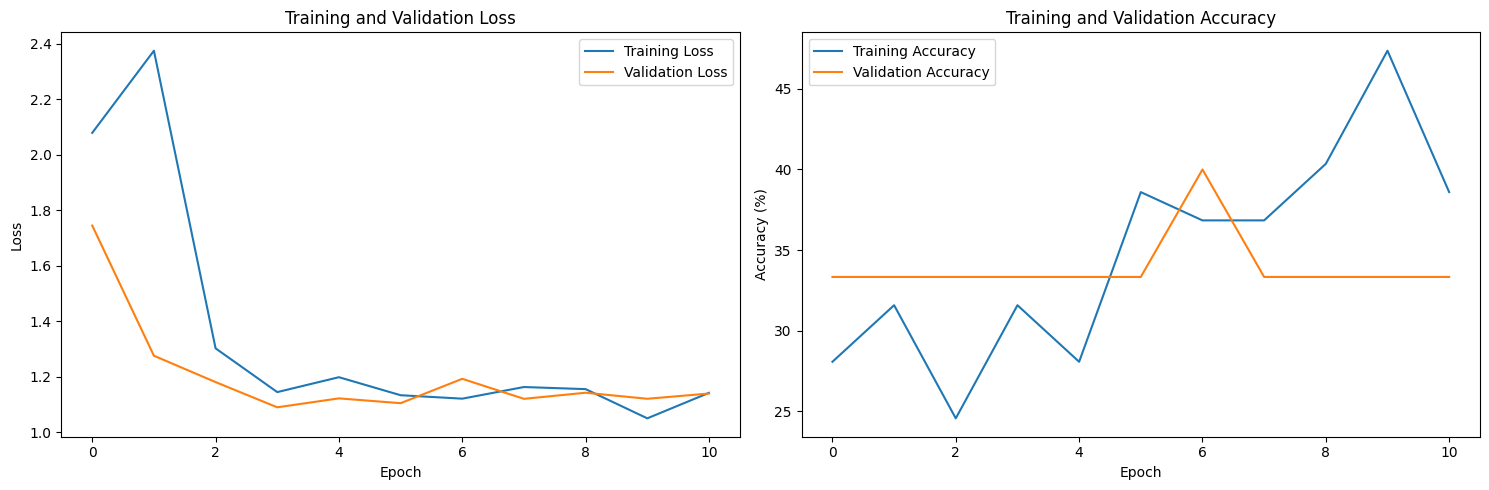

Confusion Matrix:


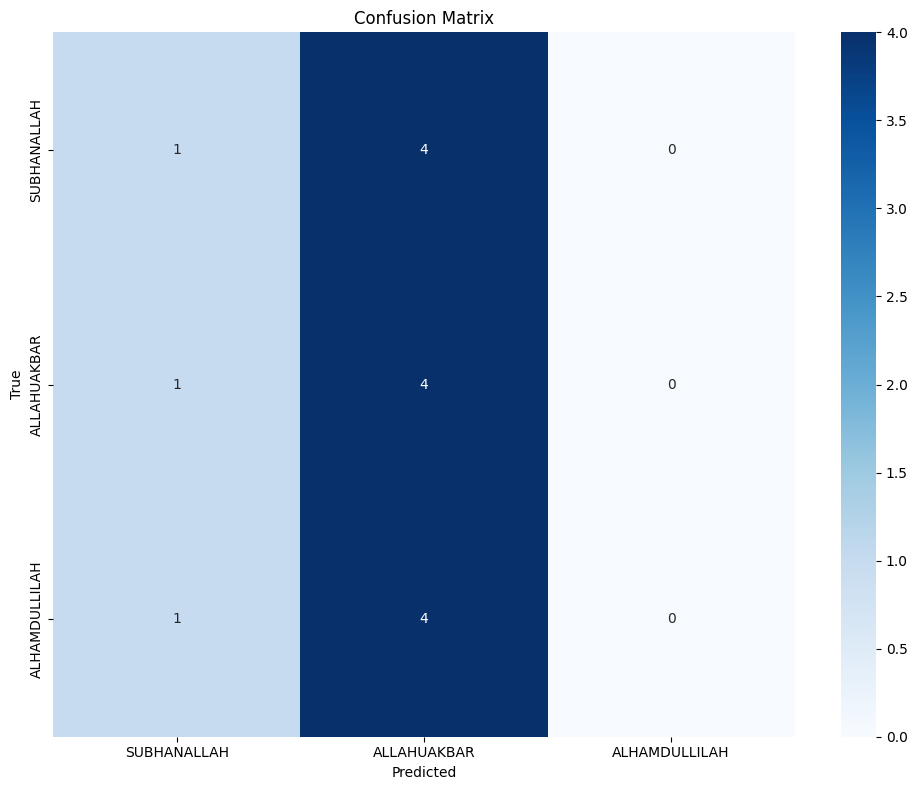

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 80.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 12/50
----------
Epoch 12, Batch 5: Loss: 1.066, Acc: 42.50%
Training Loss: 1.1139, Training Acc: 42.11%
Validation Loss: 1.1401, Validation Acc: 33.33%



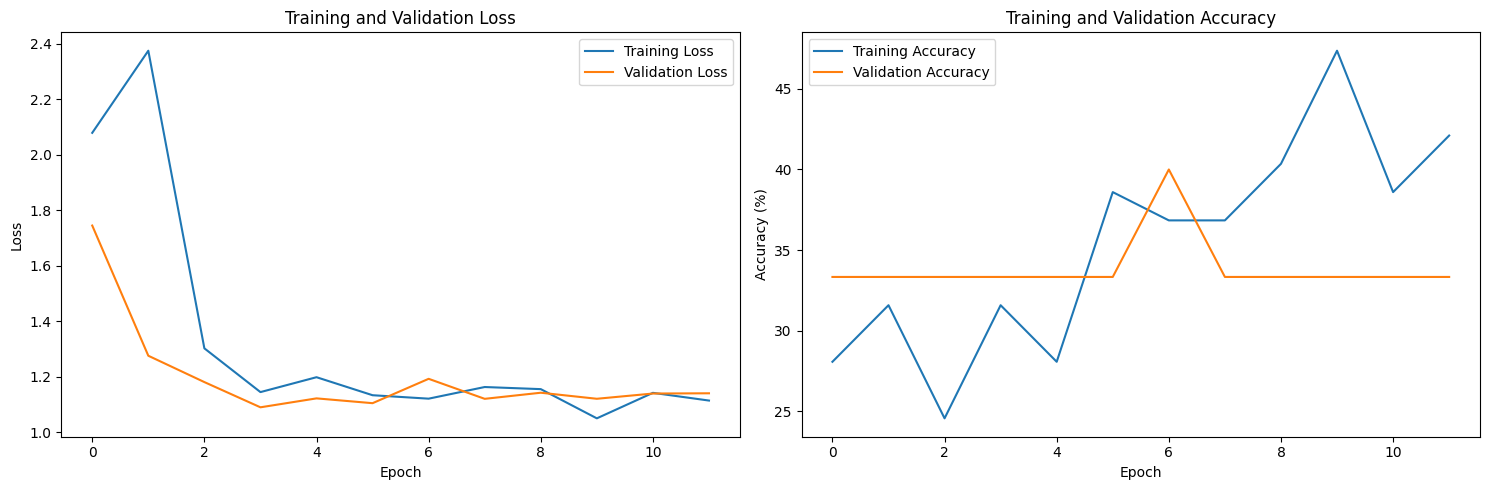

Confusion Matrix:


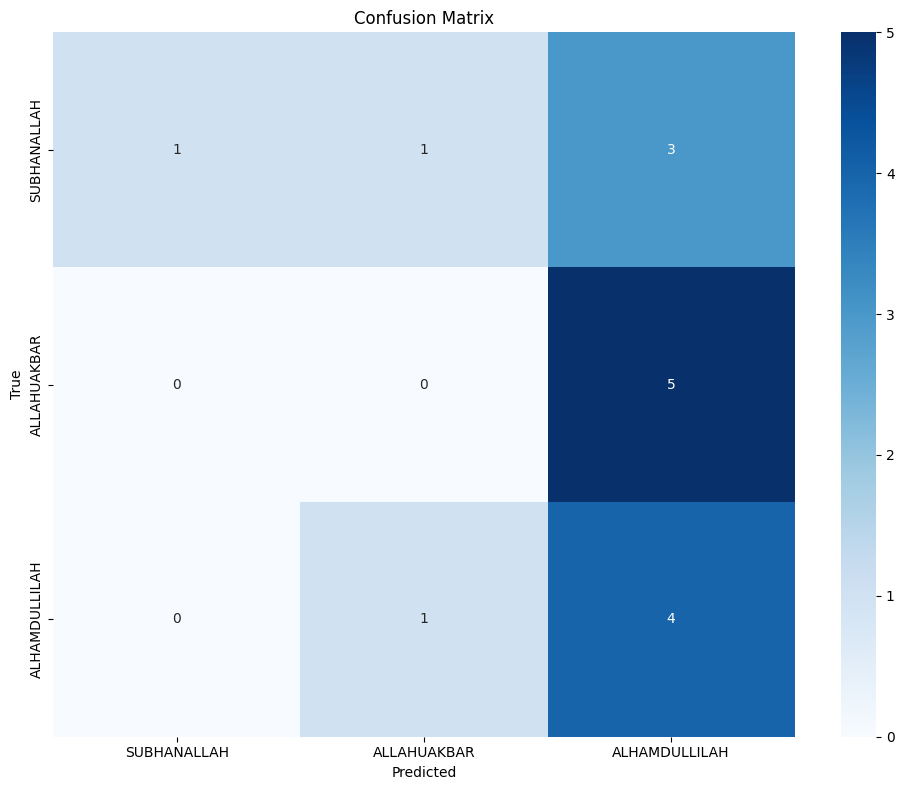

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 80.00%
Training and evaluation completed!
Epoch 13/50
----------
Epoch 13, Batch 5: Loss: 1.100, Acc: 35.00%
Training Loss: 1.1453, Training Acc: 38.60%
Validation Loss: 1.1278, Validation Acc: 33.33%



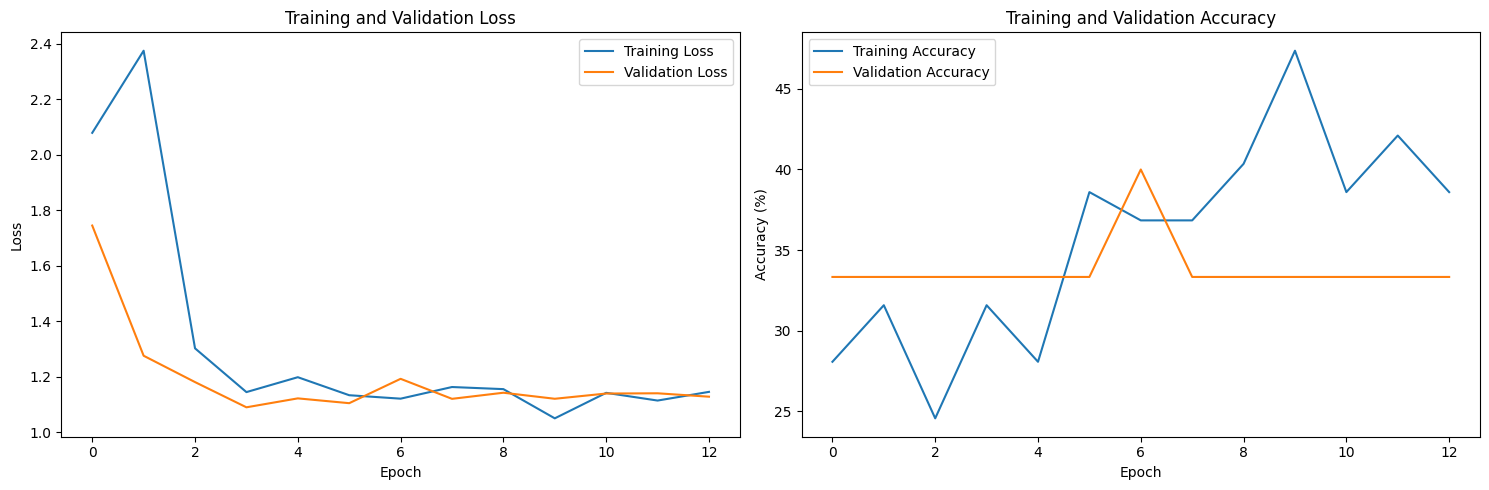

Confusion Matrix:


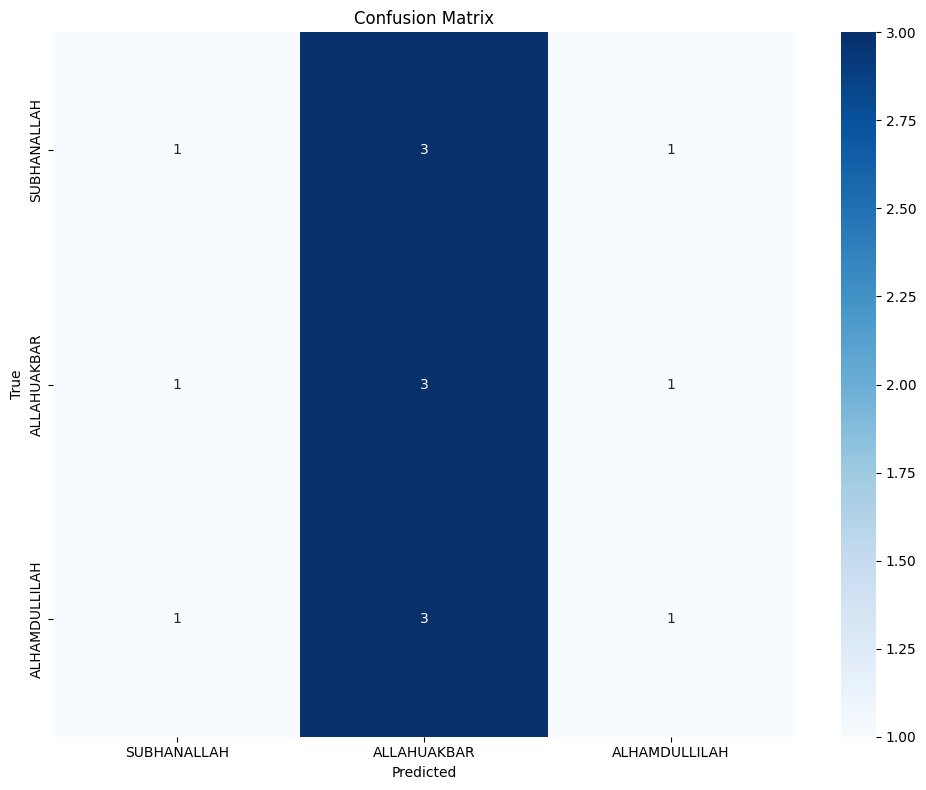

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 60.00%
Accuracy for class ALHAMDULLILAH: 20.00%
Training and evaluation completed!
Epoch 14/50
----------
Epoch 14, Batch 5: Loss: 1.052, Acc: 47.50%
Training Loss: 1.0372, Training Acc: 42.11%
Validation Loss: 1.1165, Validation Acc: 33.33%



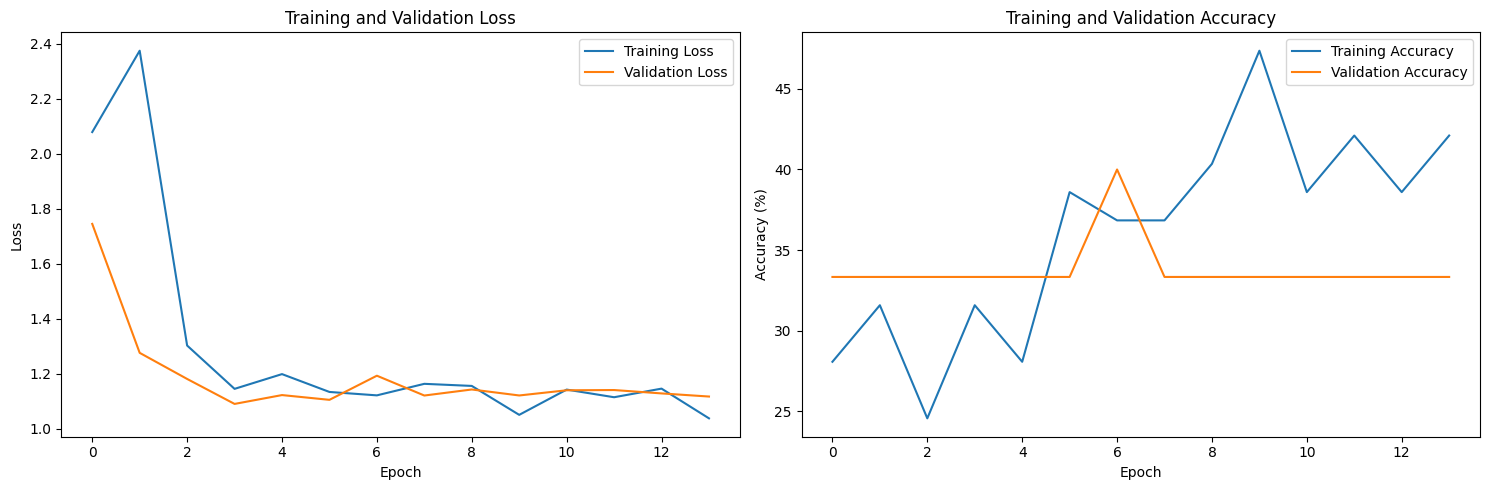

Confusion Matrix:


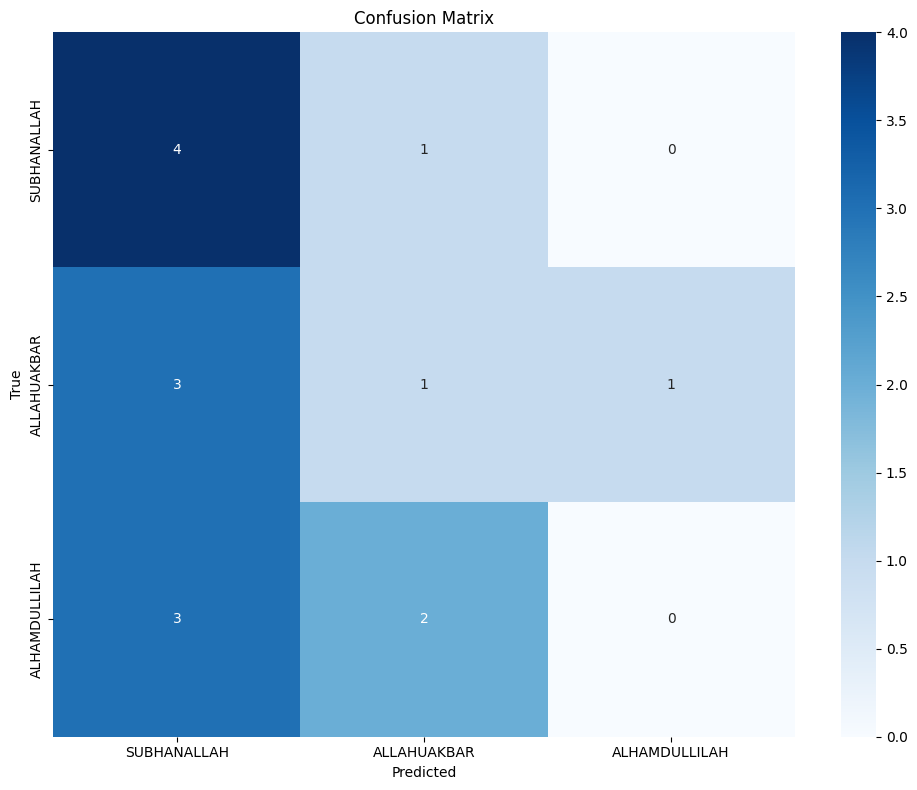

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 20.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 15/50
----------
Epoch 15, Batch 5: Loss: 1.094, Acc: 42.50%
Training Loss: 1.1360, Training Acc: 42.11%
Validation Loss: 1.1188, Validation Acc: 20.00%



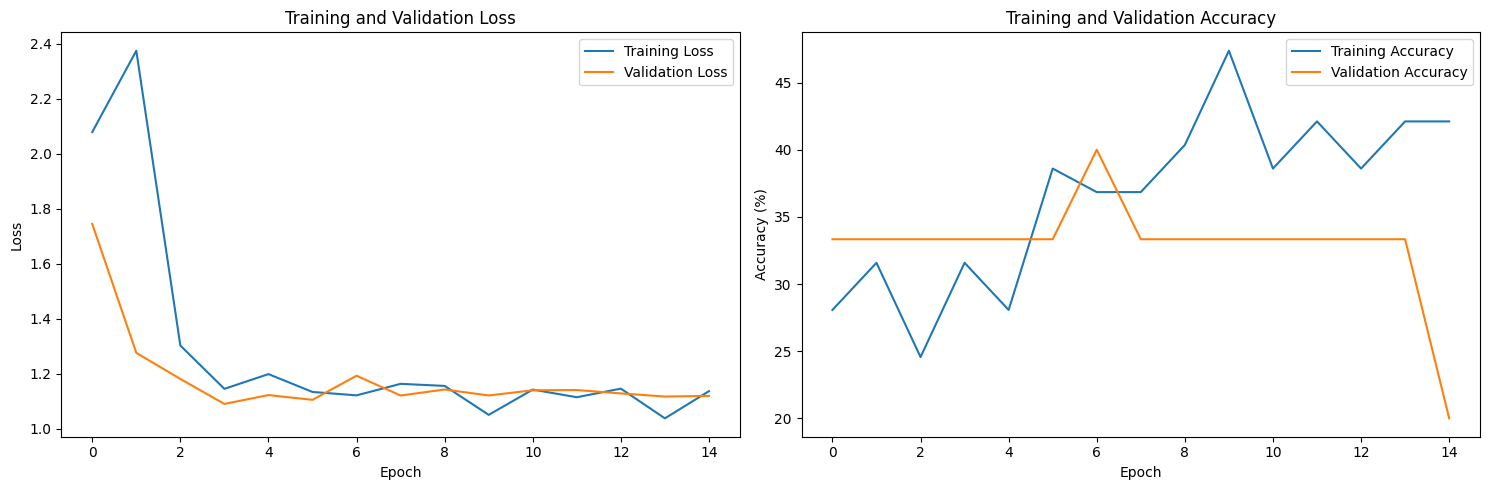

Confusion Matrix:


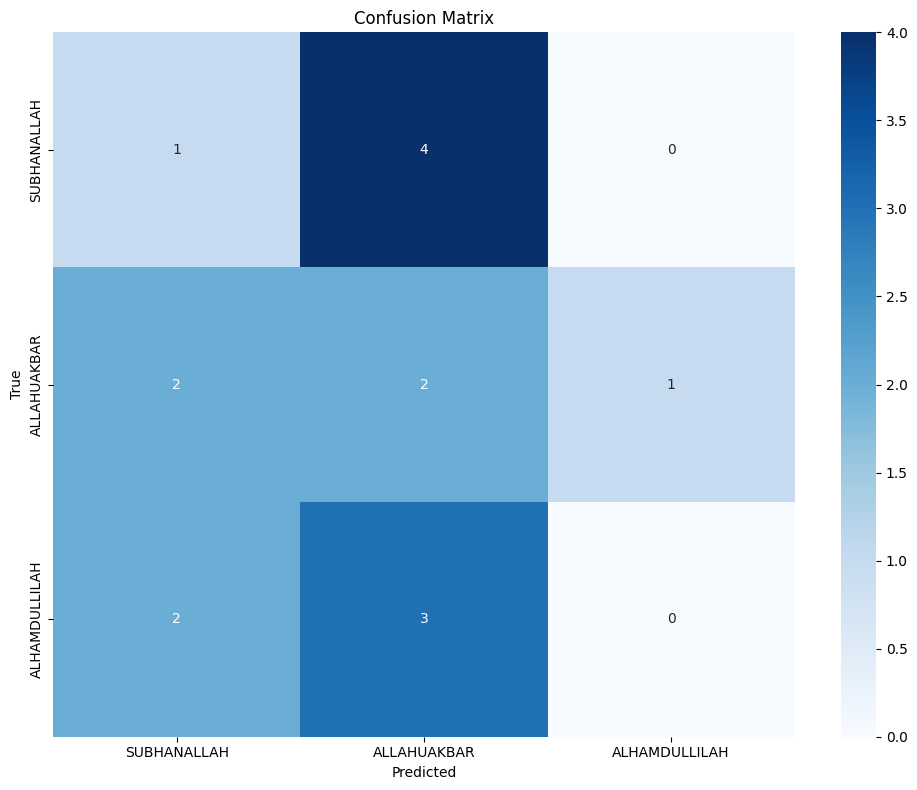

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 40.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 16/50
----------
Epoch 16, Batch 5: Loss: 1.074, Acc: 35.00%
Training Loss: 1.0743, Training Acc: 36.84%
Validation Loss: 1.1243, Validation Acc: 33.33%



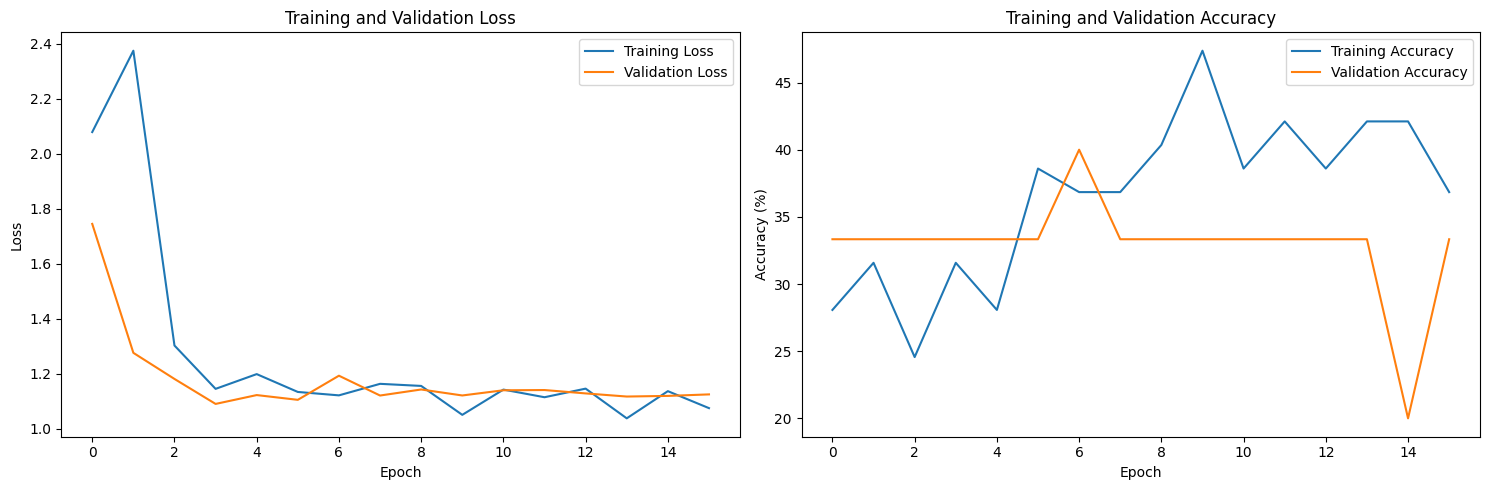

Confusion Matrix:


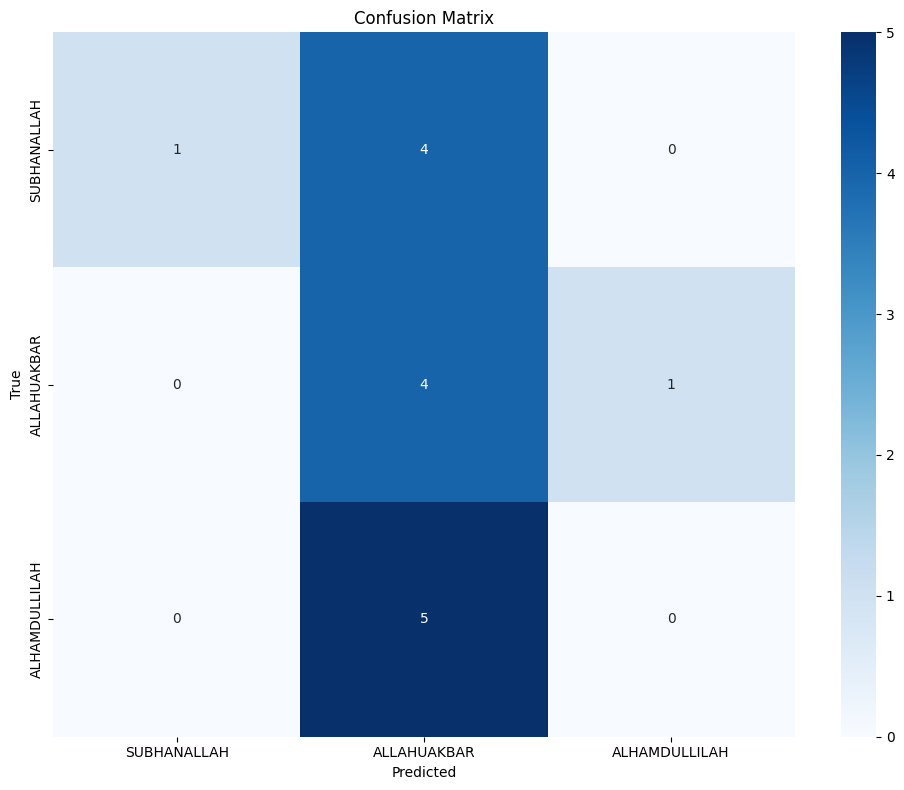

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 80.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 17/50
----------
Epoch 17, Batch 5: Loss: 1.150, Acc: 27.50%
Training Loss: 1.1158, Training Acc: 31.58%
Validation Loss: 1.1263, Validation Acc: 33.33%



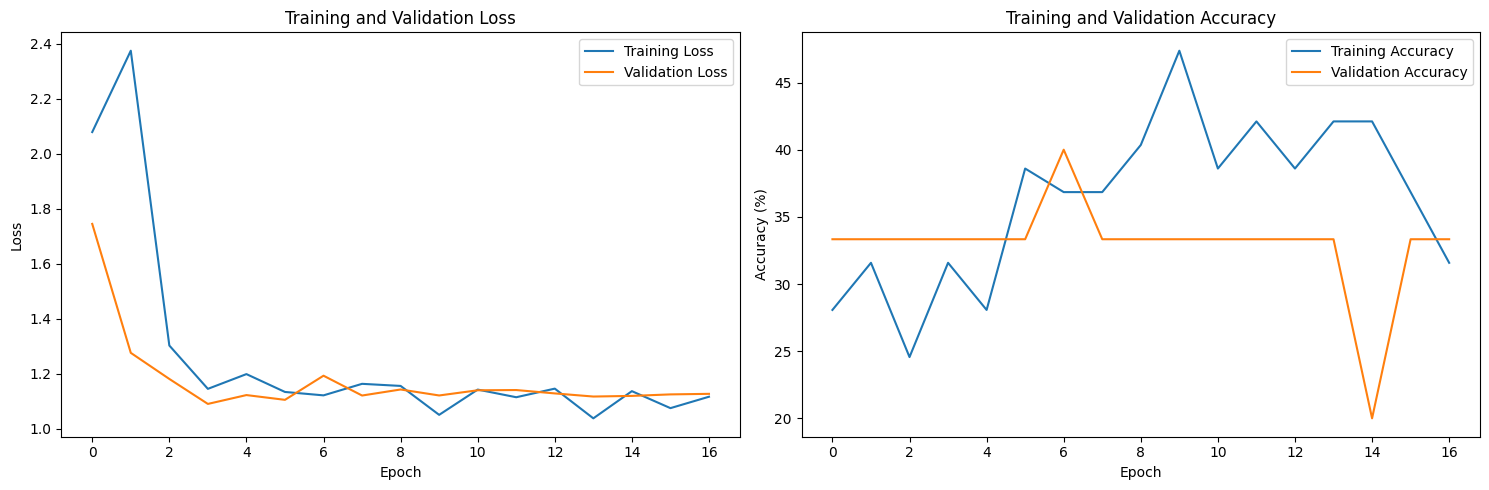

Confusion Matrix:


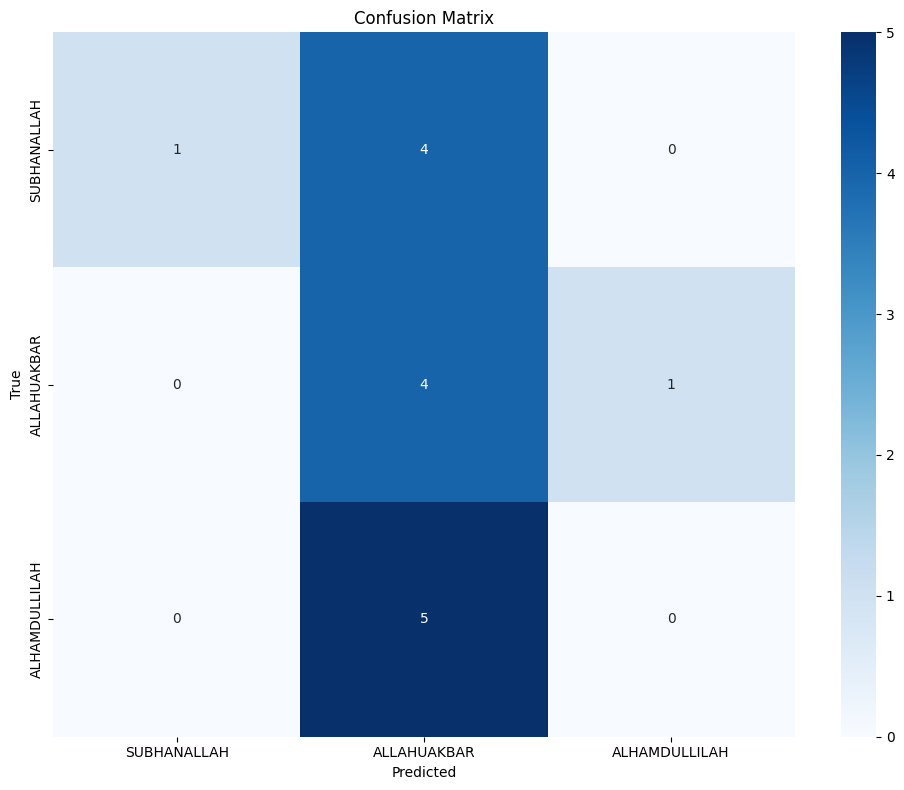

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 80.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 18/50
----------
Epoch 18, Batch 5: Loss: 1.081, Acc: 35.00%
Training Loss: 1.0595, Training Acc: 42.11%
Validation Loss: 1.1313, Validation Acc: 26.67%



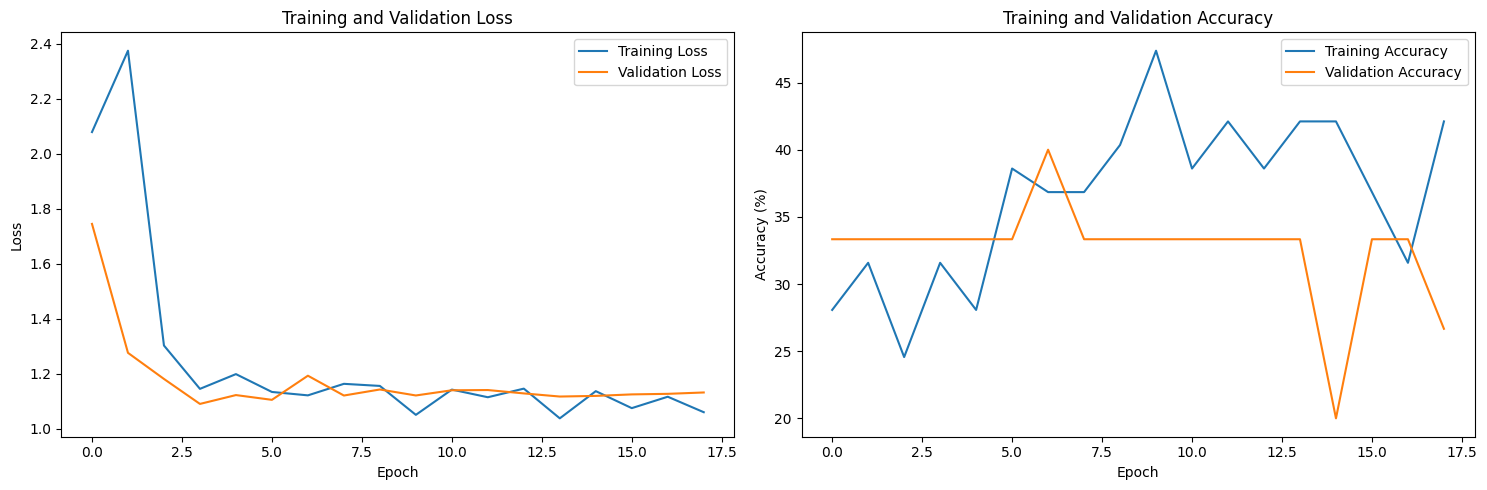

Confusion Matrix:


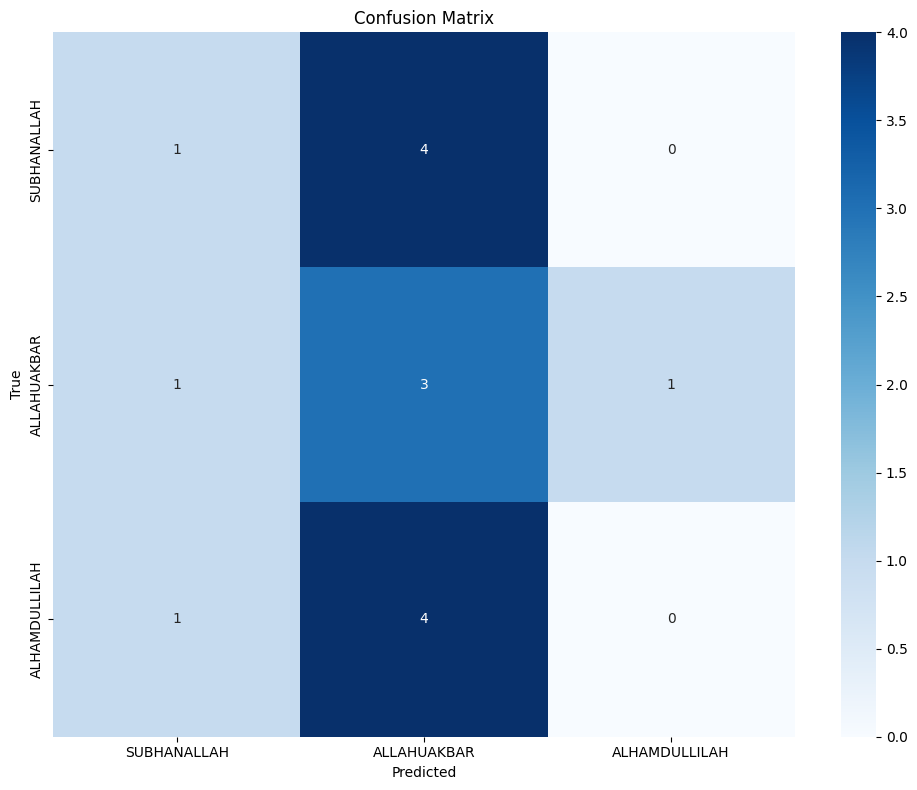

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 60.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 19/50
----------
Epoch 19, Batch 5: Loss: 1.174, Acc: 25.00%
Training Loss: 1.1310, Training Acc: 33.33%
Validation Loss: 1.1237, Validation Acc: 26.67%



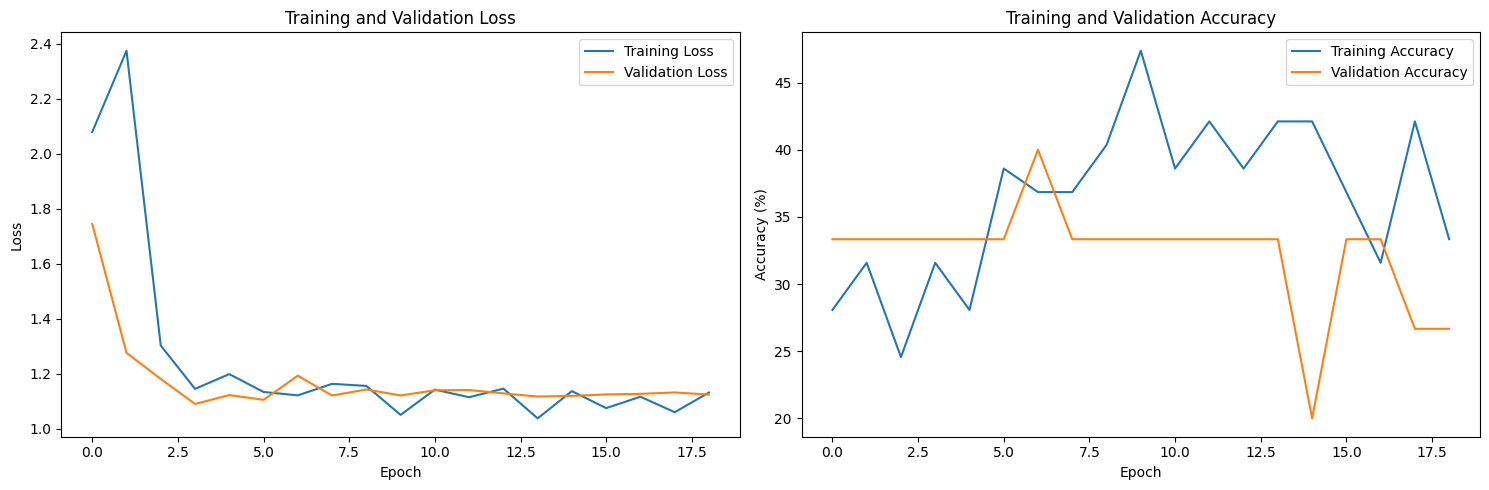

Confusion Matrix:


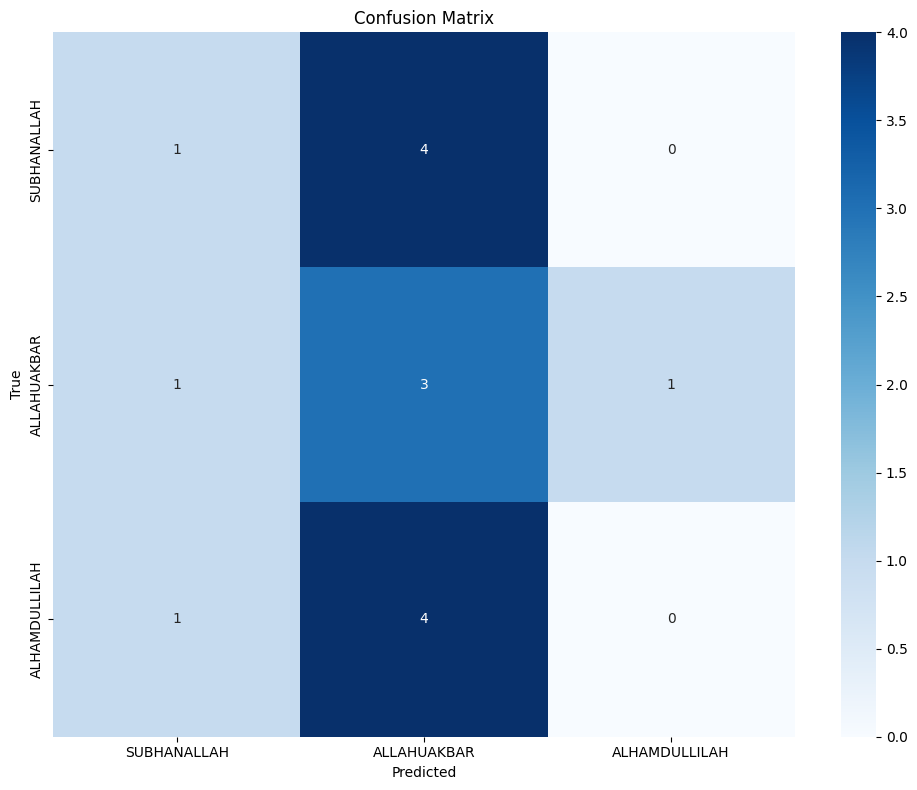

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 60.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 20/50
----------
Epoch 20, Batch 5: Loss: 1.075, Acc: 40.00%
Training Loss: 1.0044, Training Acc: 43.86%
Validation Loss: 1.1022, Validation Acc: 26.67%



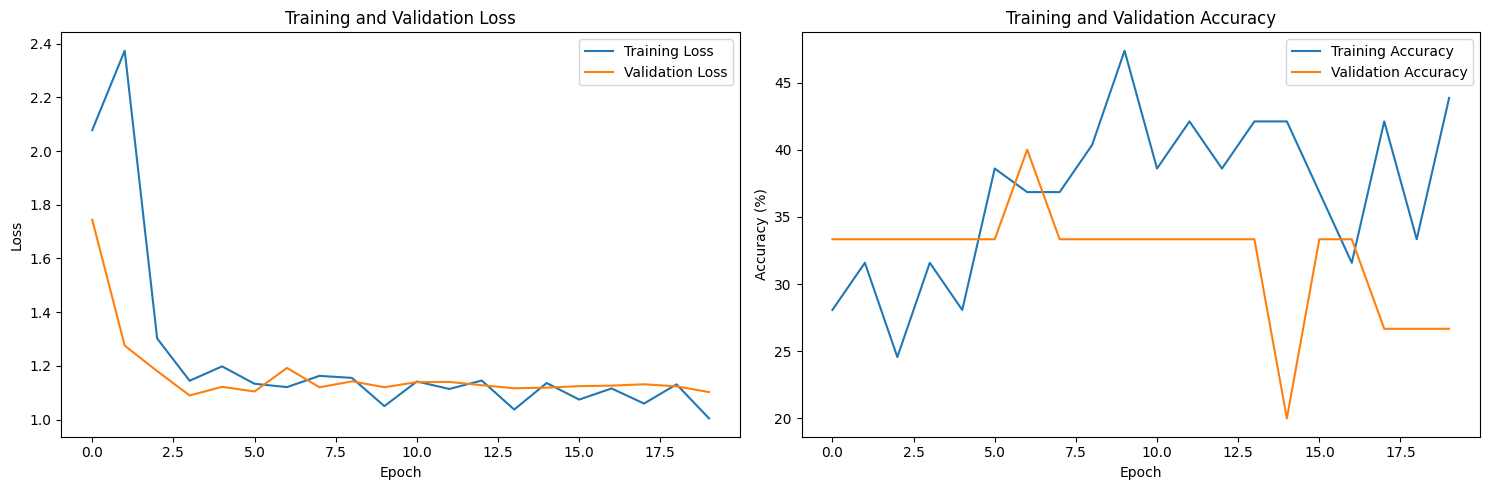

Confusion Matrix:


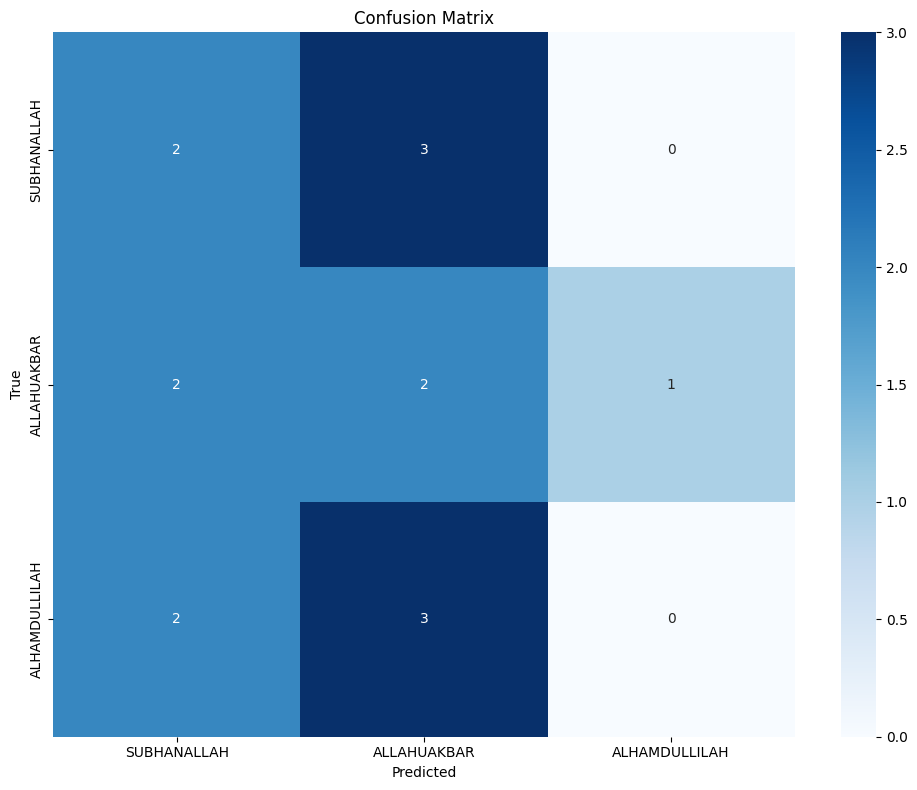

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 40.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 21/50
----------
Epoch 21, Batch 5: Loss: 1.081, Acc: 32.50%
Training Loss: 1.1313, Training Acc: 33.33%
Validation Loss: 1.1170, Validation Acc: 26.67%



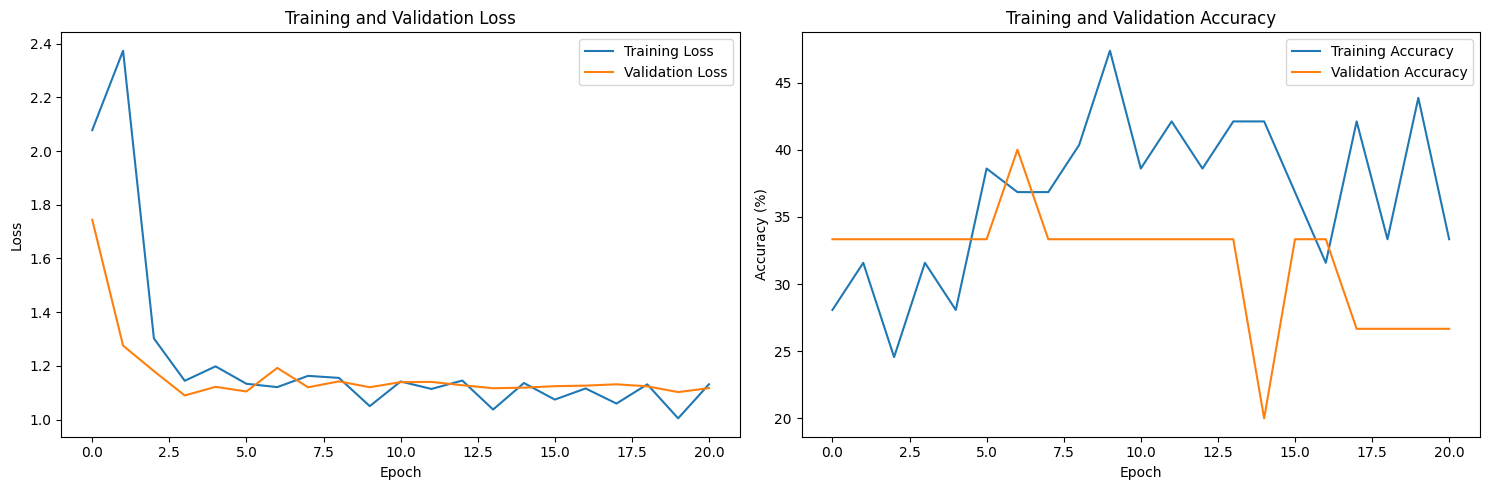

Confusion Matrix:


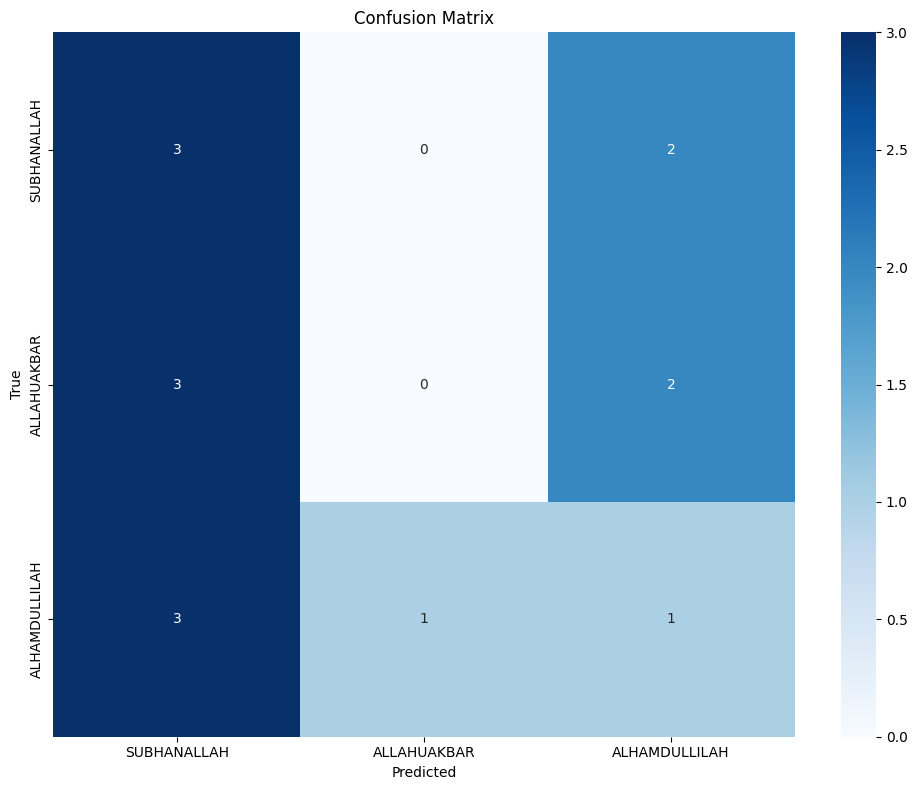

Accuracy for class SUBHANALLAH: 60.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 20.00%
Training and evaluation completed!
Epoch 22/50
----------
Epoch 22, Batch 5: Loss: 1.179, Acc: 37.50%
Training Loss: 1.0368, Training Acc: 40.35%
Validation Loss: 1.2276, Validation Acc: 26.67%



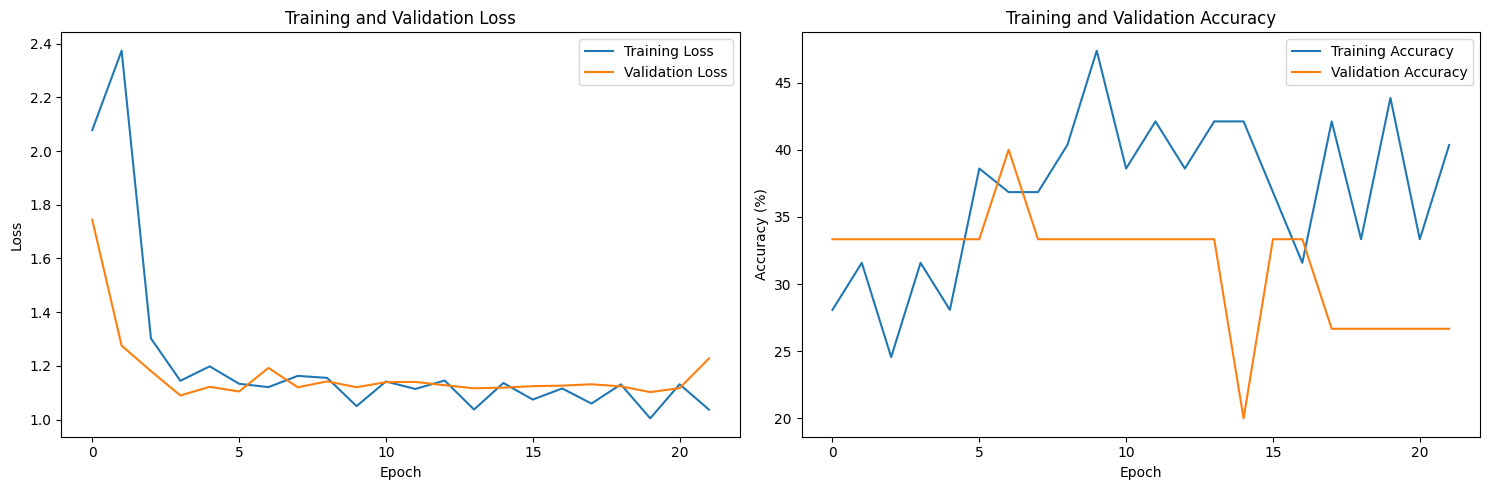

Confusion Matrix:


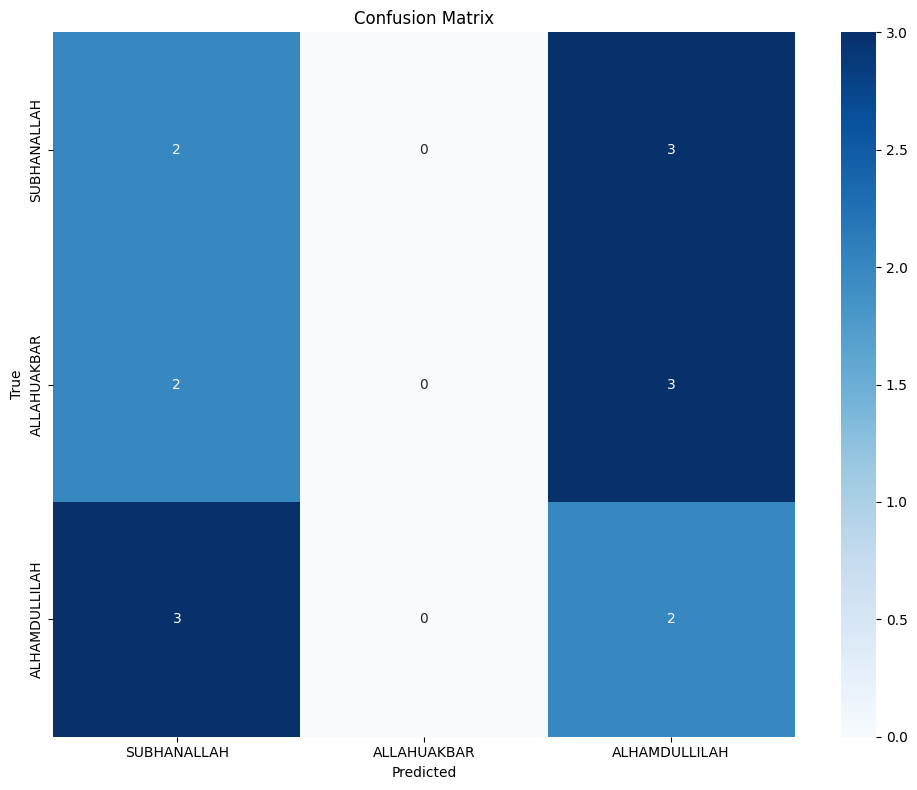

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 40.00%
Training and evaluation completed!
Epoch 23/50
----------
Epoch 23, Batch 5: Loss: 1.187, Acc: 40.00%
Training Loss: 1.1685, Training Acc: 33.33%
Validation Loss: 1.1496, Validation Acc: 26.67%



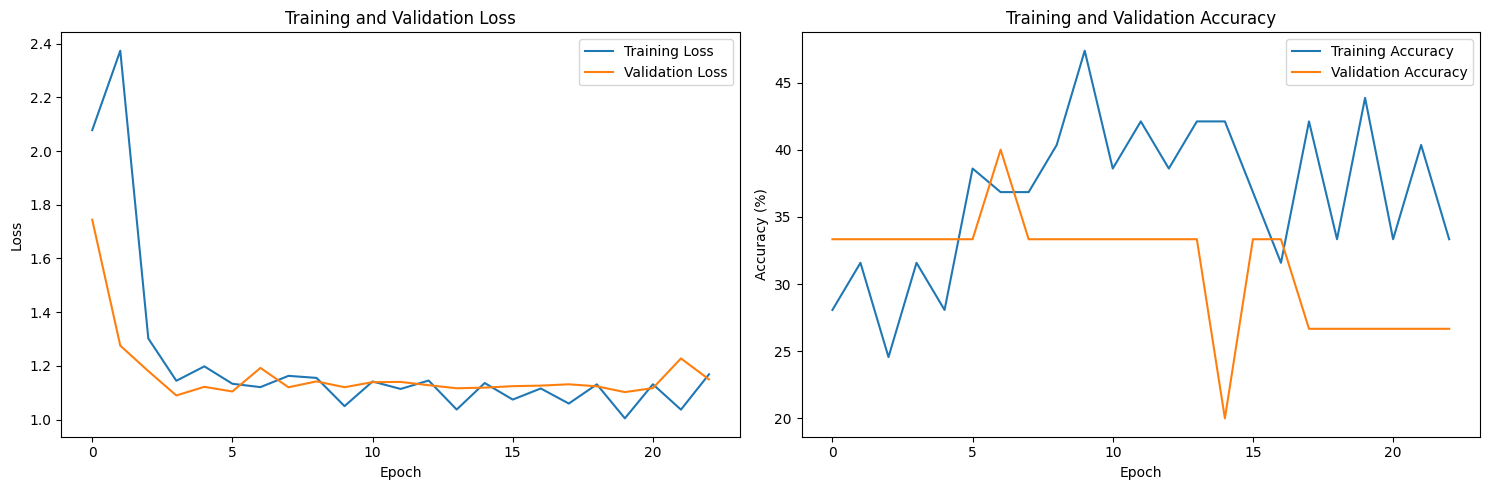

Confusion Matrix:


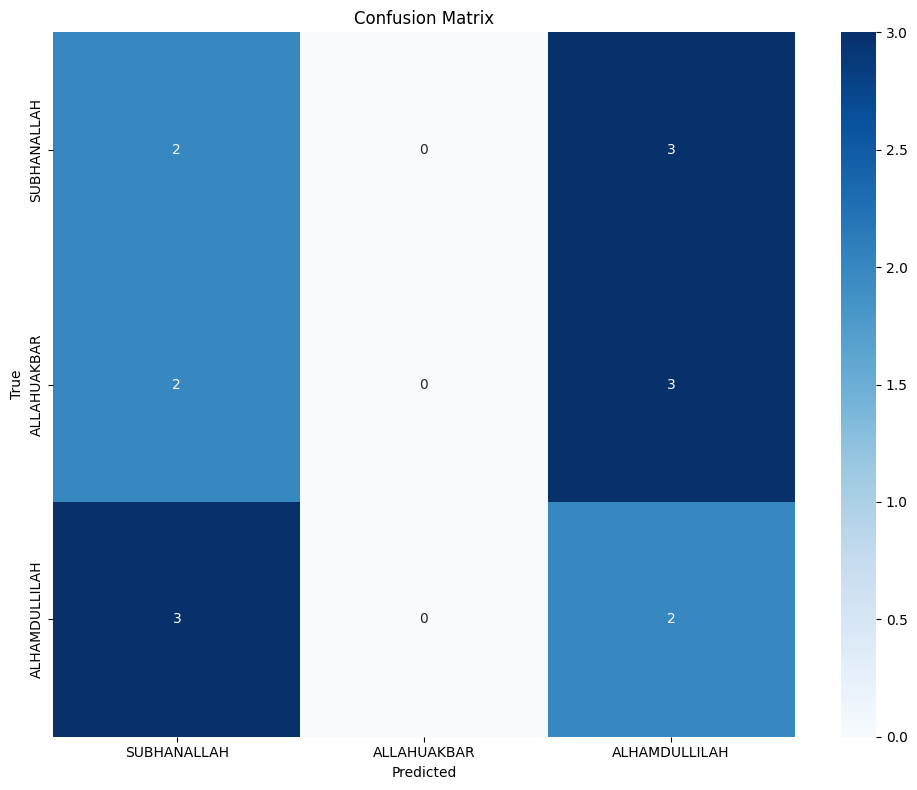

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 40.00%
Training and evaluation completed!
Epoch 24/50
----------
Epoch 24, Batch 5: Loss: 1.092, Acc: 30.00%
Training Loss: 1.1030, Training Acc: 29.82%
Validation Loss: 1.1337, Validation Acc: 26.67%



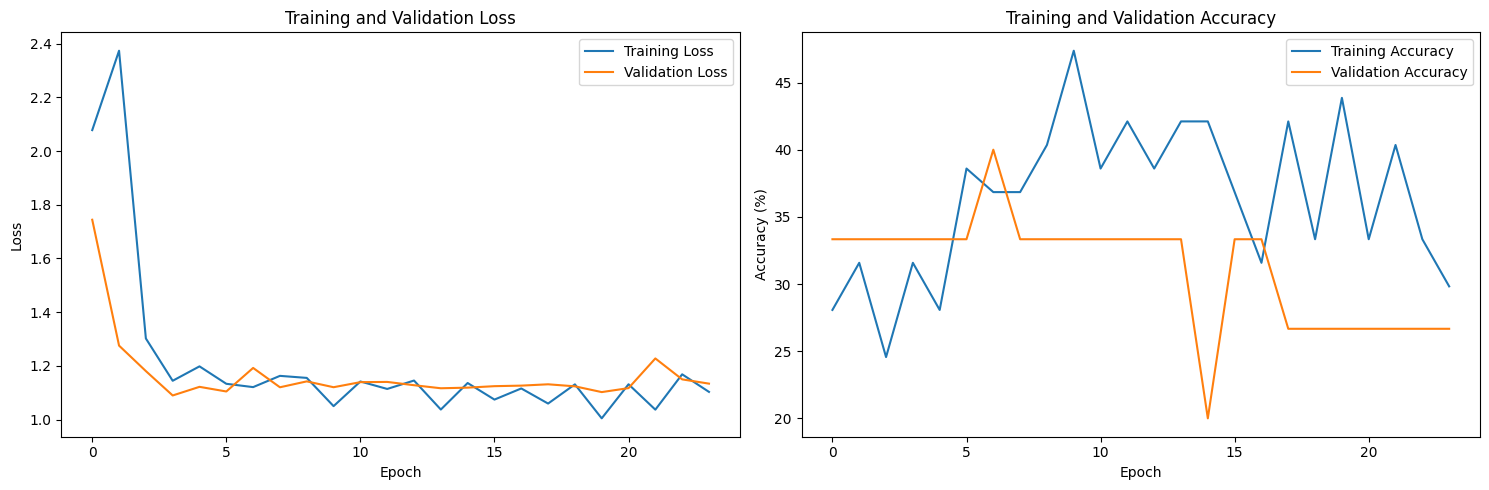

Confusion Matrix:


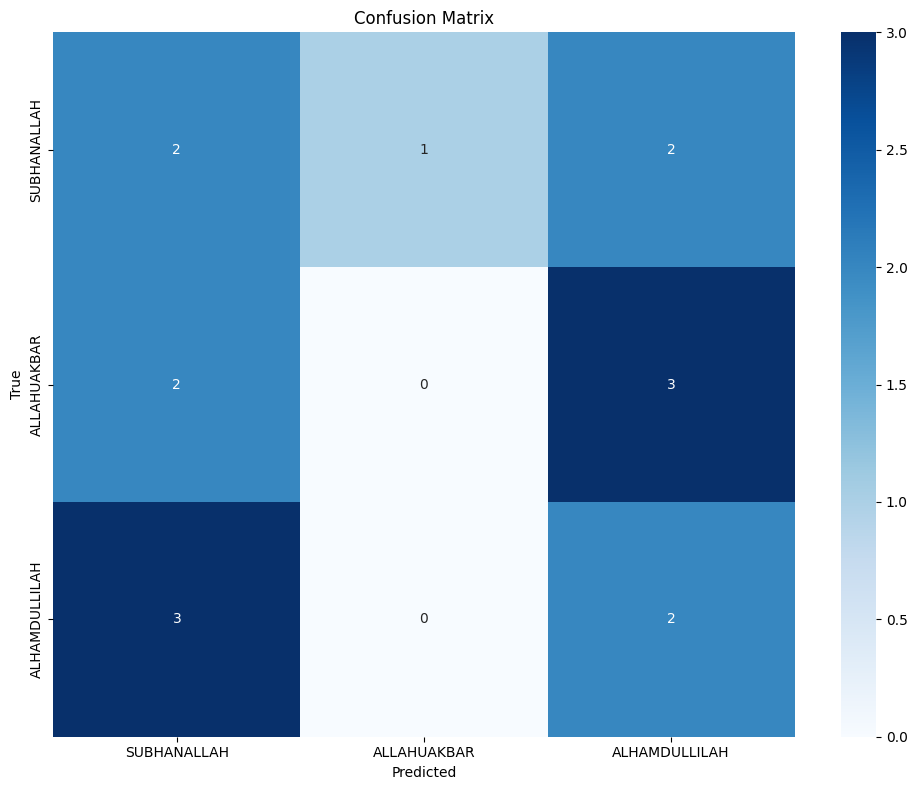

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 40.00%
Training and evaluation completed!
Epoch 25/50
----------
Epoch 25, Batch 5: Loss: 1.068, Acc: 42.50%
Training Loss: 1.0691, Training Acc: 38.60%
Validation Loss: 1.1308, Validation Acc: 33.33%



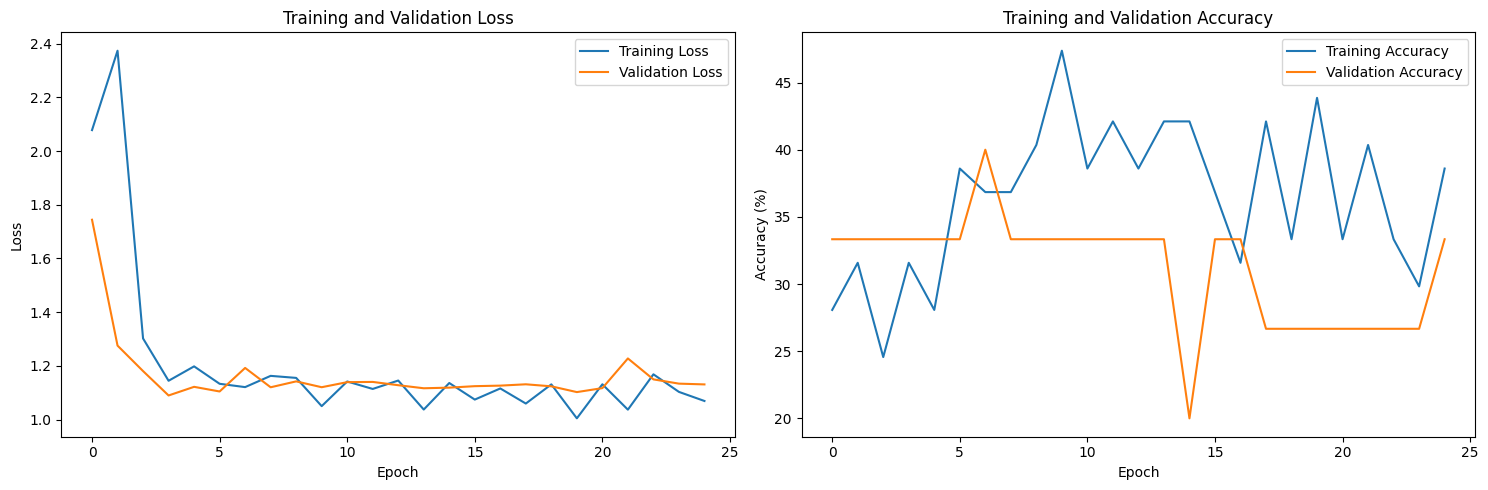

Confusion Matrix:


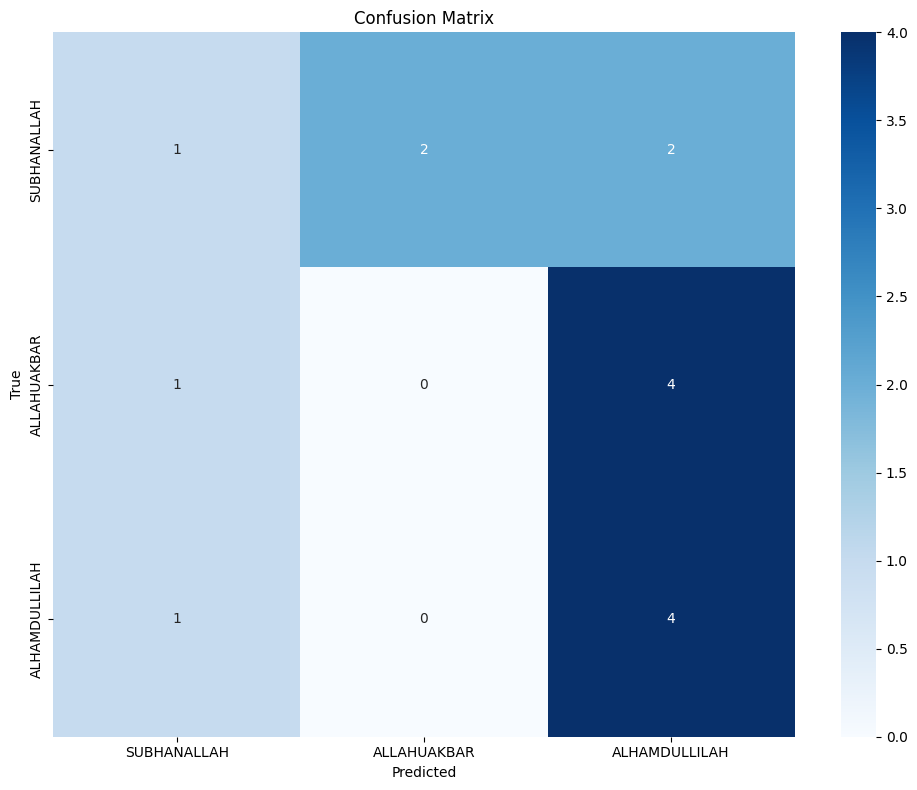

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 80.00%
Training and evaluation completed!
Epoch 26/50
----------
Epoch 26, Batch 5: Loss: 1.093, Acc: 32.50%
Training Loss: 1.2012, Training Acc: 31.58%
Validation Loss: 1.1249, Validation Acc: 40.00%



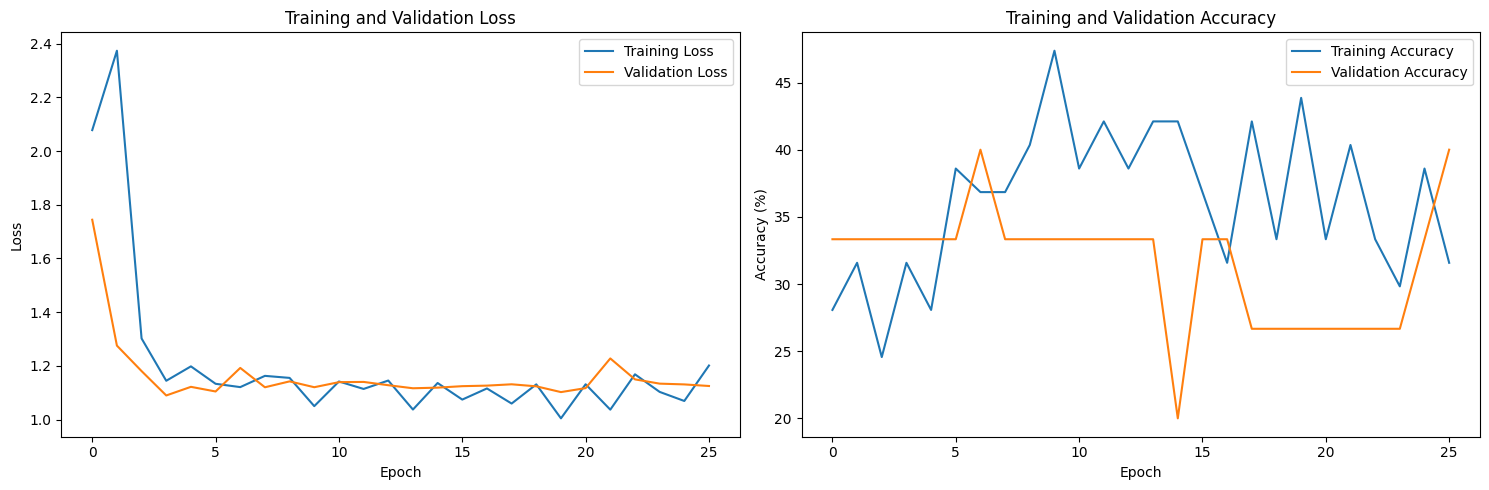

Confusion Matrix:


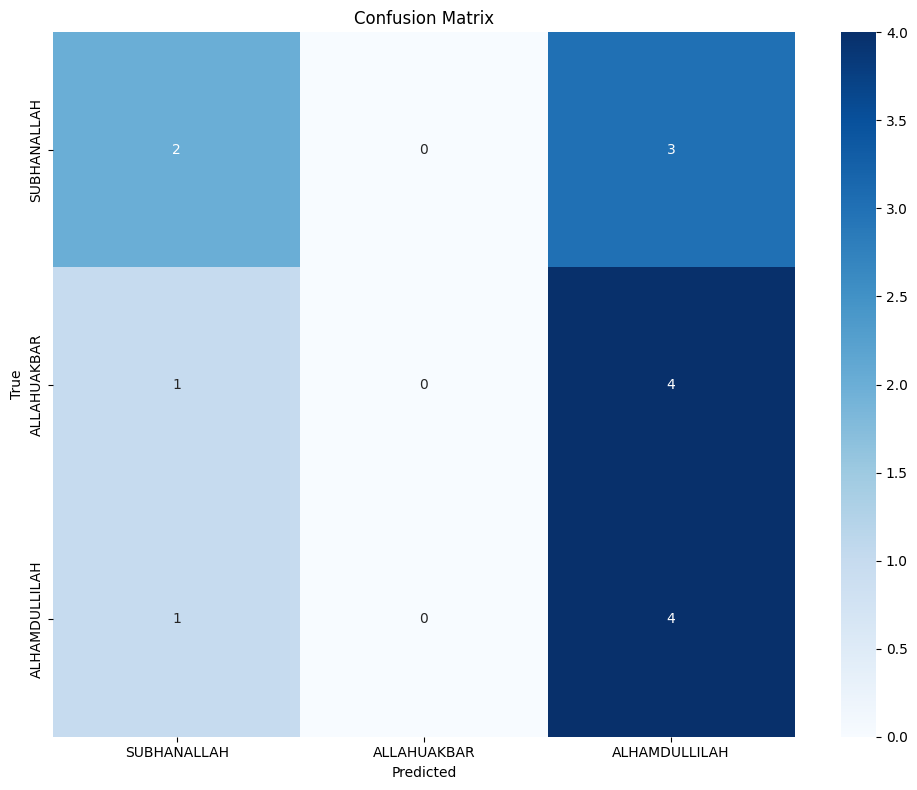

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 80.00%
Training and evaluation completed!
Epoch 27/50
----------
Epoch 27, Batch 5: Loss: 1.076, Acc: 35.00%
Training Loss: 1.2011, Training Acc: 31.58%
Validation Loss: 1.0669, Validation Acc: 40.00%



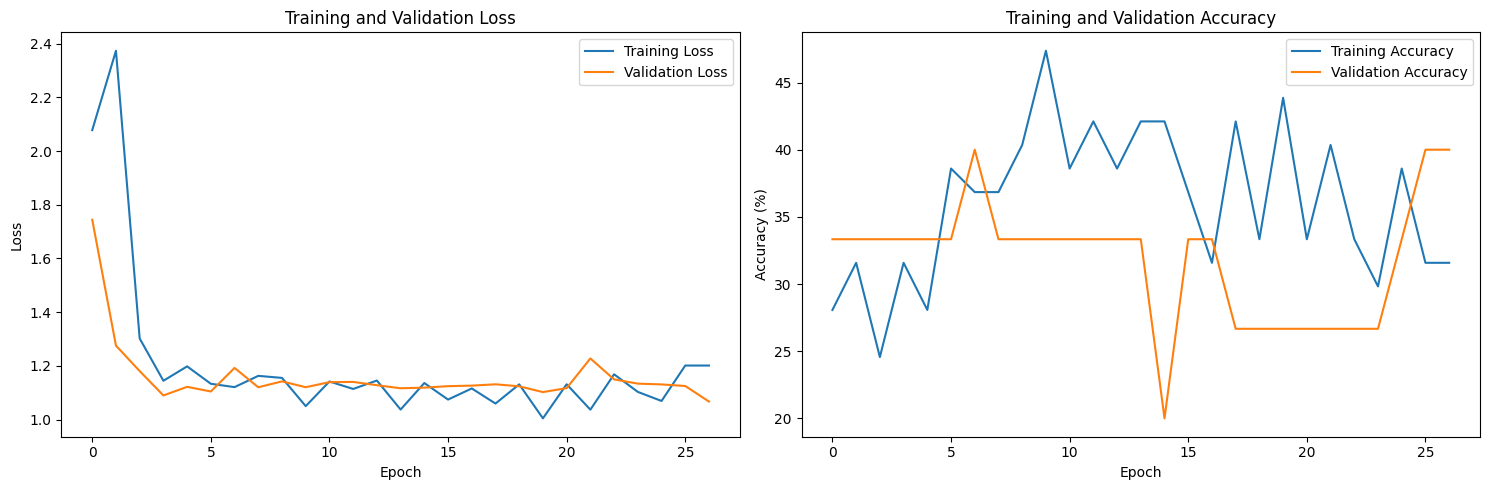

Confusion Matrix:


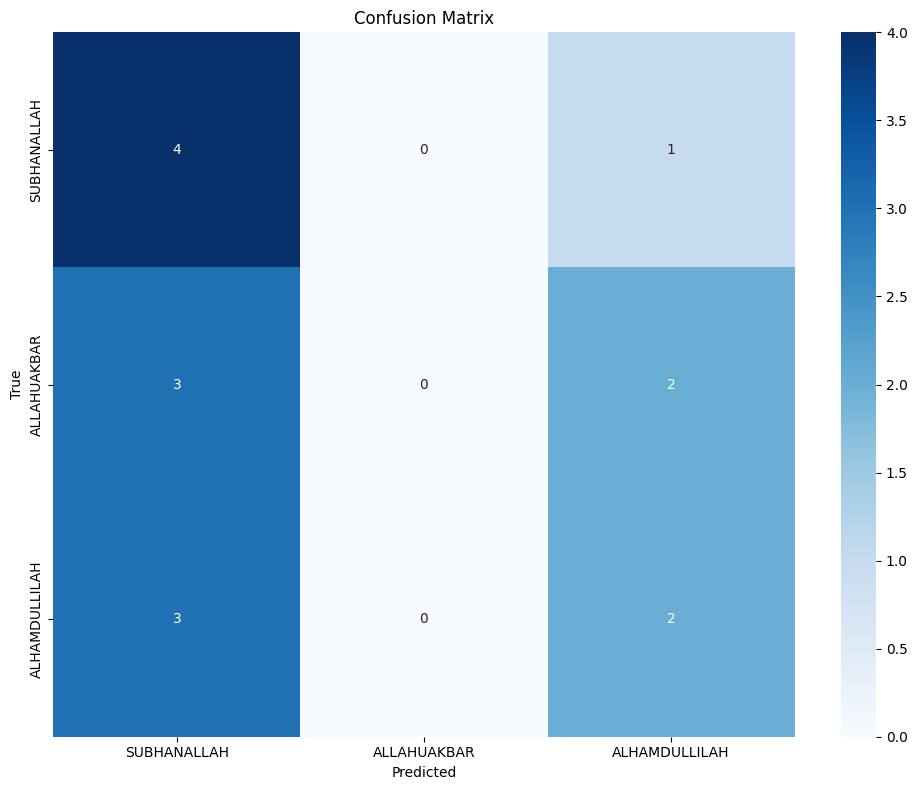

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 40.00%
Training and evaluation completed!
Epoch 28/50
----------
Epoch 28, Batch 5: Loss: 1.101, Acc: 40.00%
Training Loss: 1.1001, Training Acc: 42.11%
Validation Loss: 1.0655, Validation Acc: 33.33%



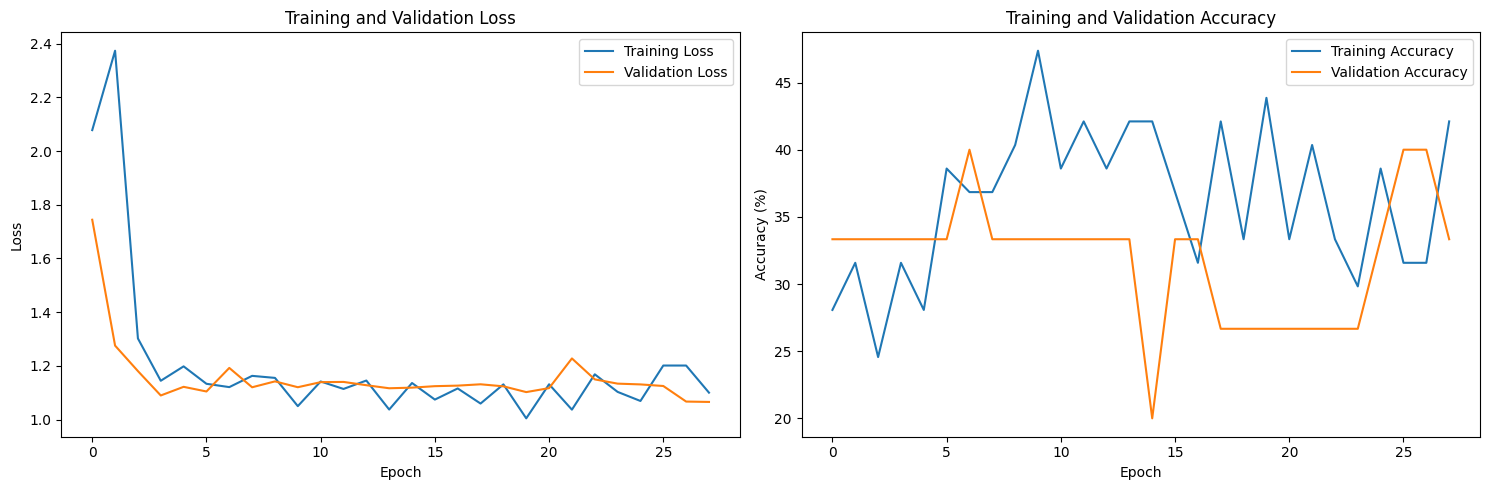

Confusion Matrix:


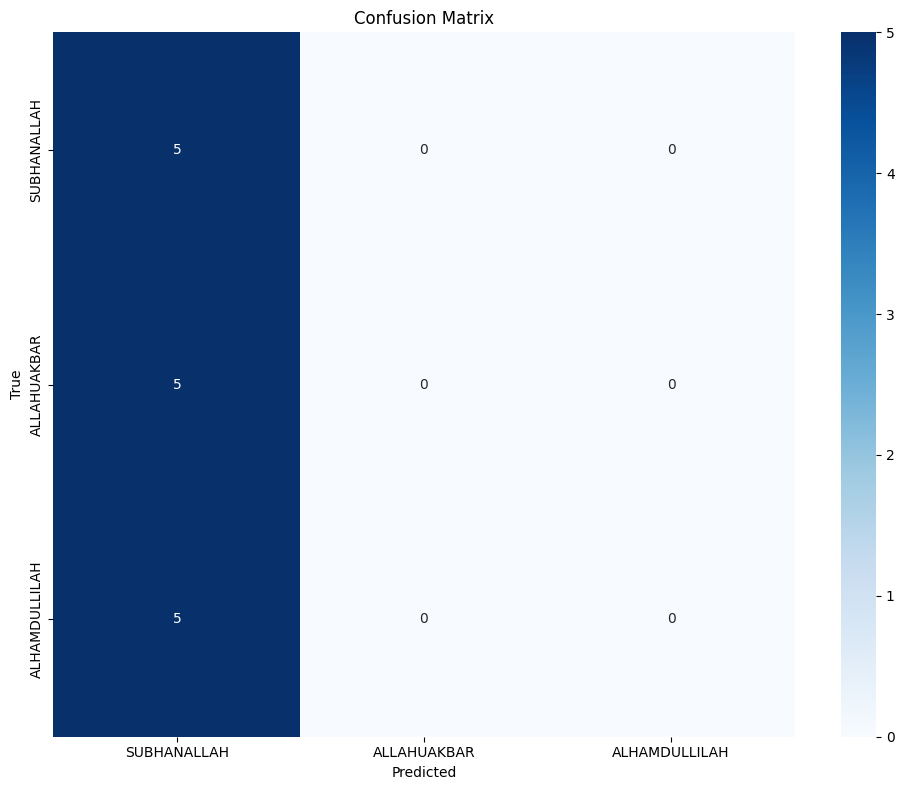

Accuracy for class SUBHANALLAH: 100.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 29/50
----------
Epoch 29, Batch 5: Loss: 1.056, Acc: 40.00%
Training Loss: 1.1209, Training Acc: 35.09%
Validation Loss: 1.0871, Validation Acc: 33.33%



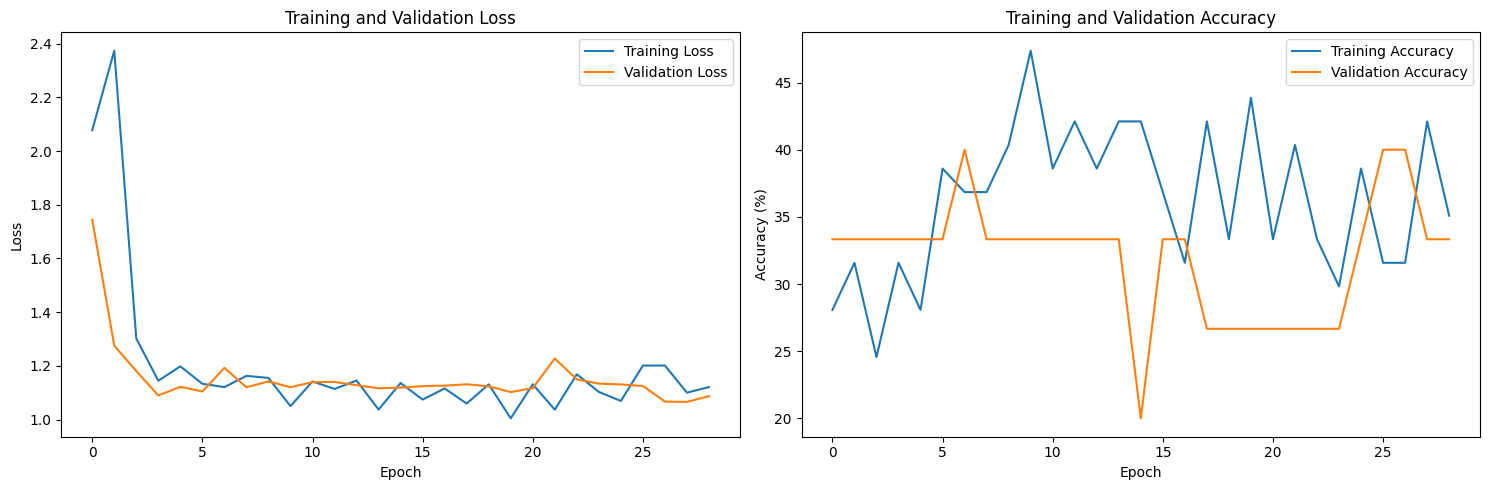

Confusion Matrix:


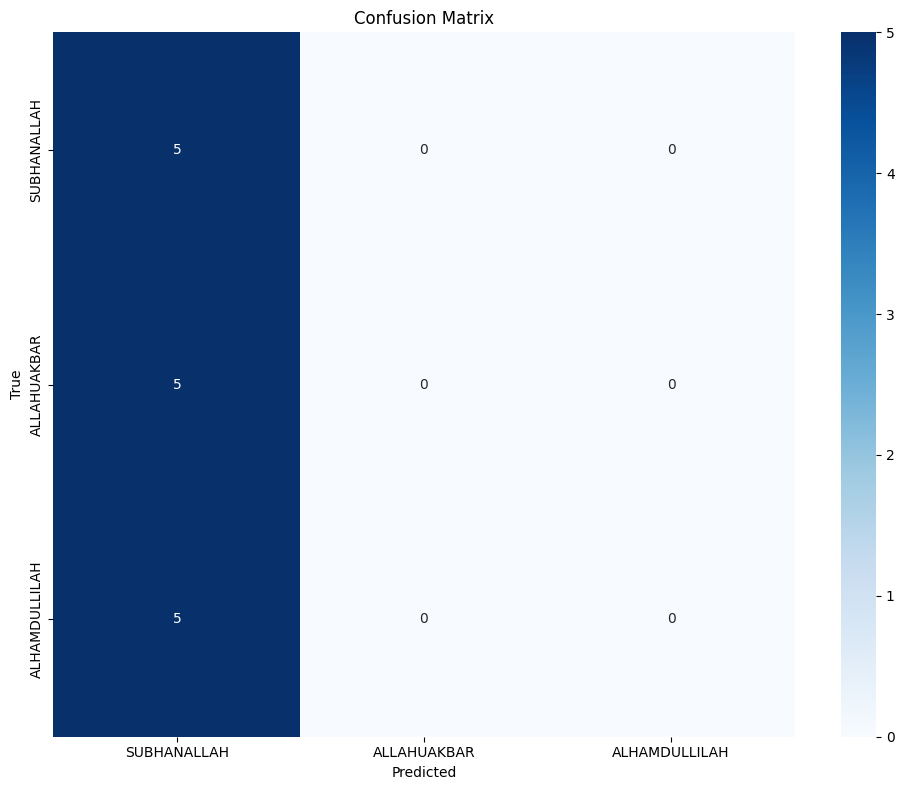

Accuracy for class SUBHANALLAH: 100.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 0.00%
Training and evaluation completed!
Epoch 30/50
----------
Epoch 30, Batch 5: Loss: 1.142, Acc: 25.00%
Training Loss: 1.0919, Training Acc: 33.33%
Validation Loss: 1.0942, Validation Acc: 26.67%



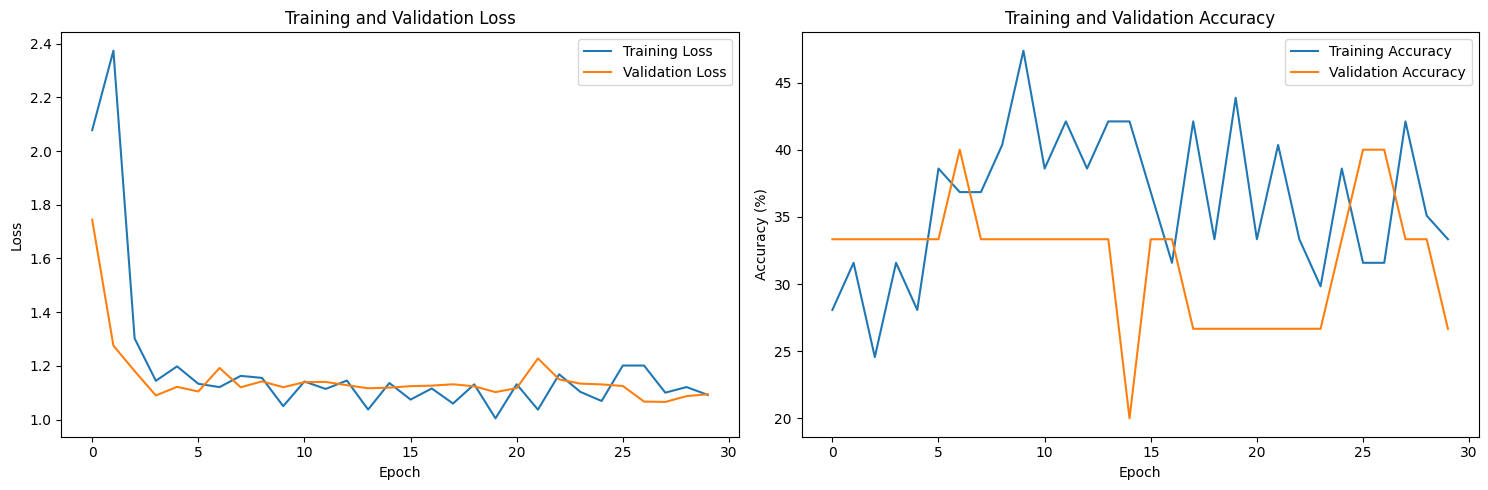

Confusion Matrix:


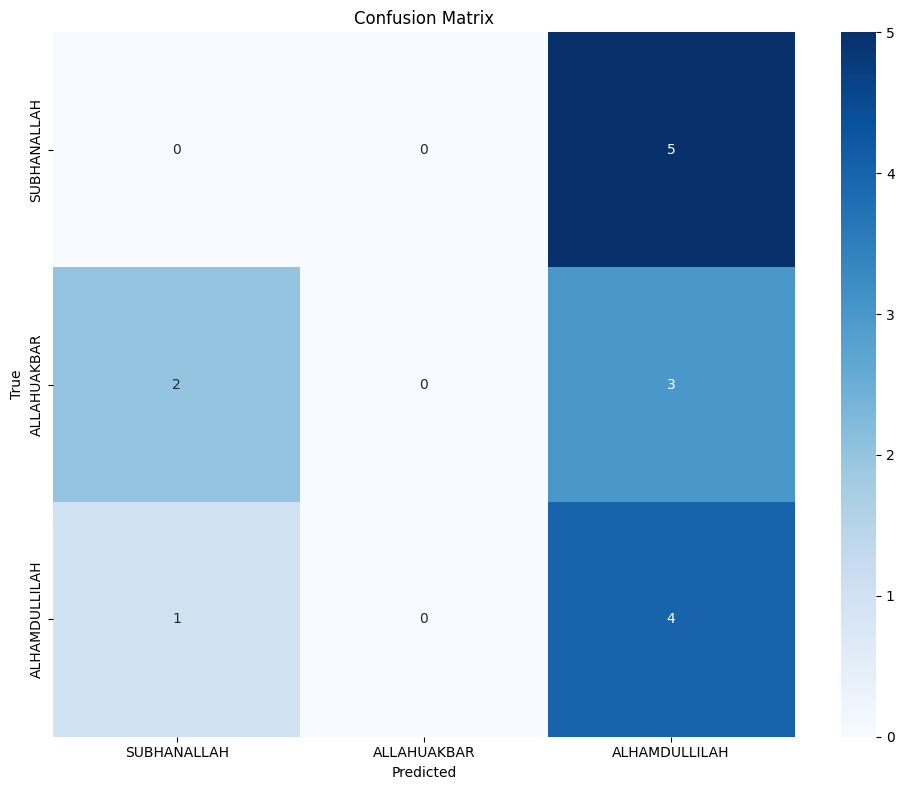

Accuracy for class SUBHANALLAH: 0.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 80.00%
Training and evaluation completed!
Epoch 31/50
----------
Epoch 31, Batch 5: Loss: 1.101, Acc: 35.00%
Training Loss: 1.1109, Training Acc: 36.84%
Validation Loss: 1.0968, Validation Acc: 33.33%



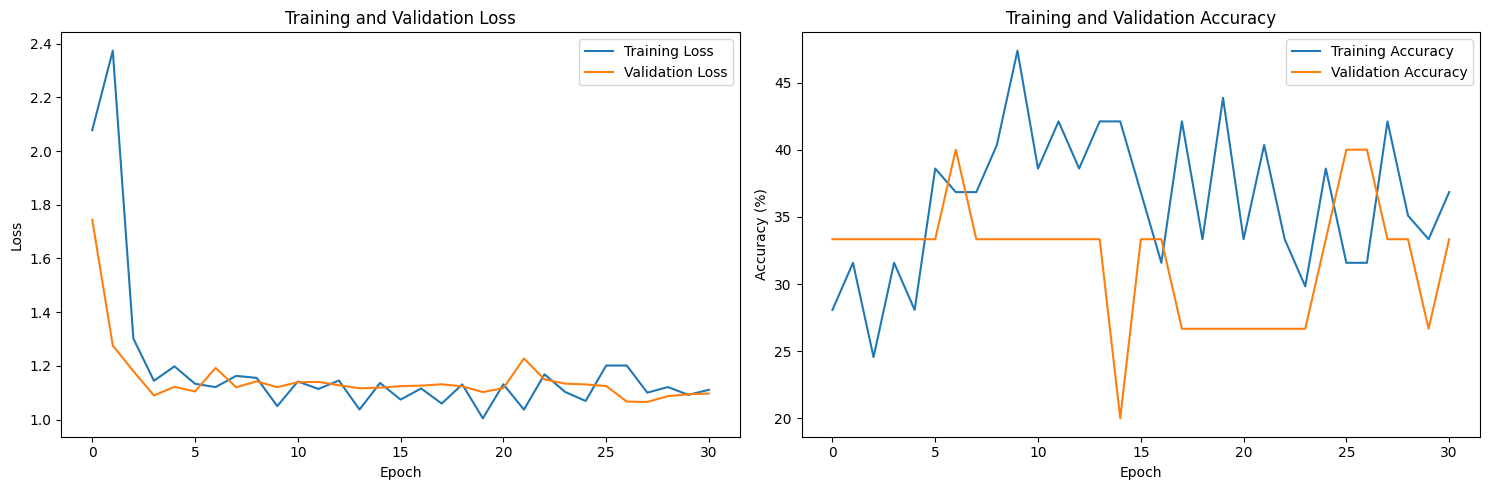

Confusion Matrix:


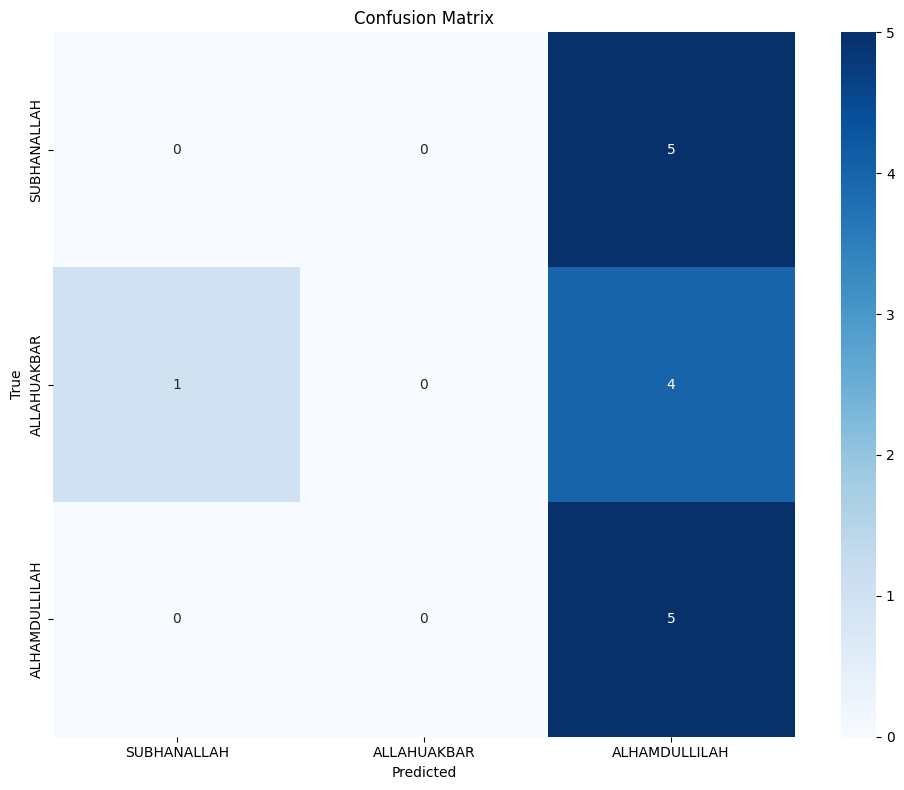

Accuracy for class SUBHANALLAH: 0.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 100.00%
Training and evaluation completed!
Epoch 32/50
----------
Epoch 32, Batch 5: Loss: 1.103, Acc: 42.50%
Training Loss: 1.0882, Training Acc: 42.11%
Validation Loss: 1.0881, Validation Acc: 33.33%



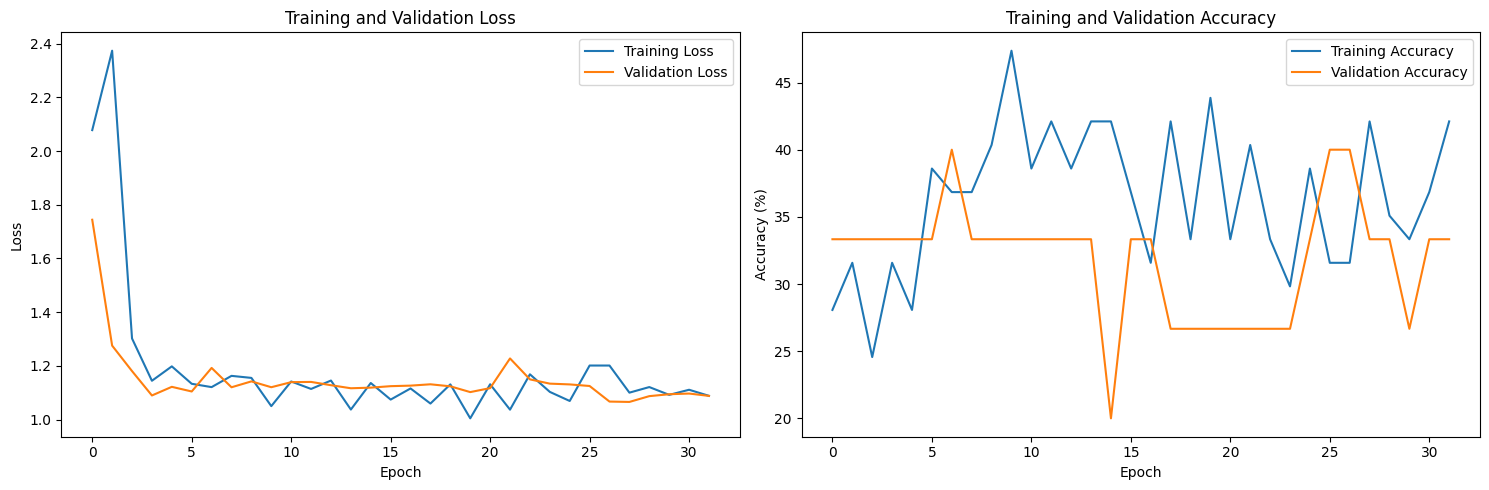

Confusion Matrix:


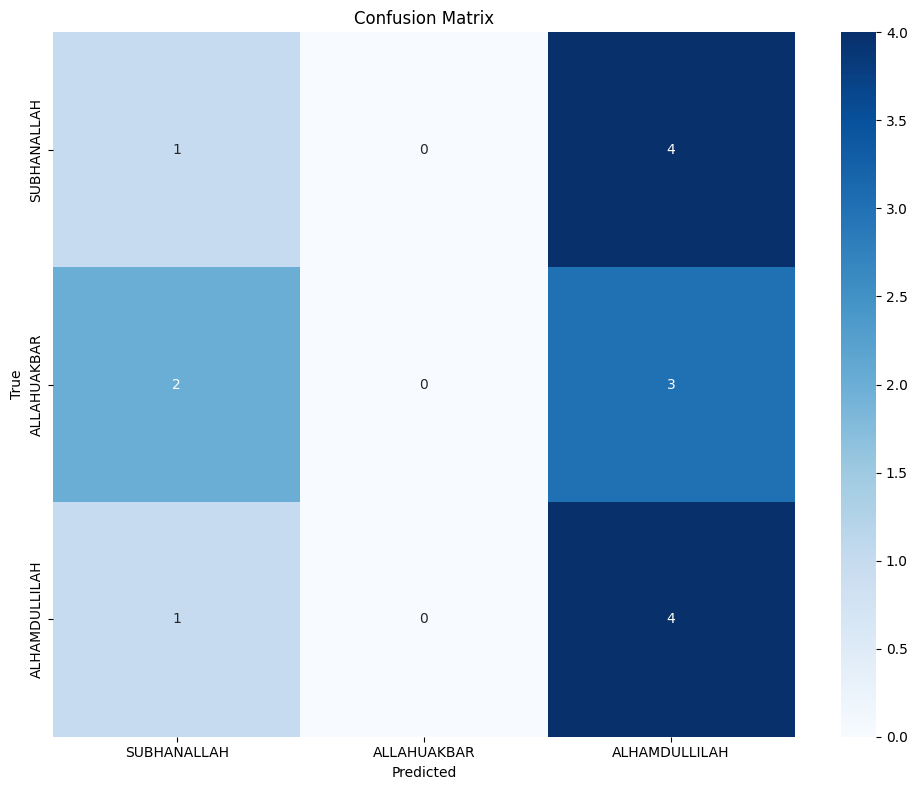

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 80.00%
Training and evaluation completed!
Epoch 33/50
----------
Epoch 33, Batch 5: Loss: 1.086, Acc: 40.00%
Training Loss: 1.0529, Training Acc: 42.11%
Validation Loss: 1.0665, Validation Acc: 46.67%



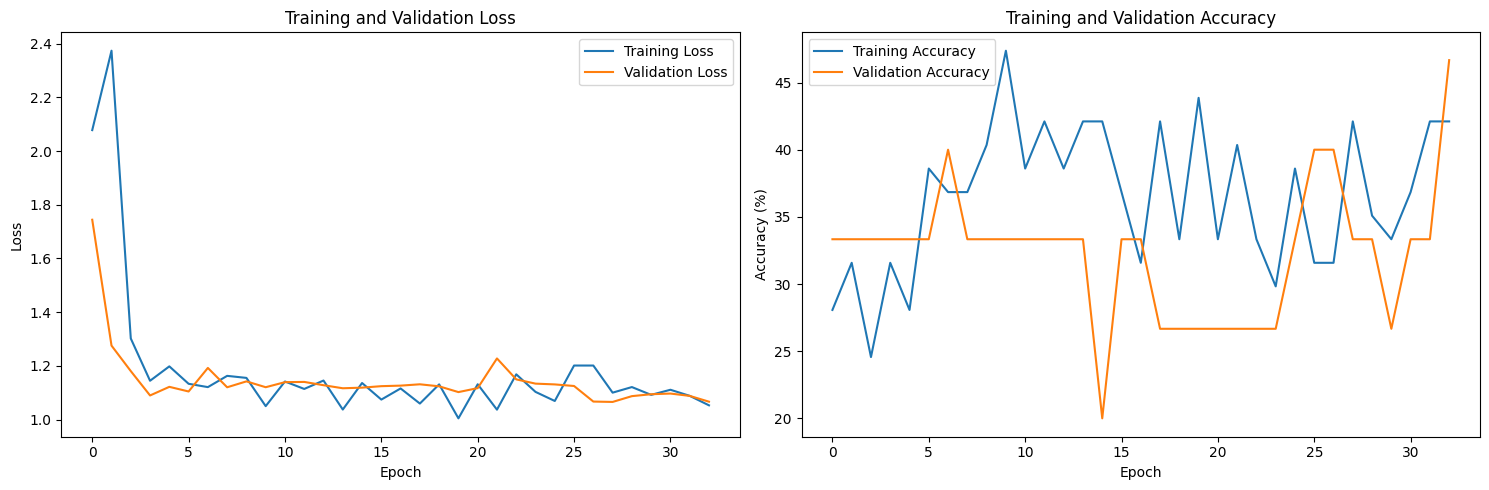

Confusion Matrix:


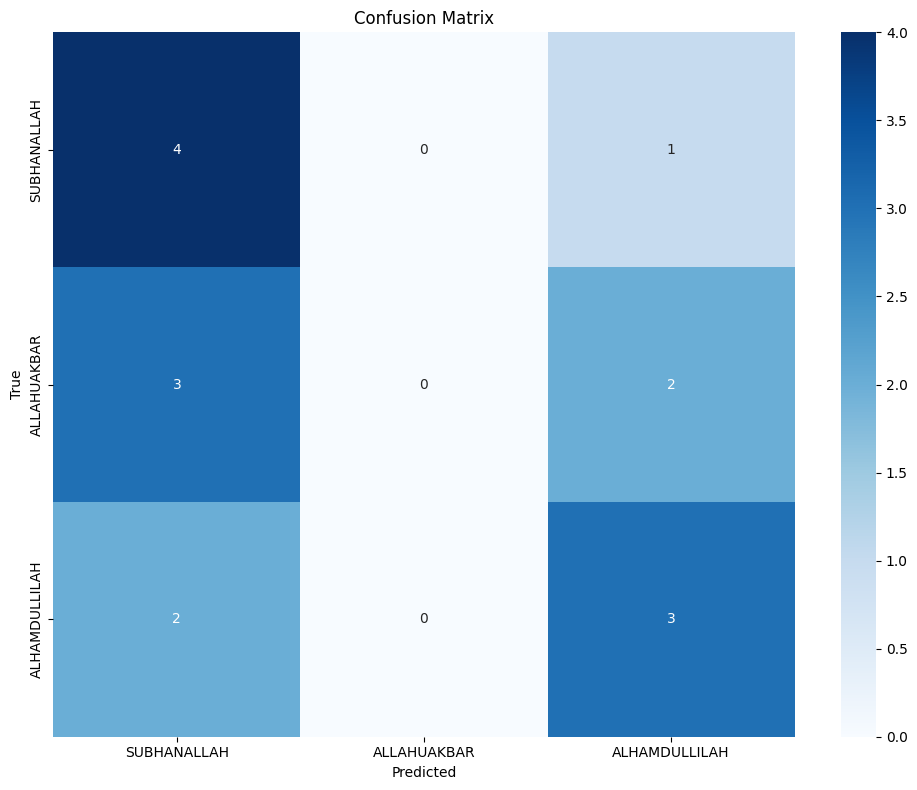

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 60.00%
Training and evaluation completed!
Epoch 34/50
----------
Epoch 34, Batch 5: Loss: 1.096, Acc: 40.00%
Training Loss: 1.2387, Training Acc: 36.84%
Validation Loss: 1.0554, Validation Acc: 46.67%



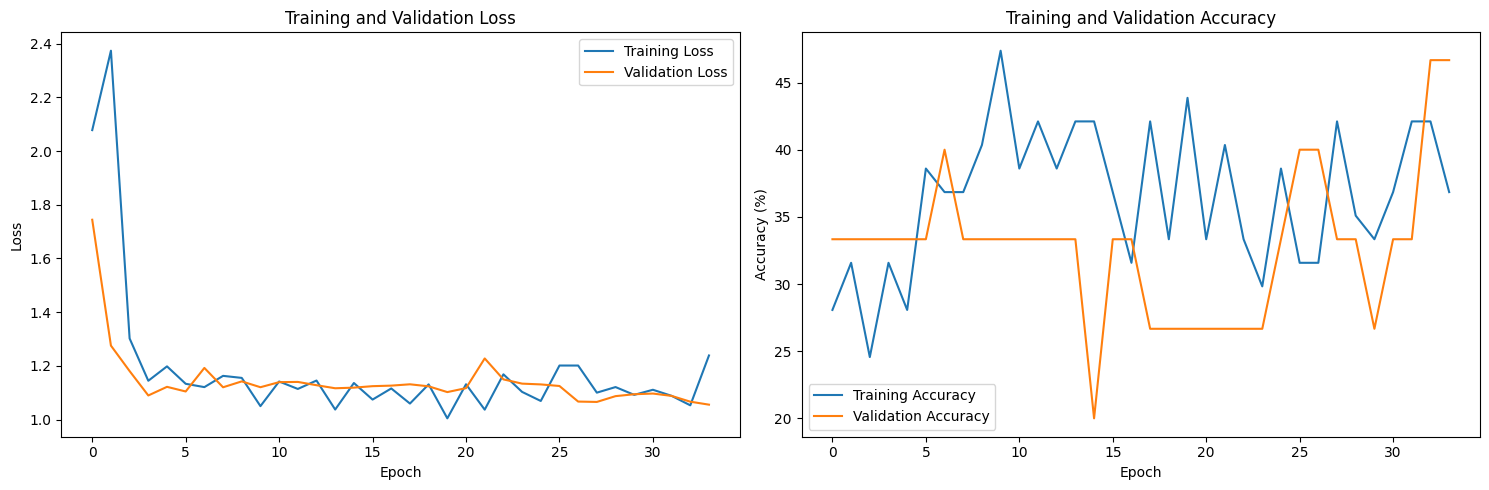

Confusion Matrix:


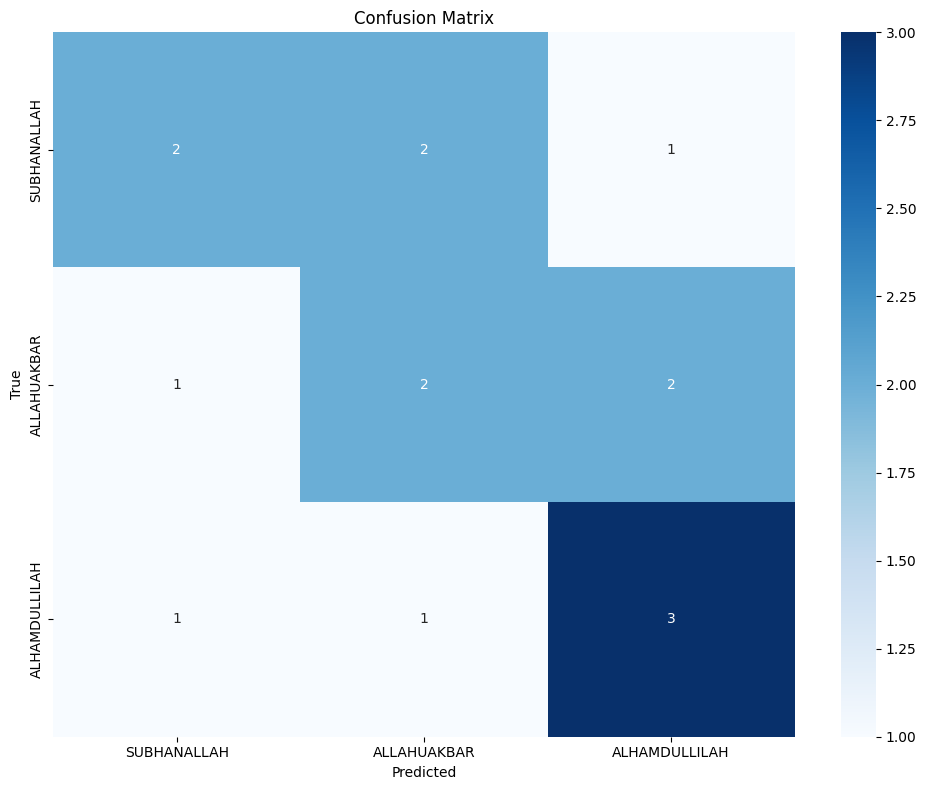

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 40.00%
Accuracy for class ALHAMDULLILAH: 60.00%
Training and evaluation completed!
Epoch 35/50
----------
Epoch 35, Batch 5: Loss: 1.048, Acc: 47.50%
Training Loss: 1.0771, Training Acc: 45.61%
Validation Loss: 1.0838, Validation Acc: 46.67%



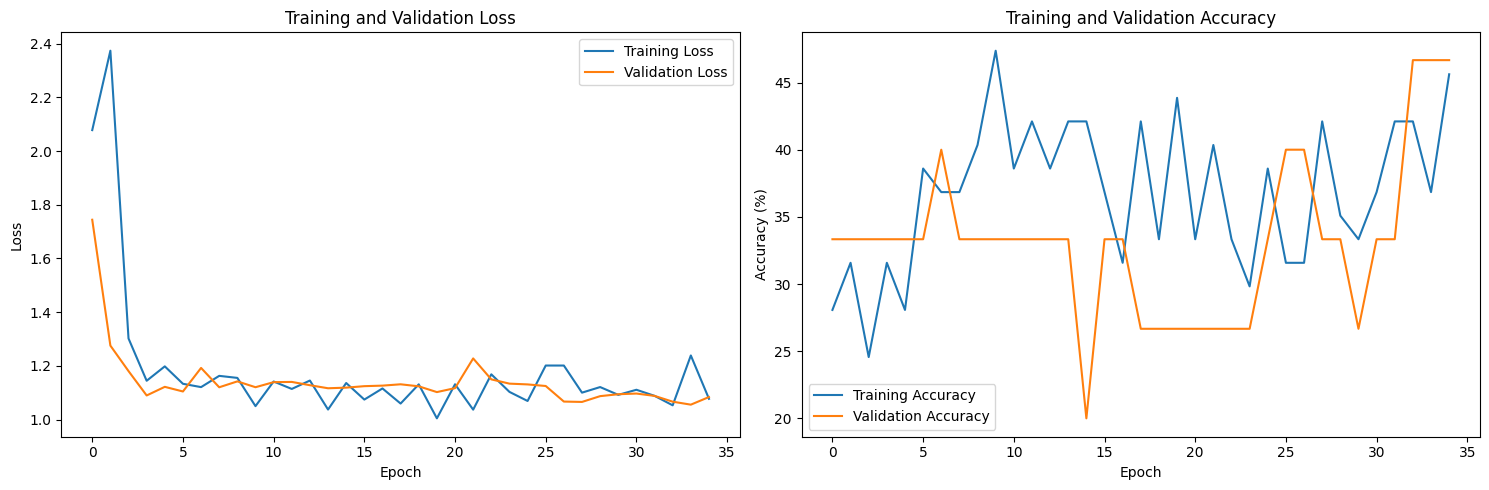

Confusion Matrix:


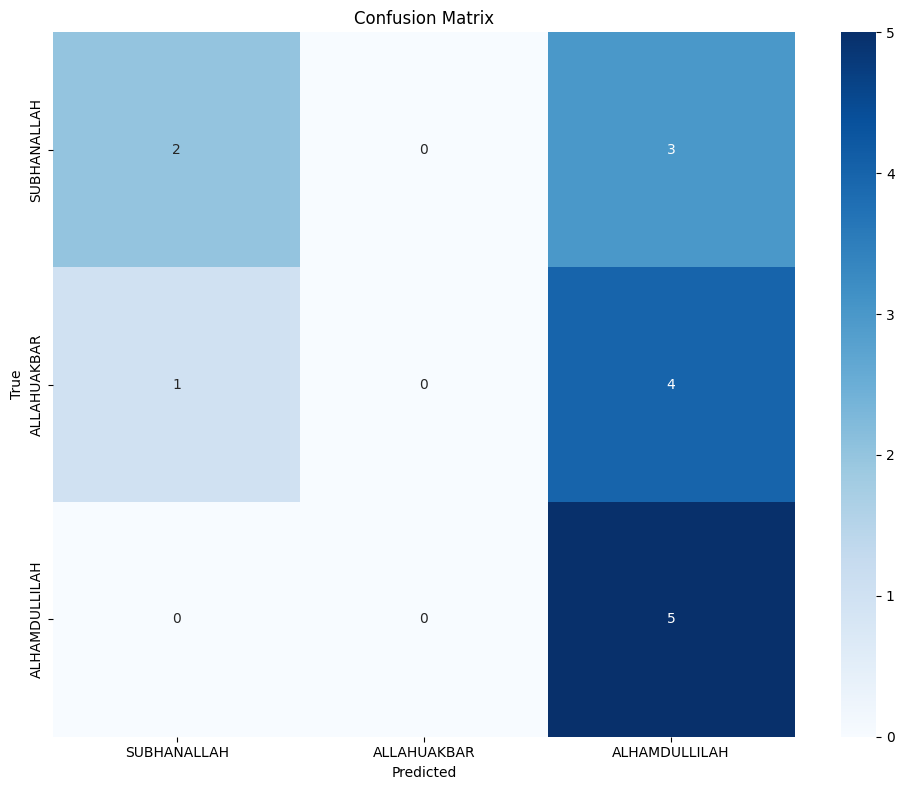

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 100.00%
Training and evaluation completed!
Epoch 36/50
----------
Epoch 36, Batch 5: Loss: 1.092, Acc: 42.50%
Training Loss: 1.0694, Training Acc: 43.86%
Validation Loss: 1.0713, Validation Acc: 40.00%



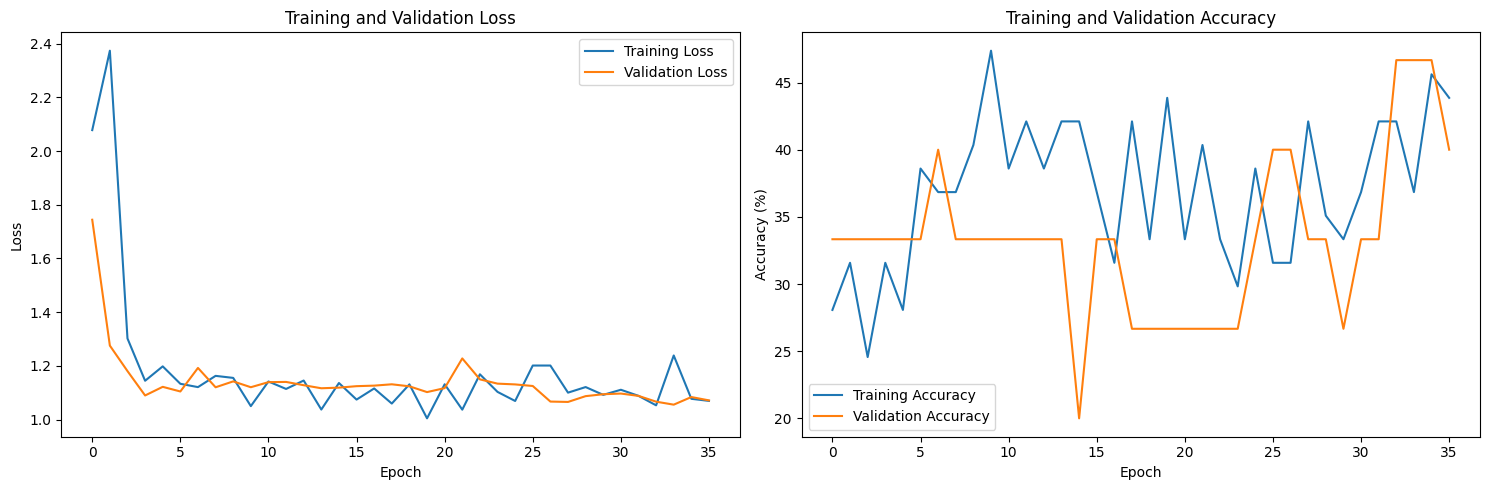

Confusion Matrix:


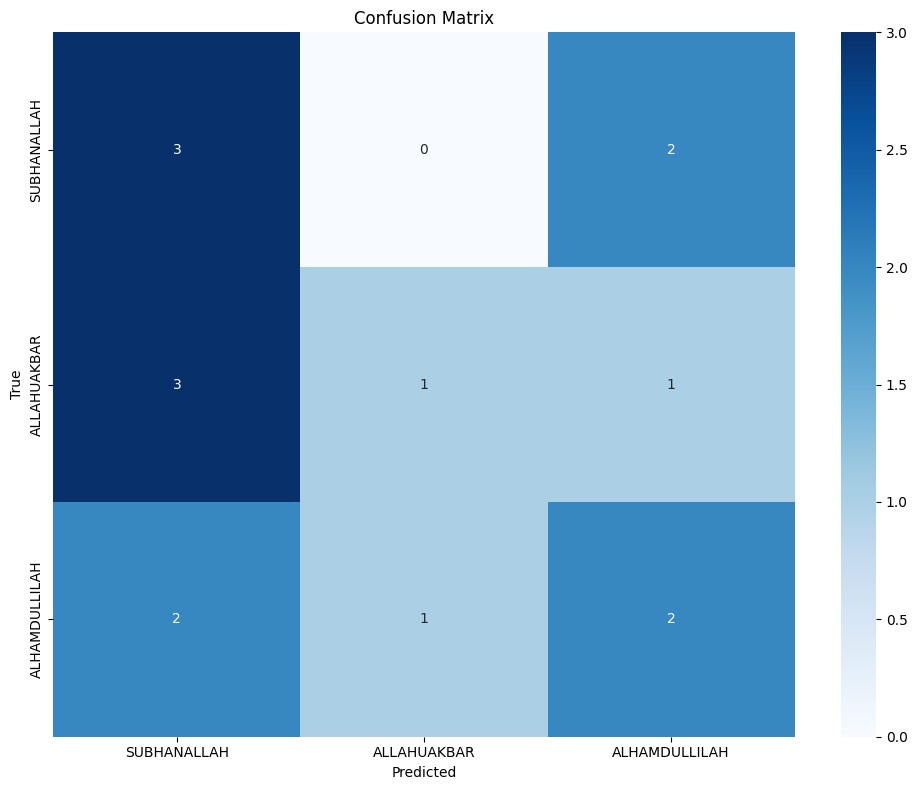

Accuracy for class SUBHANALLAH: 60.00%
Accuracy for class ALLAHUAKBAR: 20.00%
Accuracy for class ALHAMDULLILAH: 40.00%
Training and evaluation completed!
Epoch 37/50
----------
Epoch 37, Batch 5: Loss: 1.050, Acc: 42.50%
Training Loss: 1.1058, Training Acc: 38.60%
Validation Loss: 1.0576, Validation Acc: 46.67%



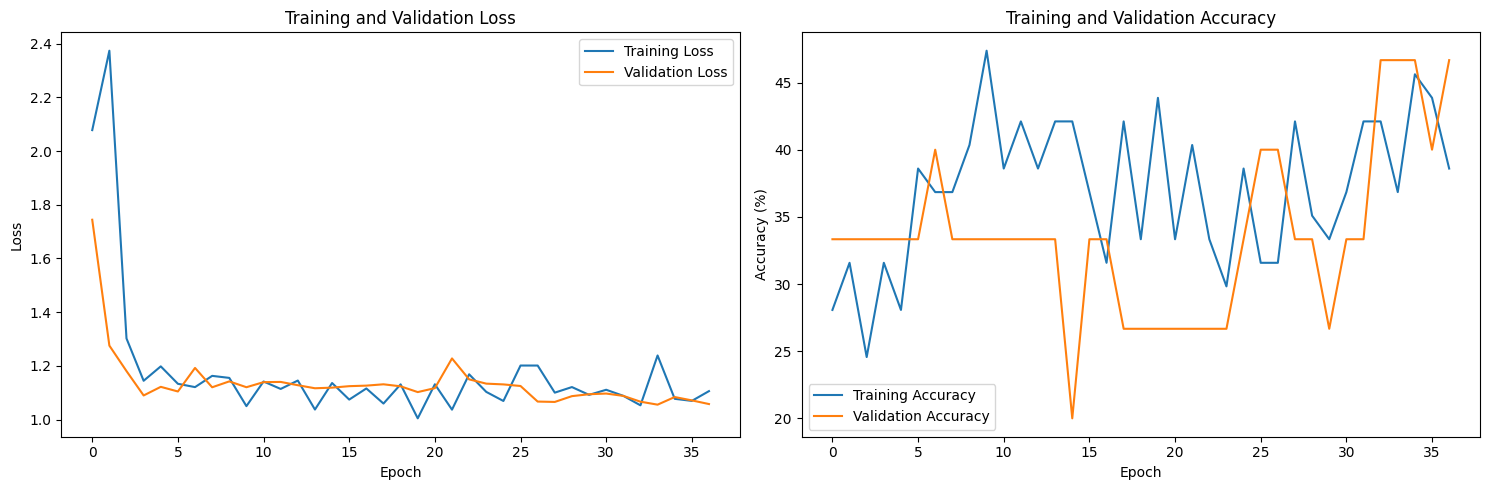

Confusion Matrix:


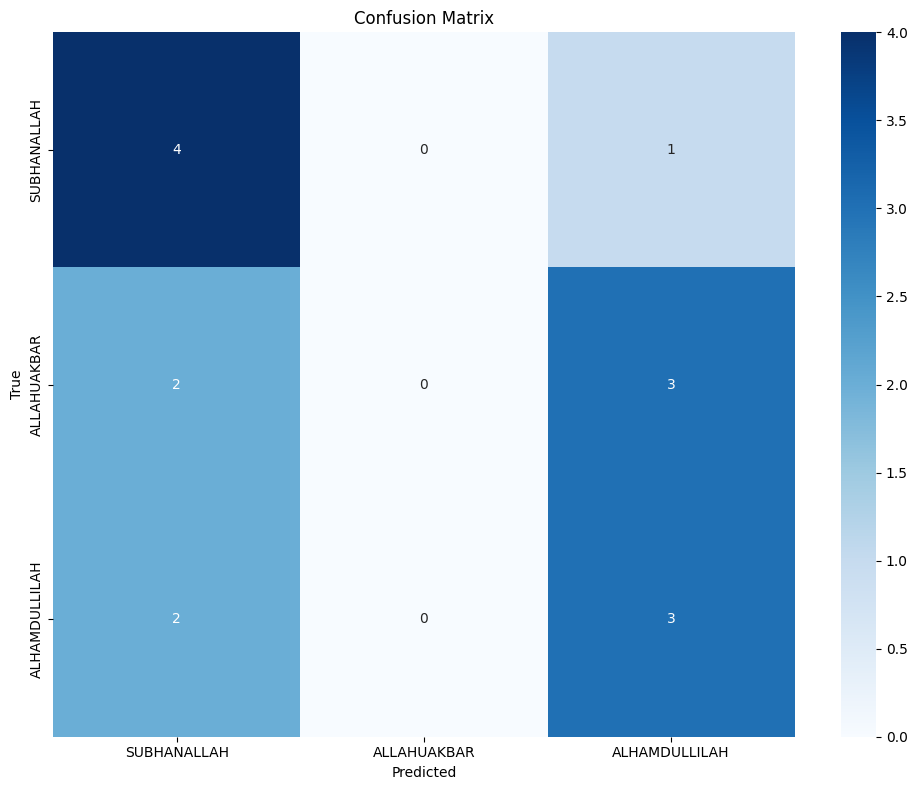

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 60.00%
Training and evaluation completed!
Epoch 38/50
----------
Epoch 38, Batch 5: Loss: 1.076, Acc: 35.00%
Training Loss: 1.0926, Training Acc: 33.33%
Validation Loss: 1.0437, Validation Acc: 46.67%



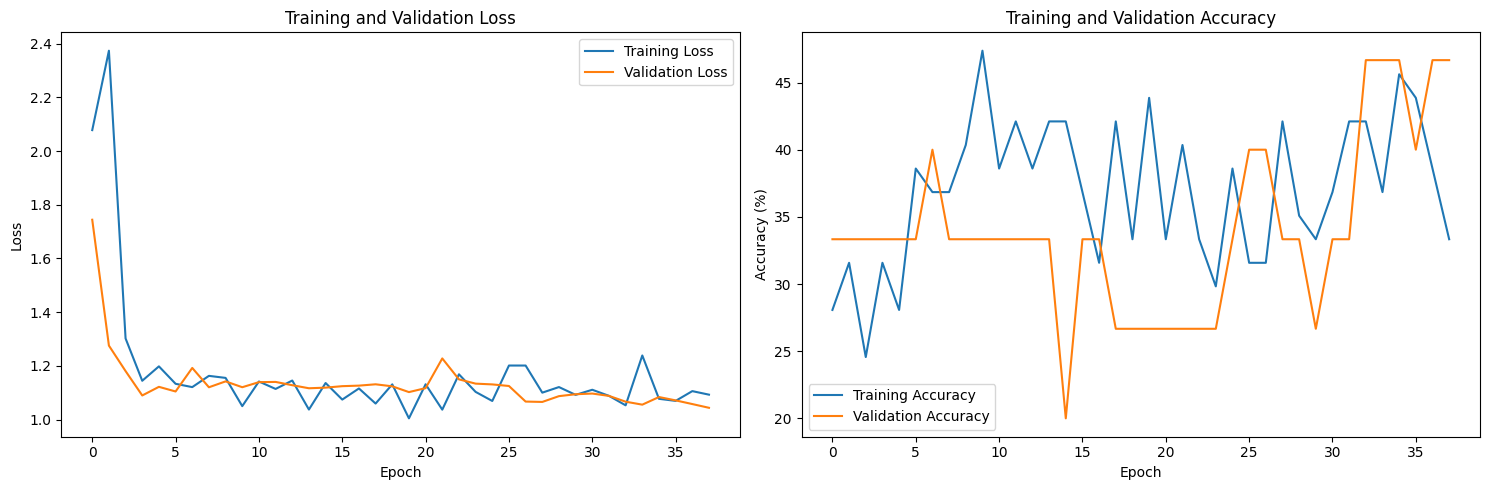

Confusion Matrix:


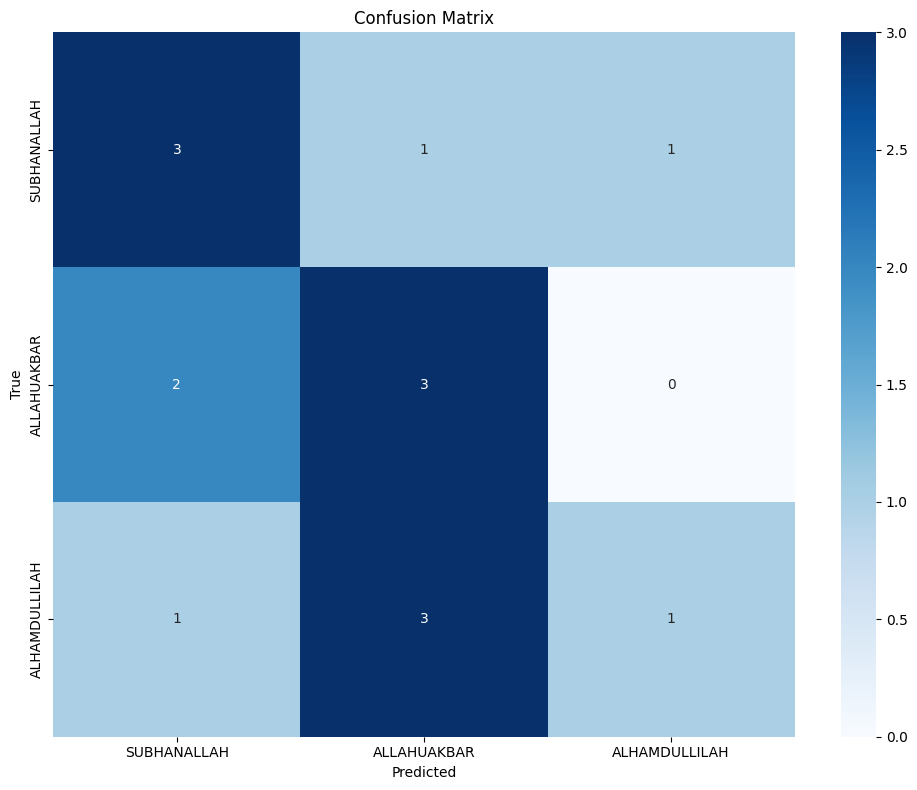

Accuracy for class SUBHANALLAH: 60.00%
Accuracy for class ALLAHUAKBAR: 60.00%
Accuracy for class ALHAMDULLILAH: 20.00%
Training and evaluation completed!
Epoch 39/50
----------
Epoch 39, Batch 5: Loss: 1.070, Acc: 35.00%
Training Loss: 1.0672, Training Acc: 36.84%
Validation Loss: 1.0300, Validation Acc: 53.33%



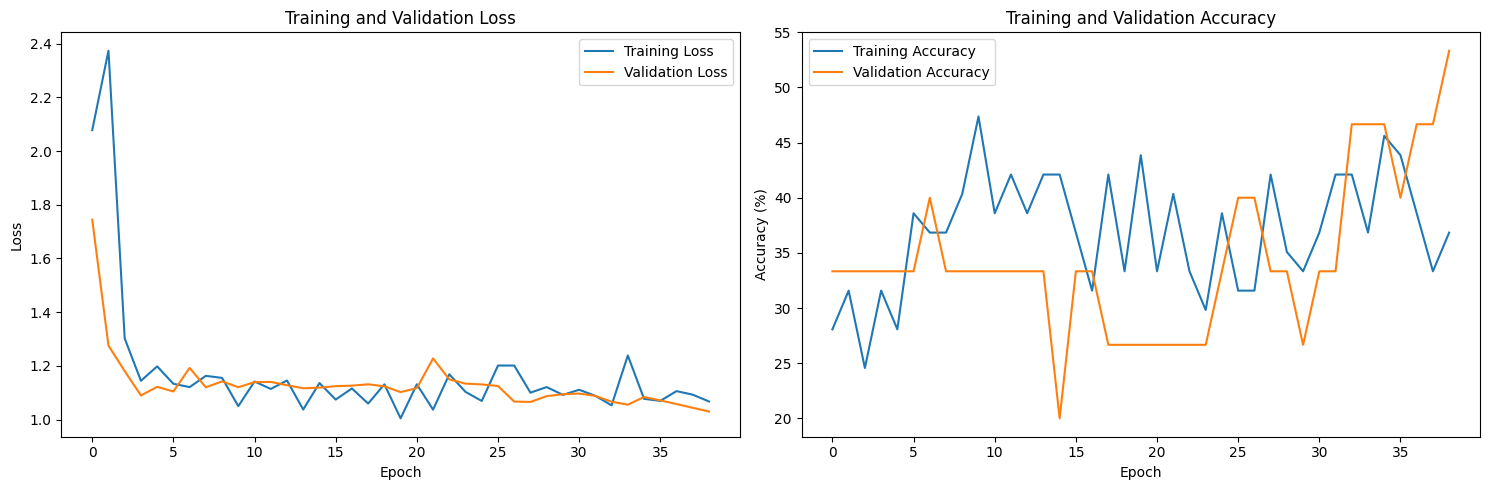

Confusion Matrix:


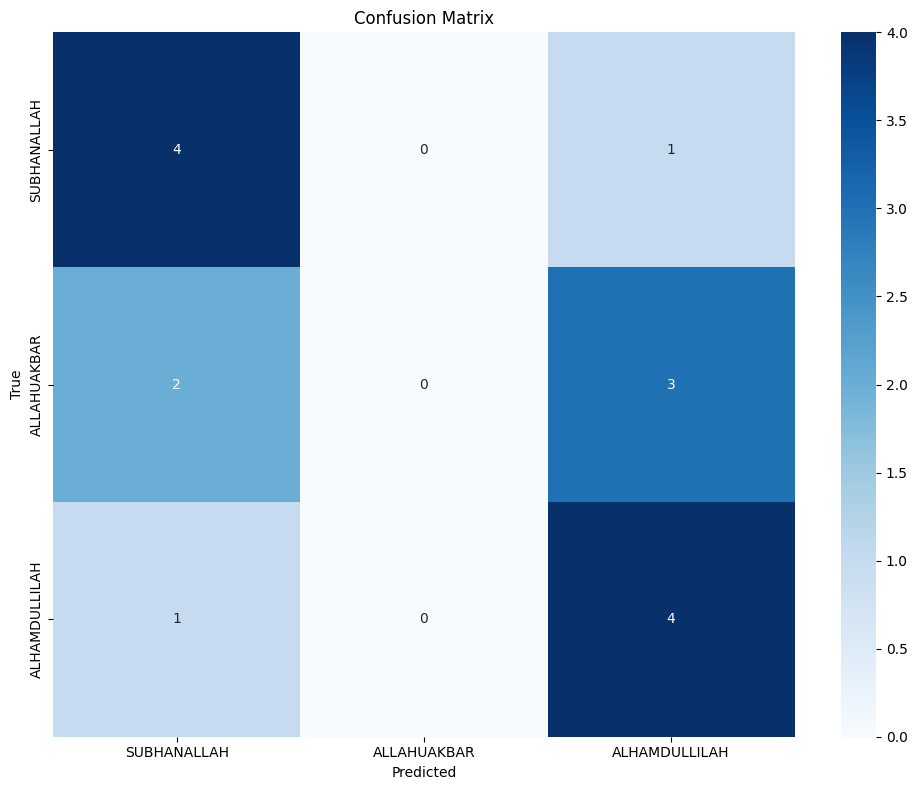

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 80.00%
Training and evaluation completed!
Epoch 40/50
----------
Epoch 40, Batch 5: Loss: 1.032, Acc: 35.00%
Training Loss: 1.0805, Training Acc: 42.11%
Validation Loss: 1.0474, Validation Acc: 46.67%



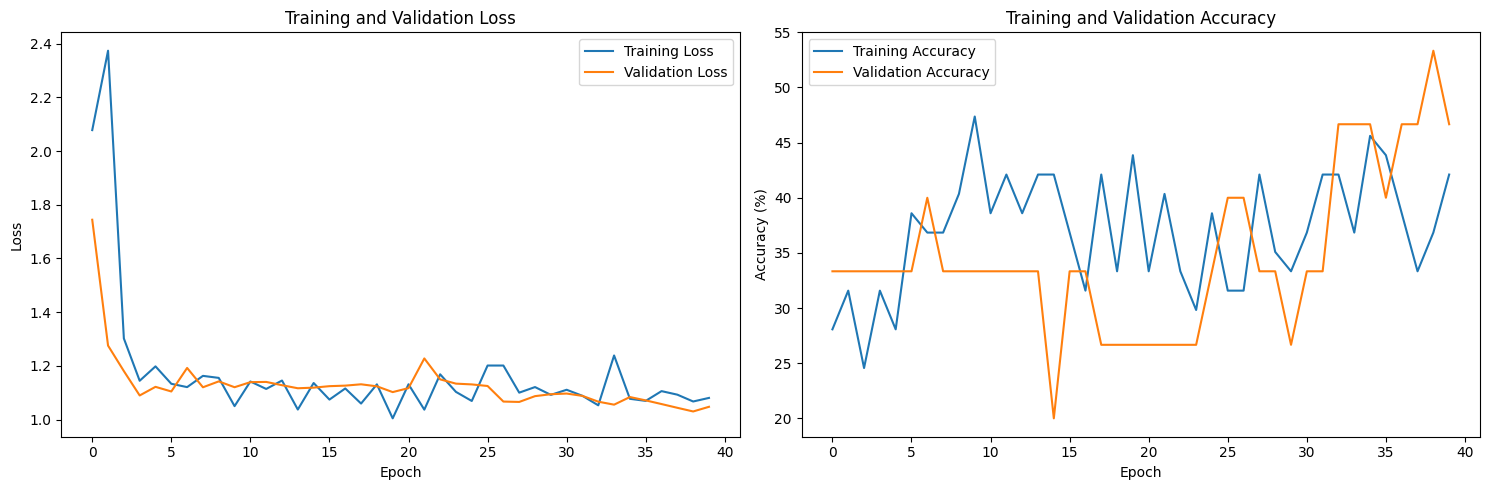

Confusion Matrix:


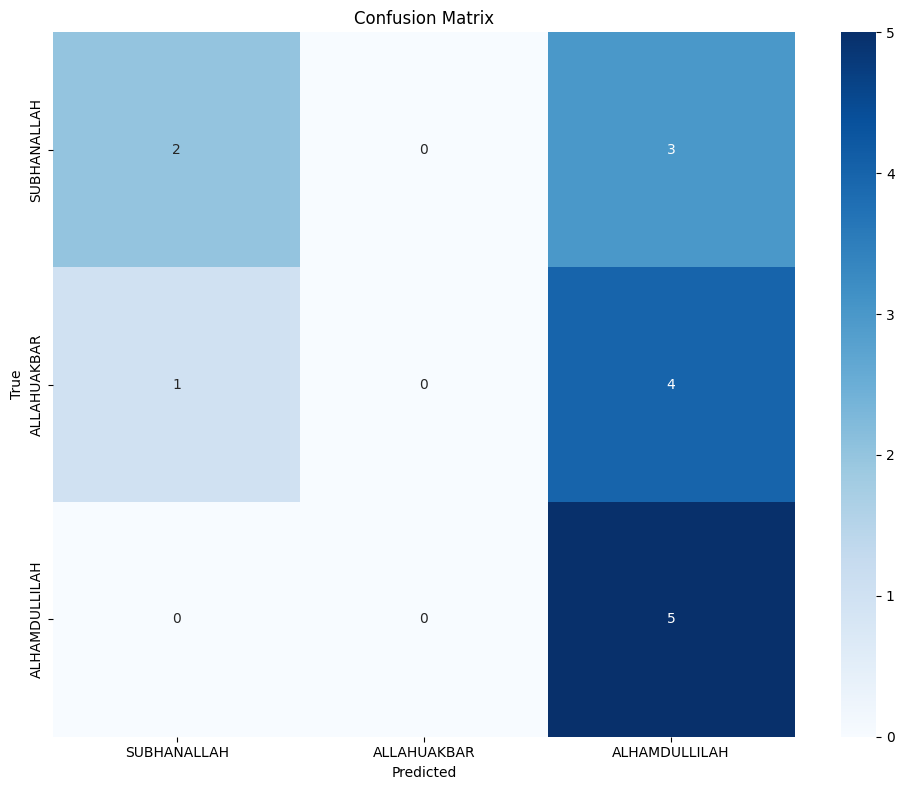

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 100.00%
Training and evaluation completed!
Epoch 41/50
----------
Epoch 41, Batch 5: Loss: 1.056, Acc: 42.50%
Training Loss: 1.0371, Training Acc: 43.86%
Validation Loss: 1.0413, Validation Acc: 46.67%



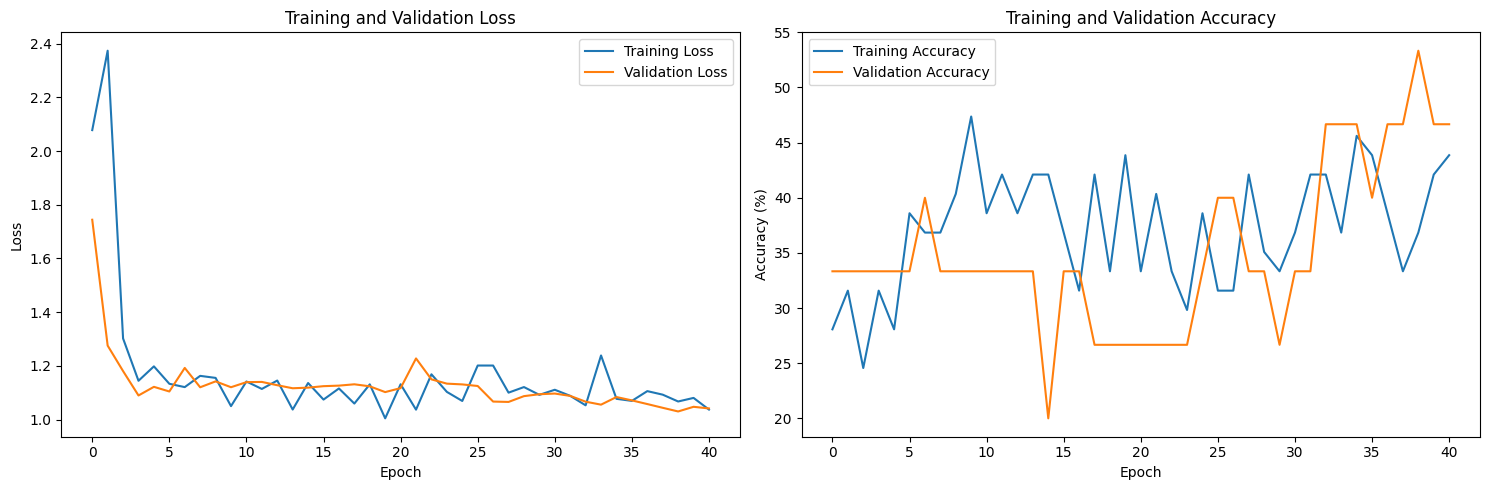

Confusion Matrix:


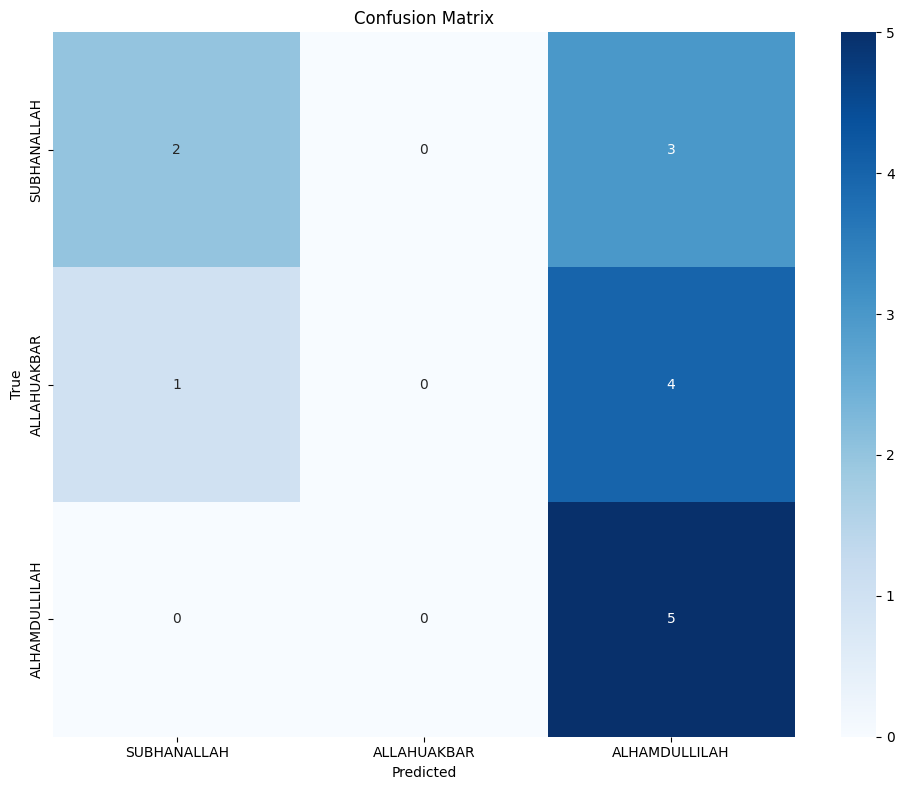

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 100.00%
Training and evaluation completed!
Epoch 42/50
----------
Epoch 42, Batch 5: Loss: 1.018, Acc: 45.00%
Training Loss: 1.0534, Training Acc: 42.11%
Validation Loss: 0.9963, Validation Acc: 46.67%



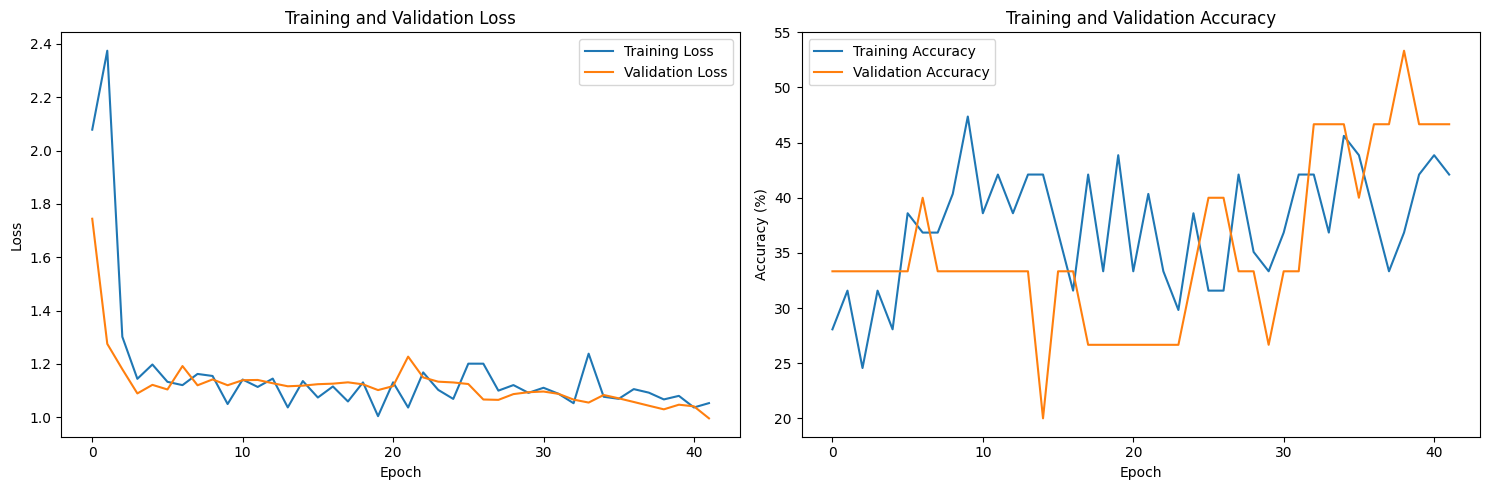

Confusion Matrix:


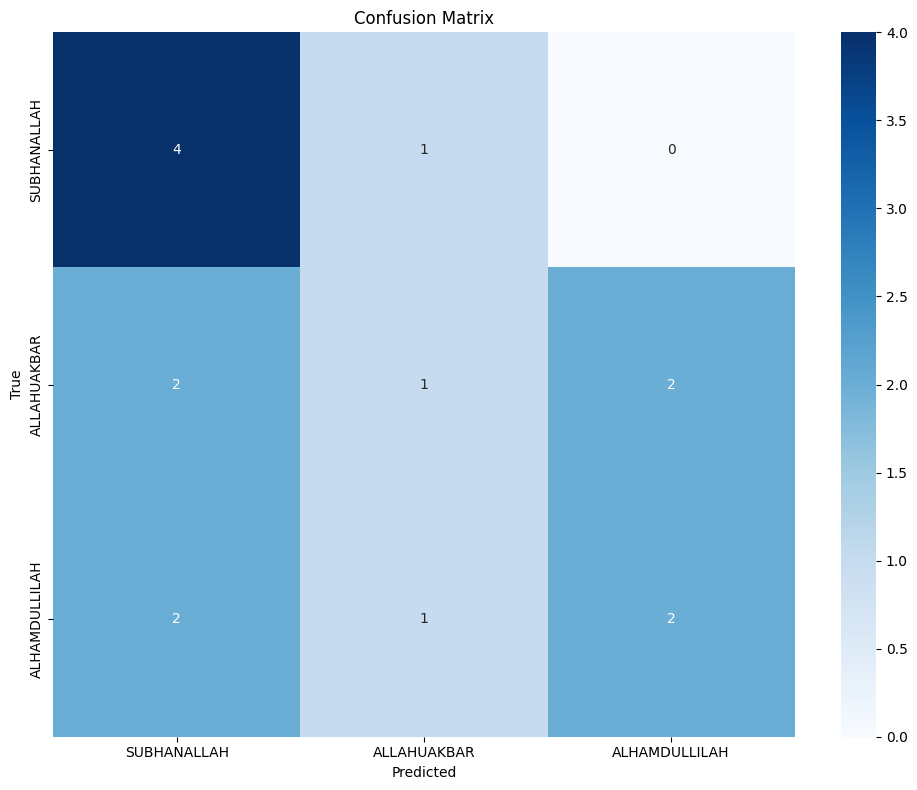

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 20.00%
Accuracy for class ALHAMDULLILAH: 40.00%
Training and evaluation completed!
Epoch 43/50
----------
Epoch 43, Batch 5: Loss: 1.070, Acc: 42.50%
Training Loss: 1.0577, Training Acc: 36.84%
Validation Loss: 0.9770, Validation Acc: 53.33%



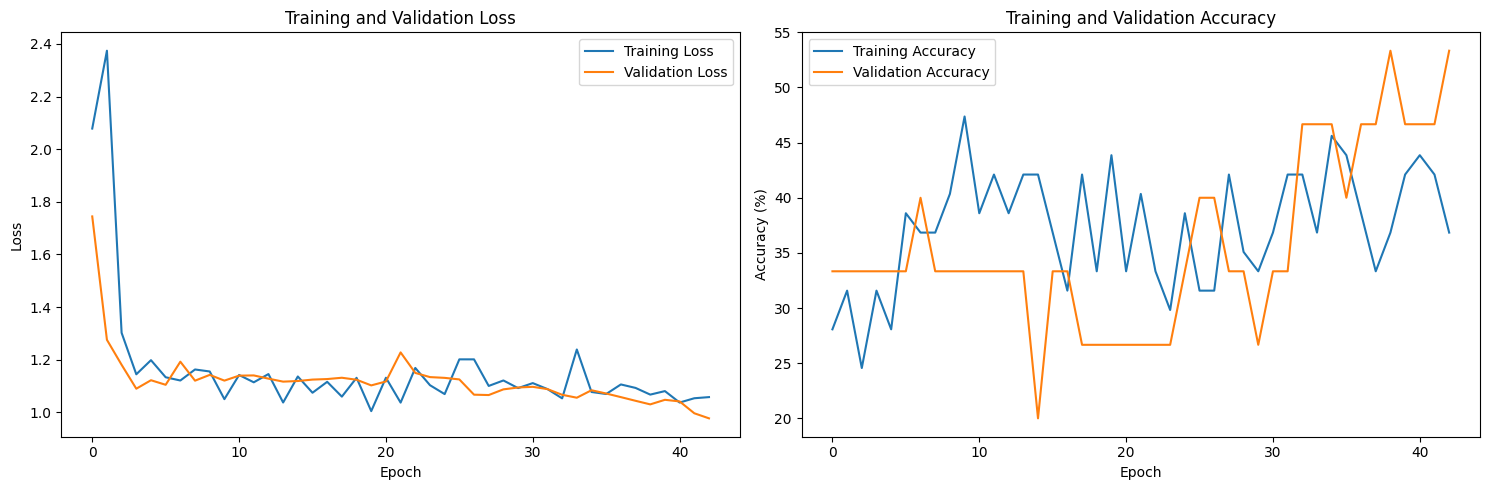

Confusion Matrix:


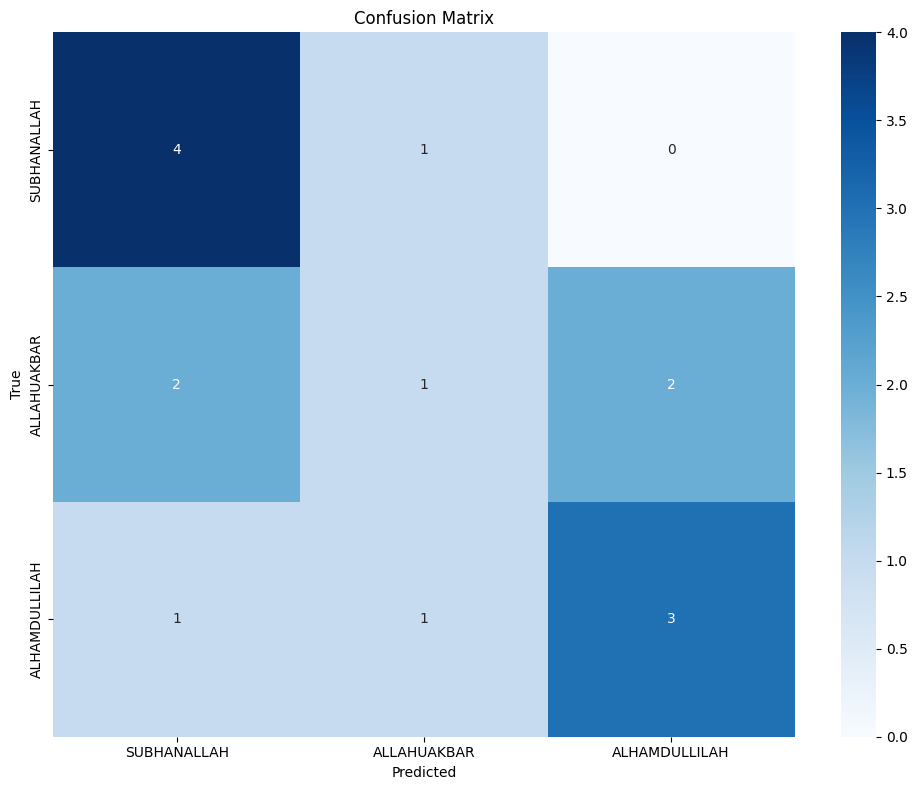

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 20.00%
Accuracy for class ALHAMDULLILAH: 60.00%
Training and evaluation completed!
Epoch 44/50
----------
Epoch 44, Batch 5: Loss: 0.961, Acc: 62.50%
Training Loss: 0.9769, Training Acc: 56.14%
Validation Loss: 0.9024, Validation Acc: 60.00%



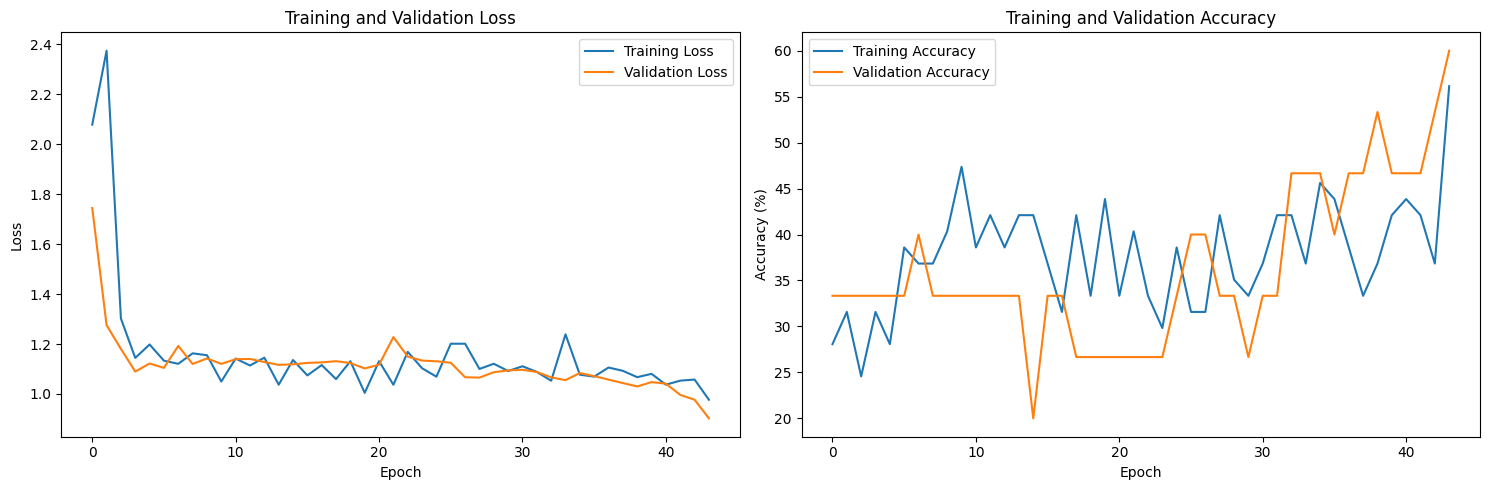

Confusion Matrix:


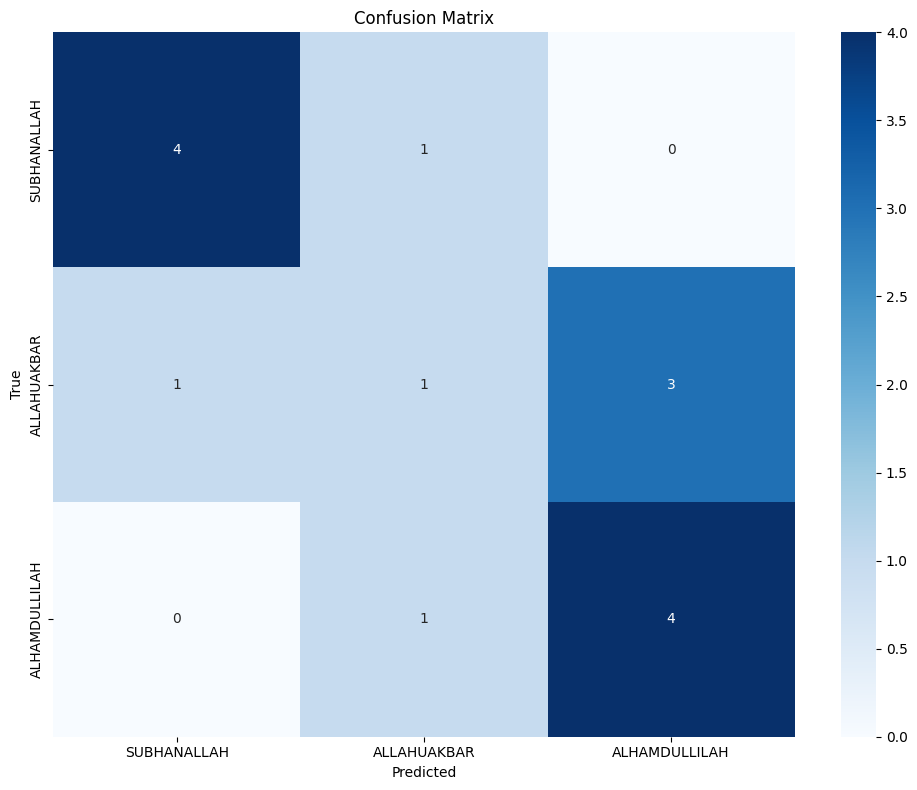

Accuracy for class SUBHANALLAH: 80.00%
Accuracy for class ALLAHUAKBAR: 20.00%
Accuracy for class ALHAMDULLILAH: 80.00%
Training and evaluation completed!
Epoch 45/50
----------
Epoch 45, Batch 5: Loss: 0.927, Acc: 45.00%
Training Loss: 1.0286, Training Acc: 43.86%
Validation Loss: 0.9370, Validation Acc: 53.33%



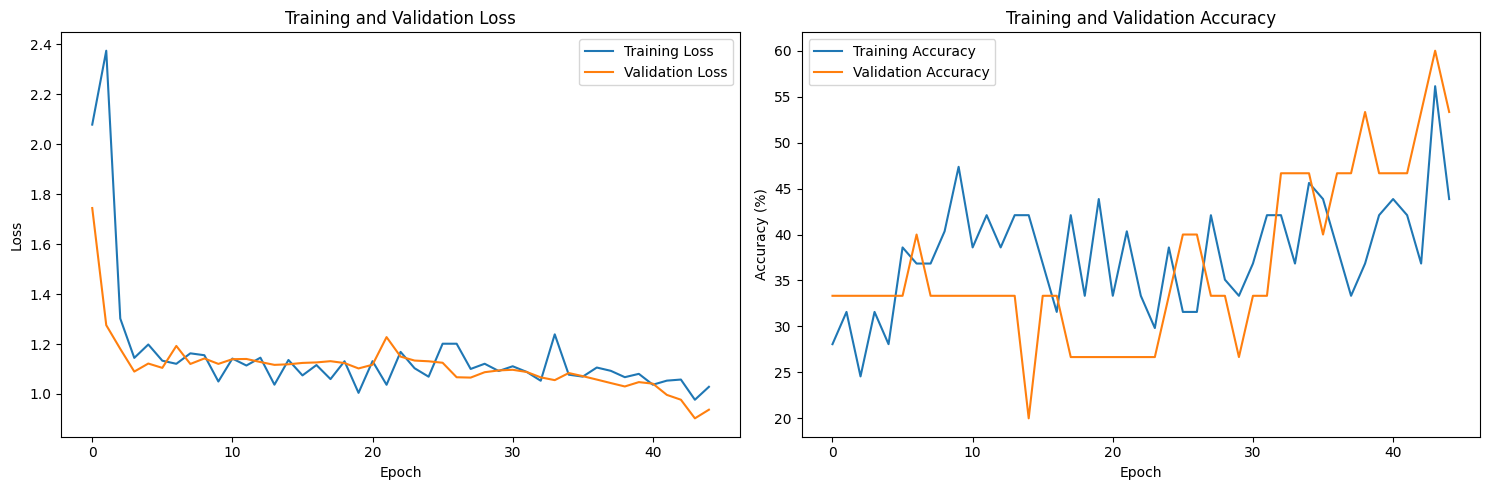

Confusion Matrix:


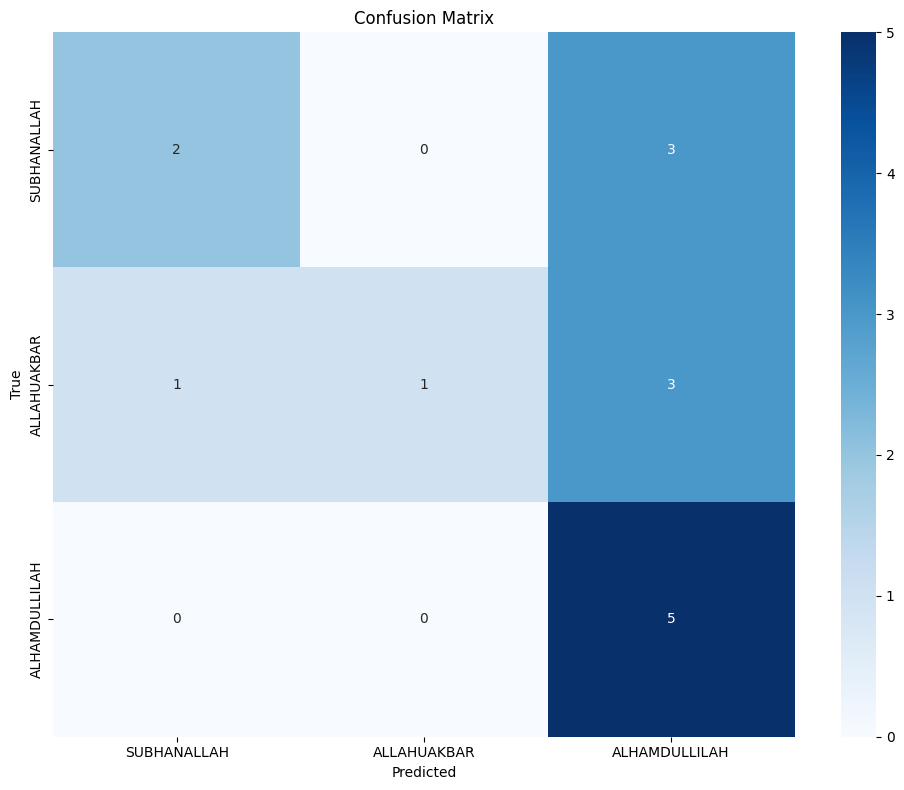

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 20.00%
Accuracy for class ALHAMDULLILAH: 100.00%
Training and evaluation completed!
Epoch 46/50
----------
Epoch 46, Batch 5: Loss: 1.099, Acc: 40.00%
Training Loss: 1.0912, Training Acc: 43.86%
Validation Loss: 1.0651, Validation Acc: 46.67%



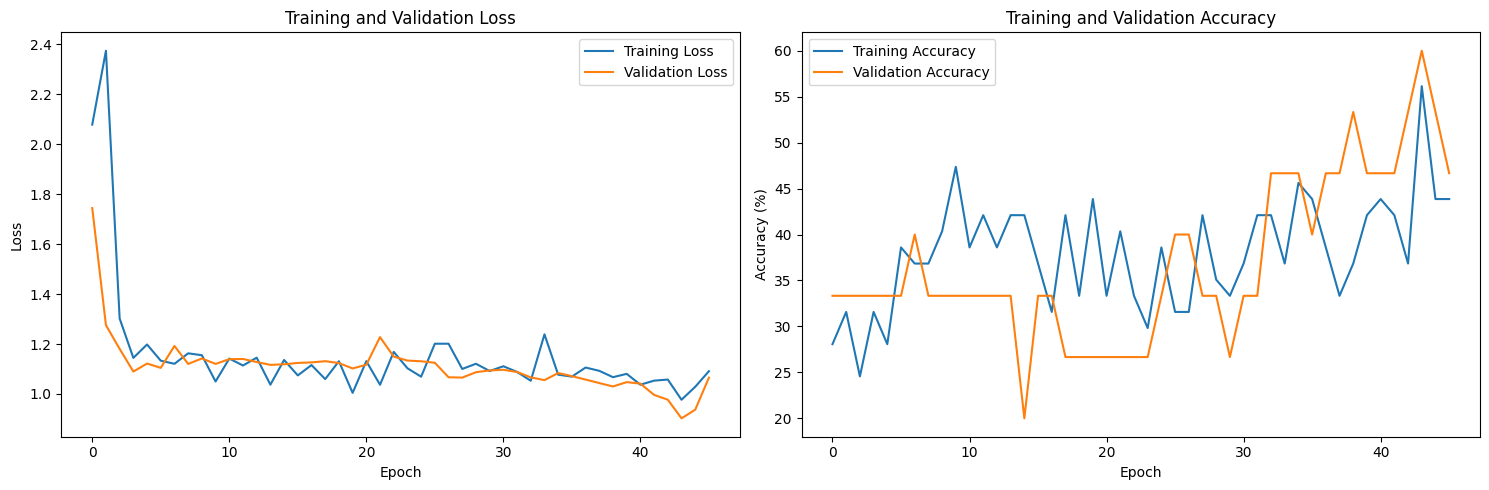

Confusion Matrix:


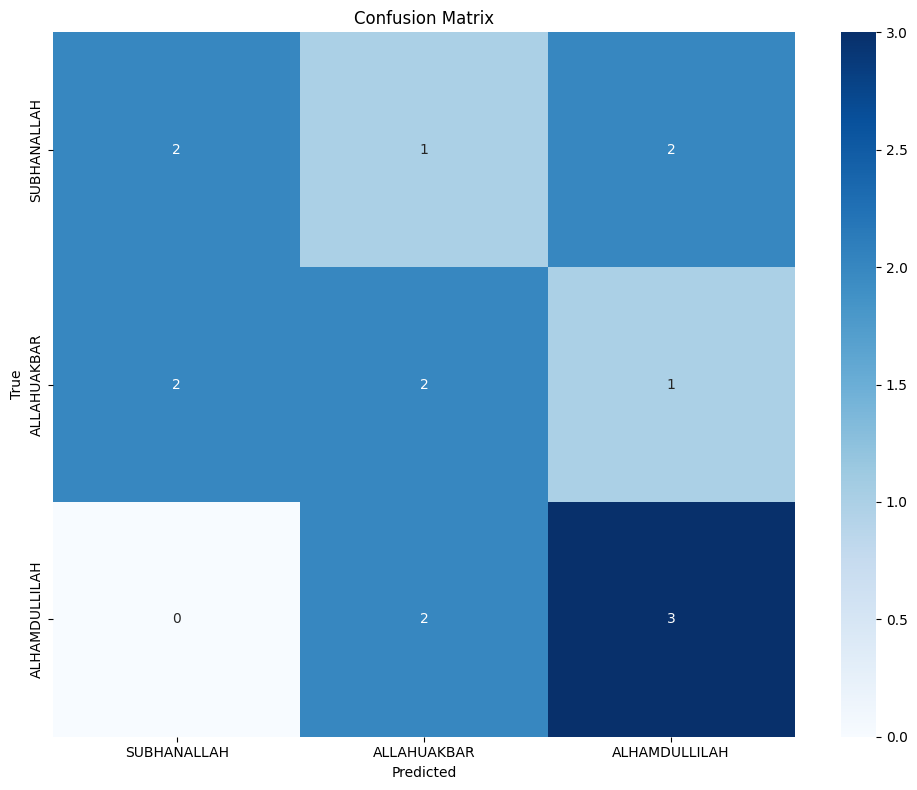

Accuracy for class SUBHANALLAH: 40.00%
Accuracy for class ALLAHUAKBAR: 40.00%
Accuracy for class ALHAMDULLILAH: 60.00%
Training and evaluation completed!
Epoch 47/50
----------
Epoch 47, Batch 5: Loss: 0.956, Acc: 52.50%
Training Loss: 0.9191, Training Acc: 57.89%
Validation Loss: 1.0716, Validation Acc: 33.33%



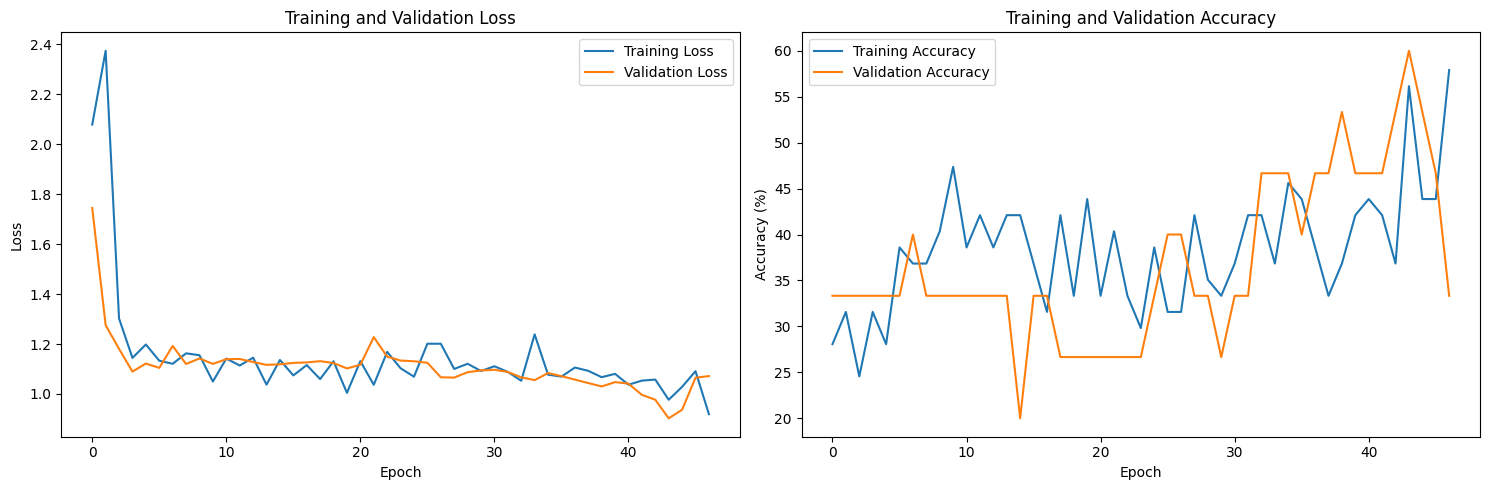

Confusion Matrix:


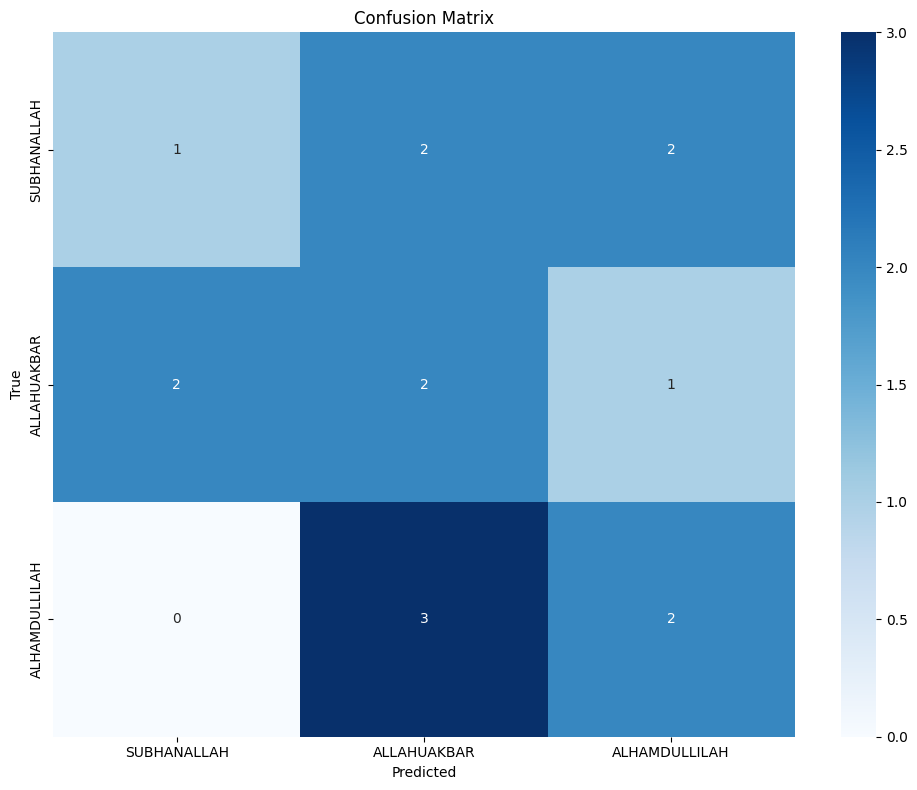

Accuracy for class SUBHANALLAH: 20.00%
Accuracy for class ALLAHUAKBAR: 40.00%
Accuracy for class ALHAMDULLILAH: 40.00%
Training and evaluation completed!
Epoch 48/50
----------
Epoch 48, Batch 5: Loss: 1.055, Acc: 47.50%
Training Loss: 1.0701, Training Acc: 47.37%
Validation Loss: 0.9582, Validation Acc: 53.33%



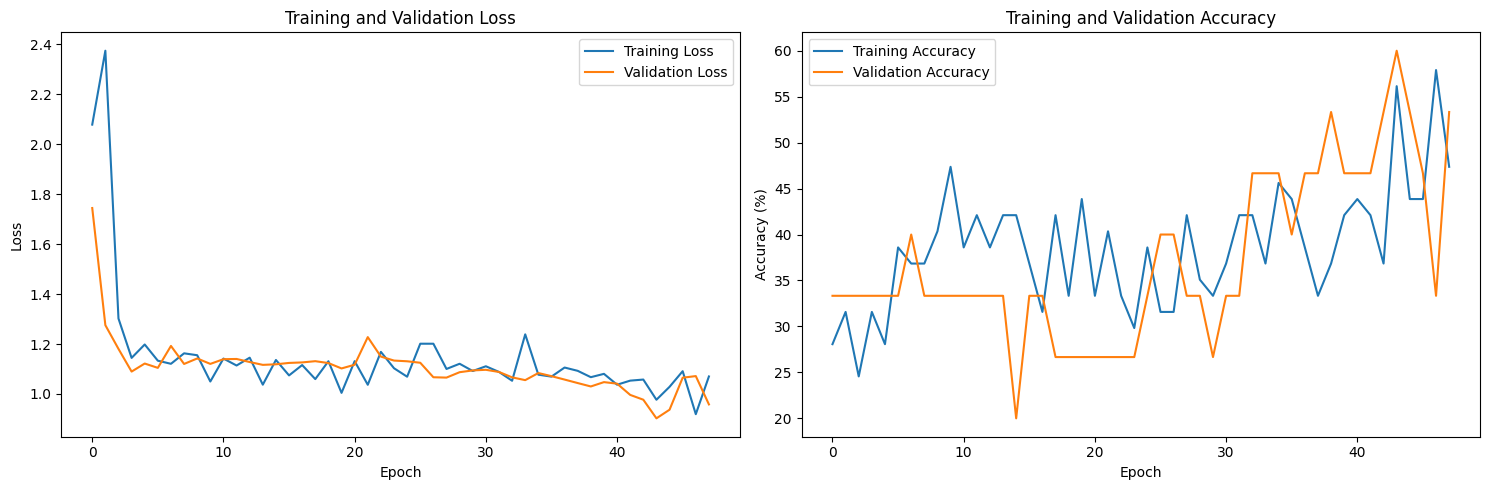

Confusion Matrix:


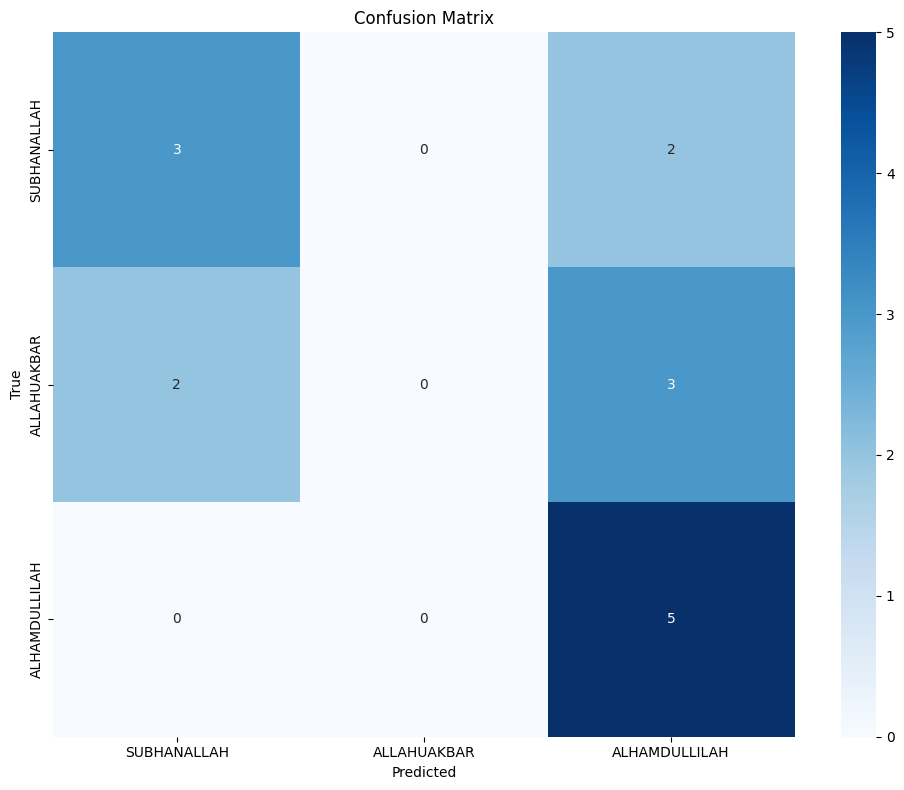

Accuracy for class SUBHANALLAH: 60.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 100.00%
Training and evaluation completed!
Epoch 49/50
----------
Epoch 49, Batch 5: Loss: 0.959, Acc: 60.00%
Training Loss: 0.9324, Training Acc: 57.89%
Validation Loss: 0.9215, Validation Acc: 53.33%



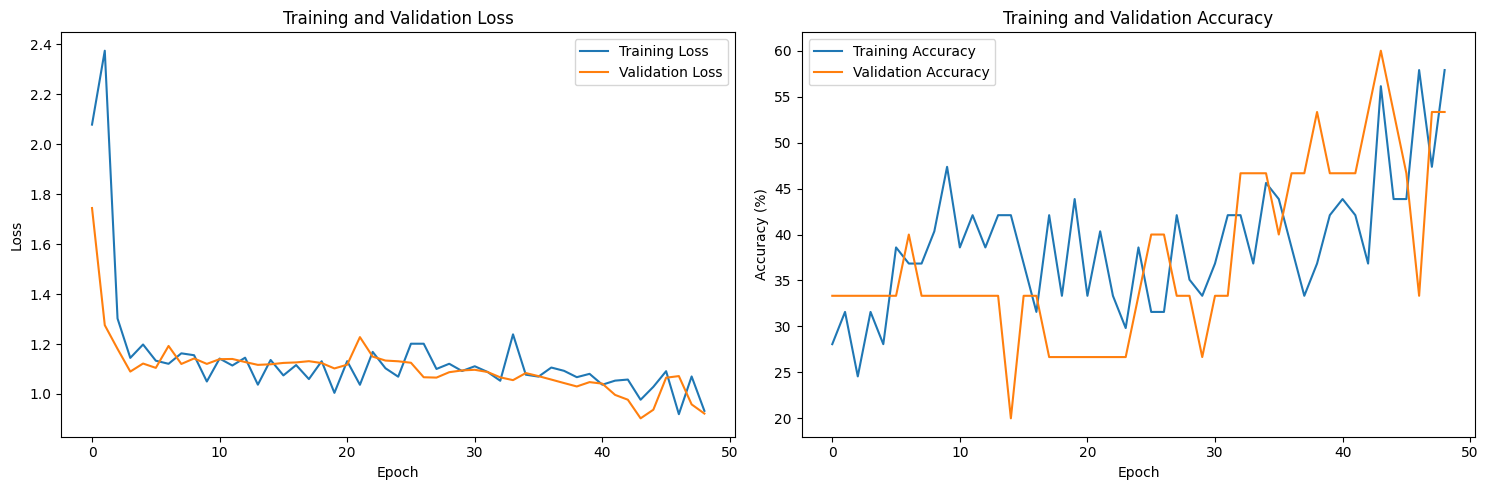

Confusion Matrix:


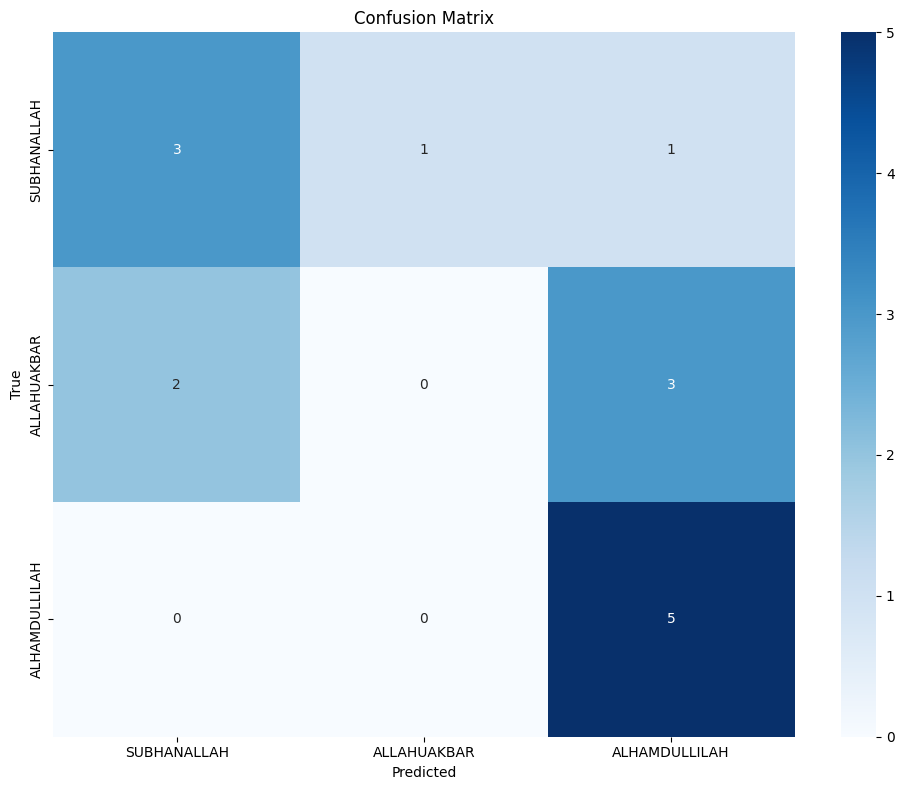

Accuracy for class SUBHANALLAH: 60.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 100.00%
Training and evaluation completed!
Epoch 50/50
----------
Epoch 50, Batch 5: Loss: 0.945, Acc: 52.50%
Training Loss: 0.9839, Training Acc: 50.88%
Validation Loss: 0.8415, Validation Acc: 53.33%



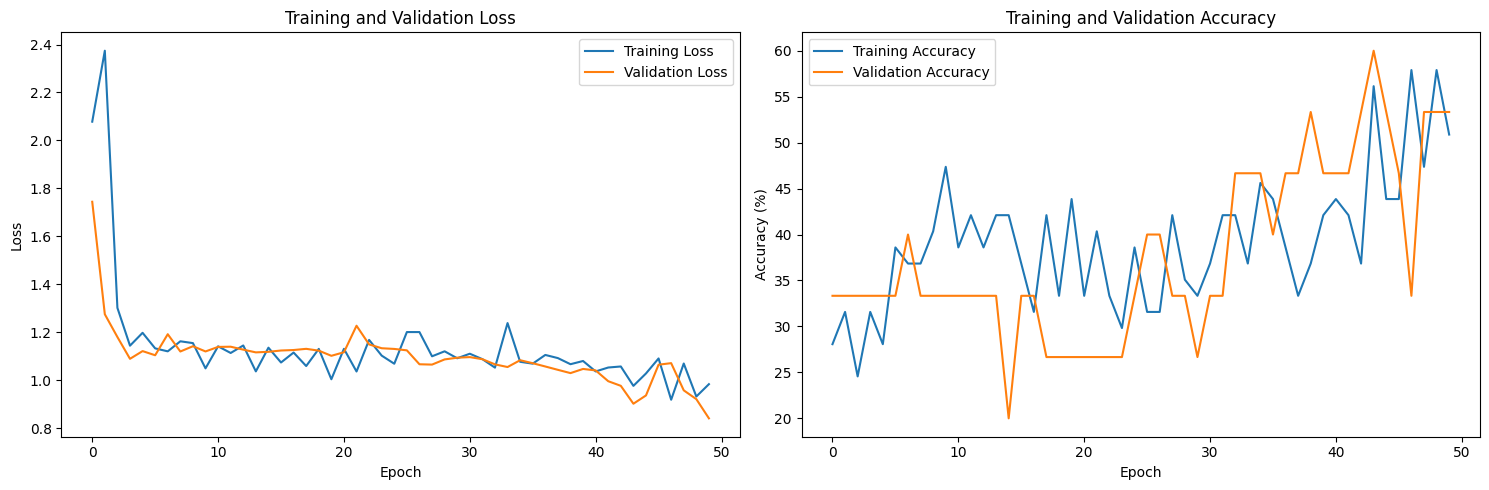

Confusion Matrix:


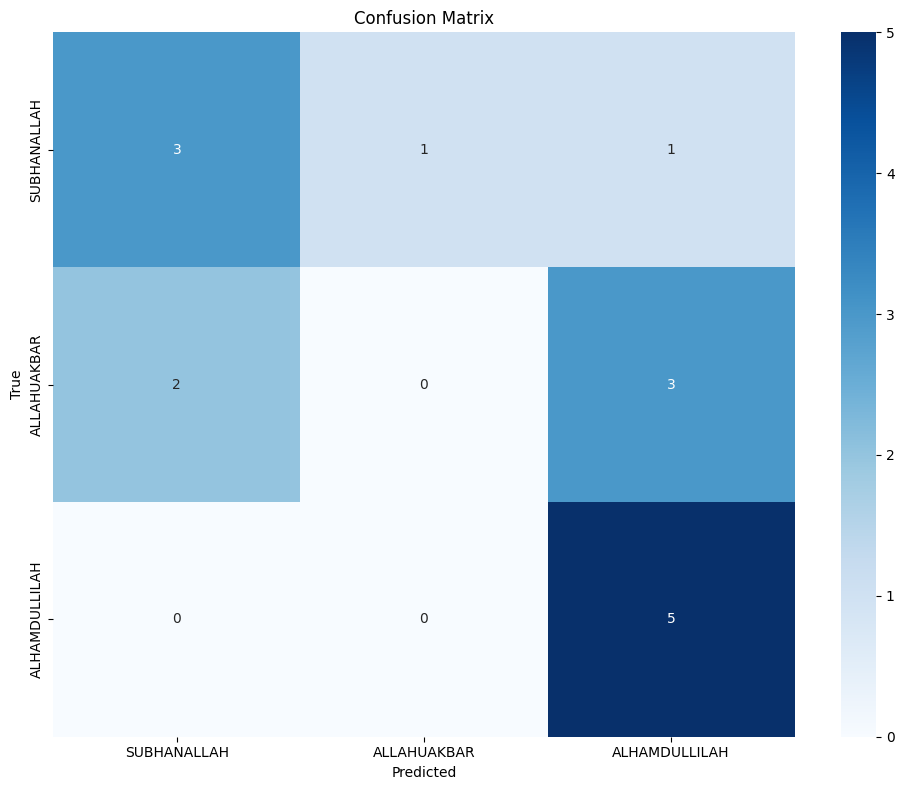

Accuracy for class SUBHANALLAH: 60.00%
Accuracy for class ALLAHUAKBAR: 0.00%
Accuracy for class ALHAMDULLILAH: 100.00%
Training and evaluation completed!


In [16]:
# Training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
        
    # Train one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        
    # Validate
    val_loss, val_acc, all_preds, all_labels = validate(model, test_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
            
    print(f'Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%')
    print()
        
    # Plot metrics
    plot_metrics(train_losses, val_losses, train_accs, val_accs)
        
    # Plot confusion matrix
    print("Confusion Matrix:")
    plot_confusion_matrix(all_labels, all_preds)
    
    print("Training and evaluation completed!")
